In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

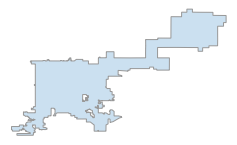

{'init': 'epsg:4326'}


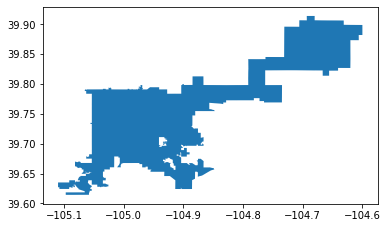

time: 438 ms


In [2]:
city = ox.gdf_from_place('Denver, USA', which_result=2)
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

1639
data max index: 1638
number of NA prices: 0
average bedroom price 93.41171143671146
pointinpoly length: 1627
check contains: True
check if there are NAs: False


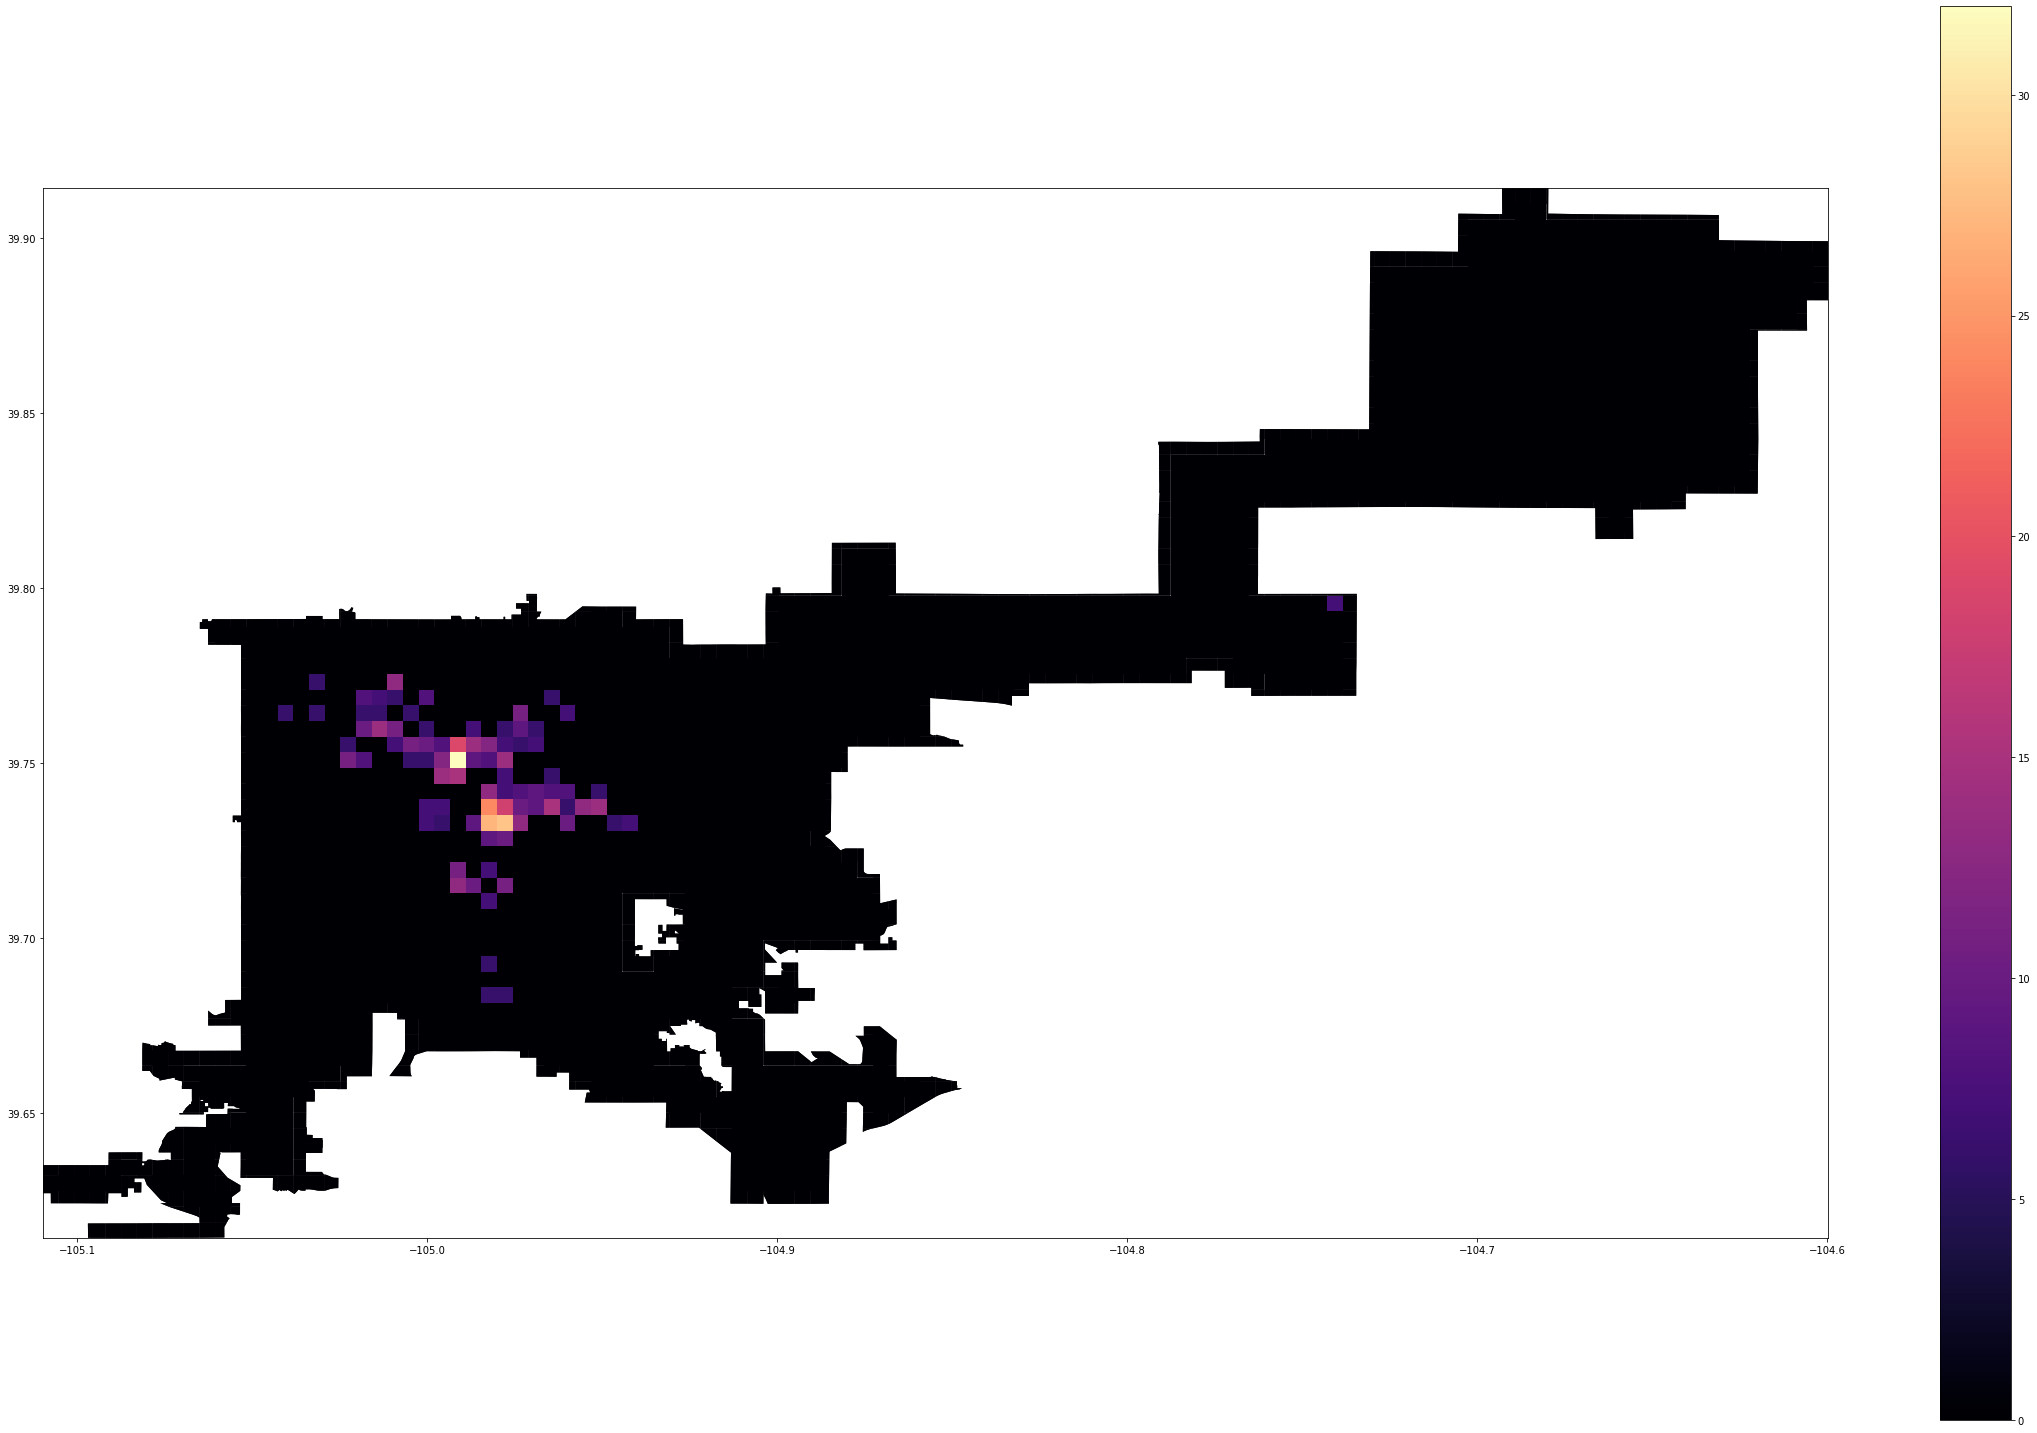

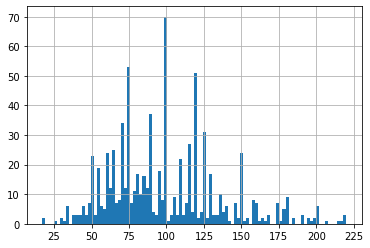

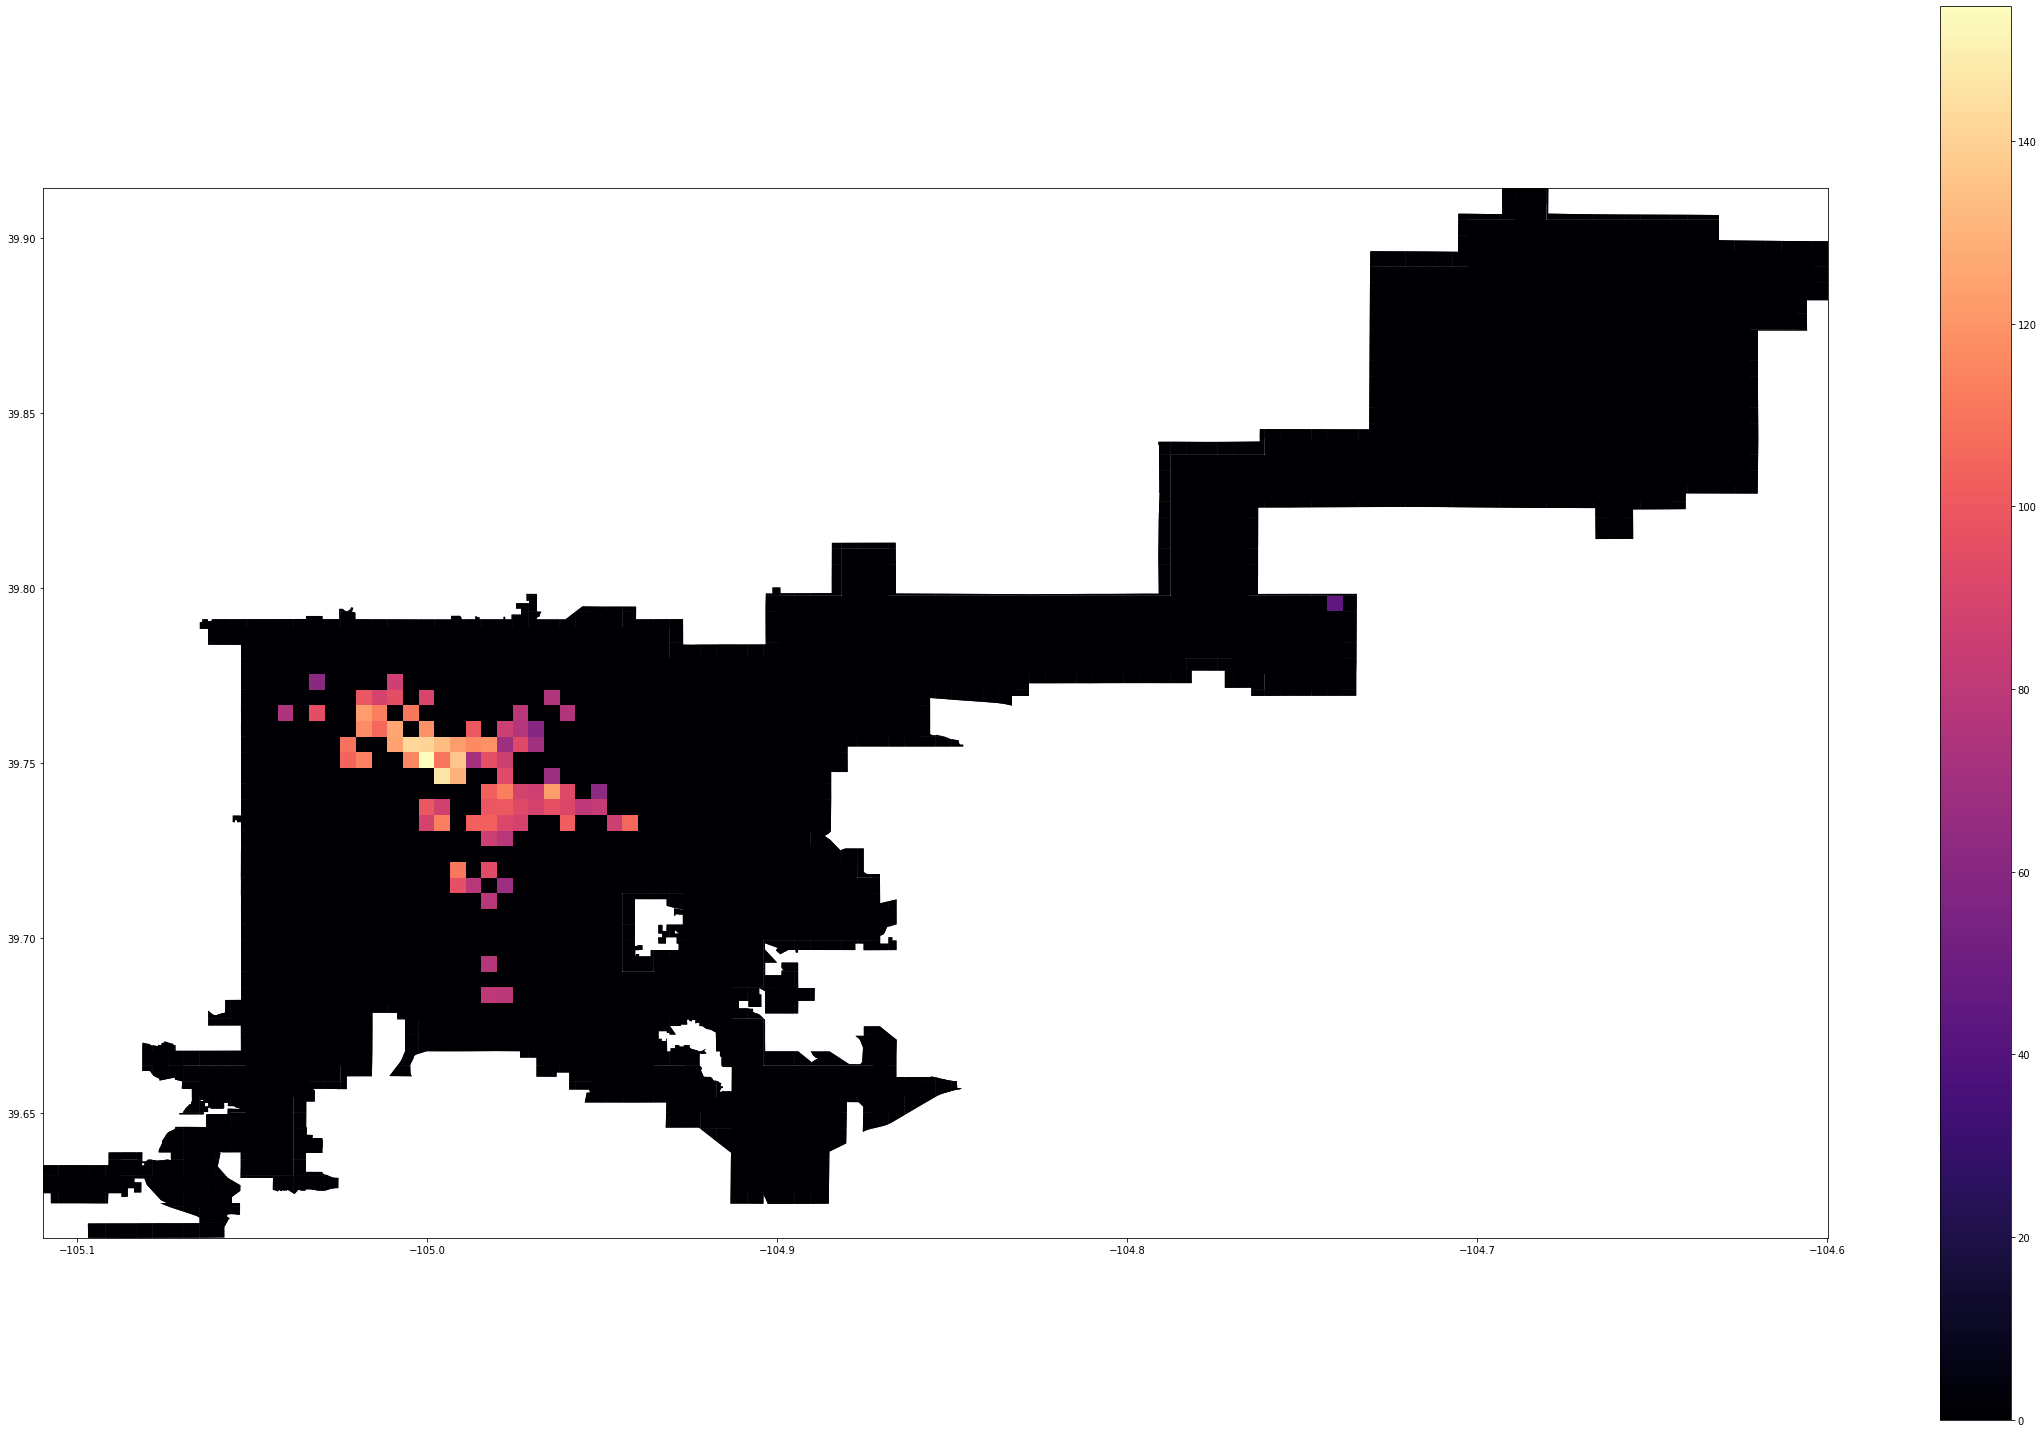

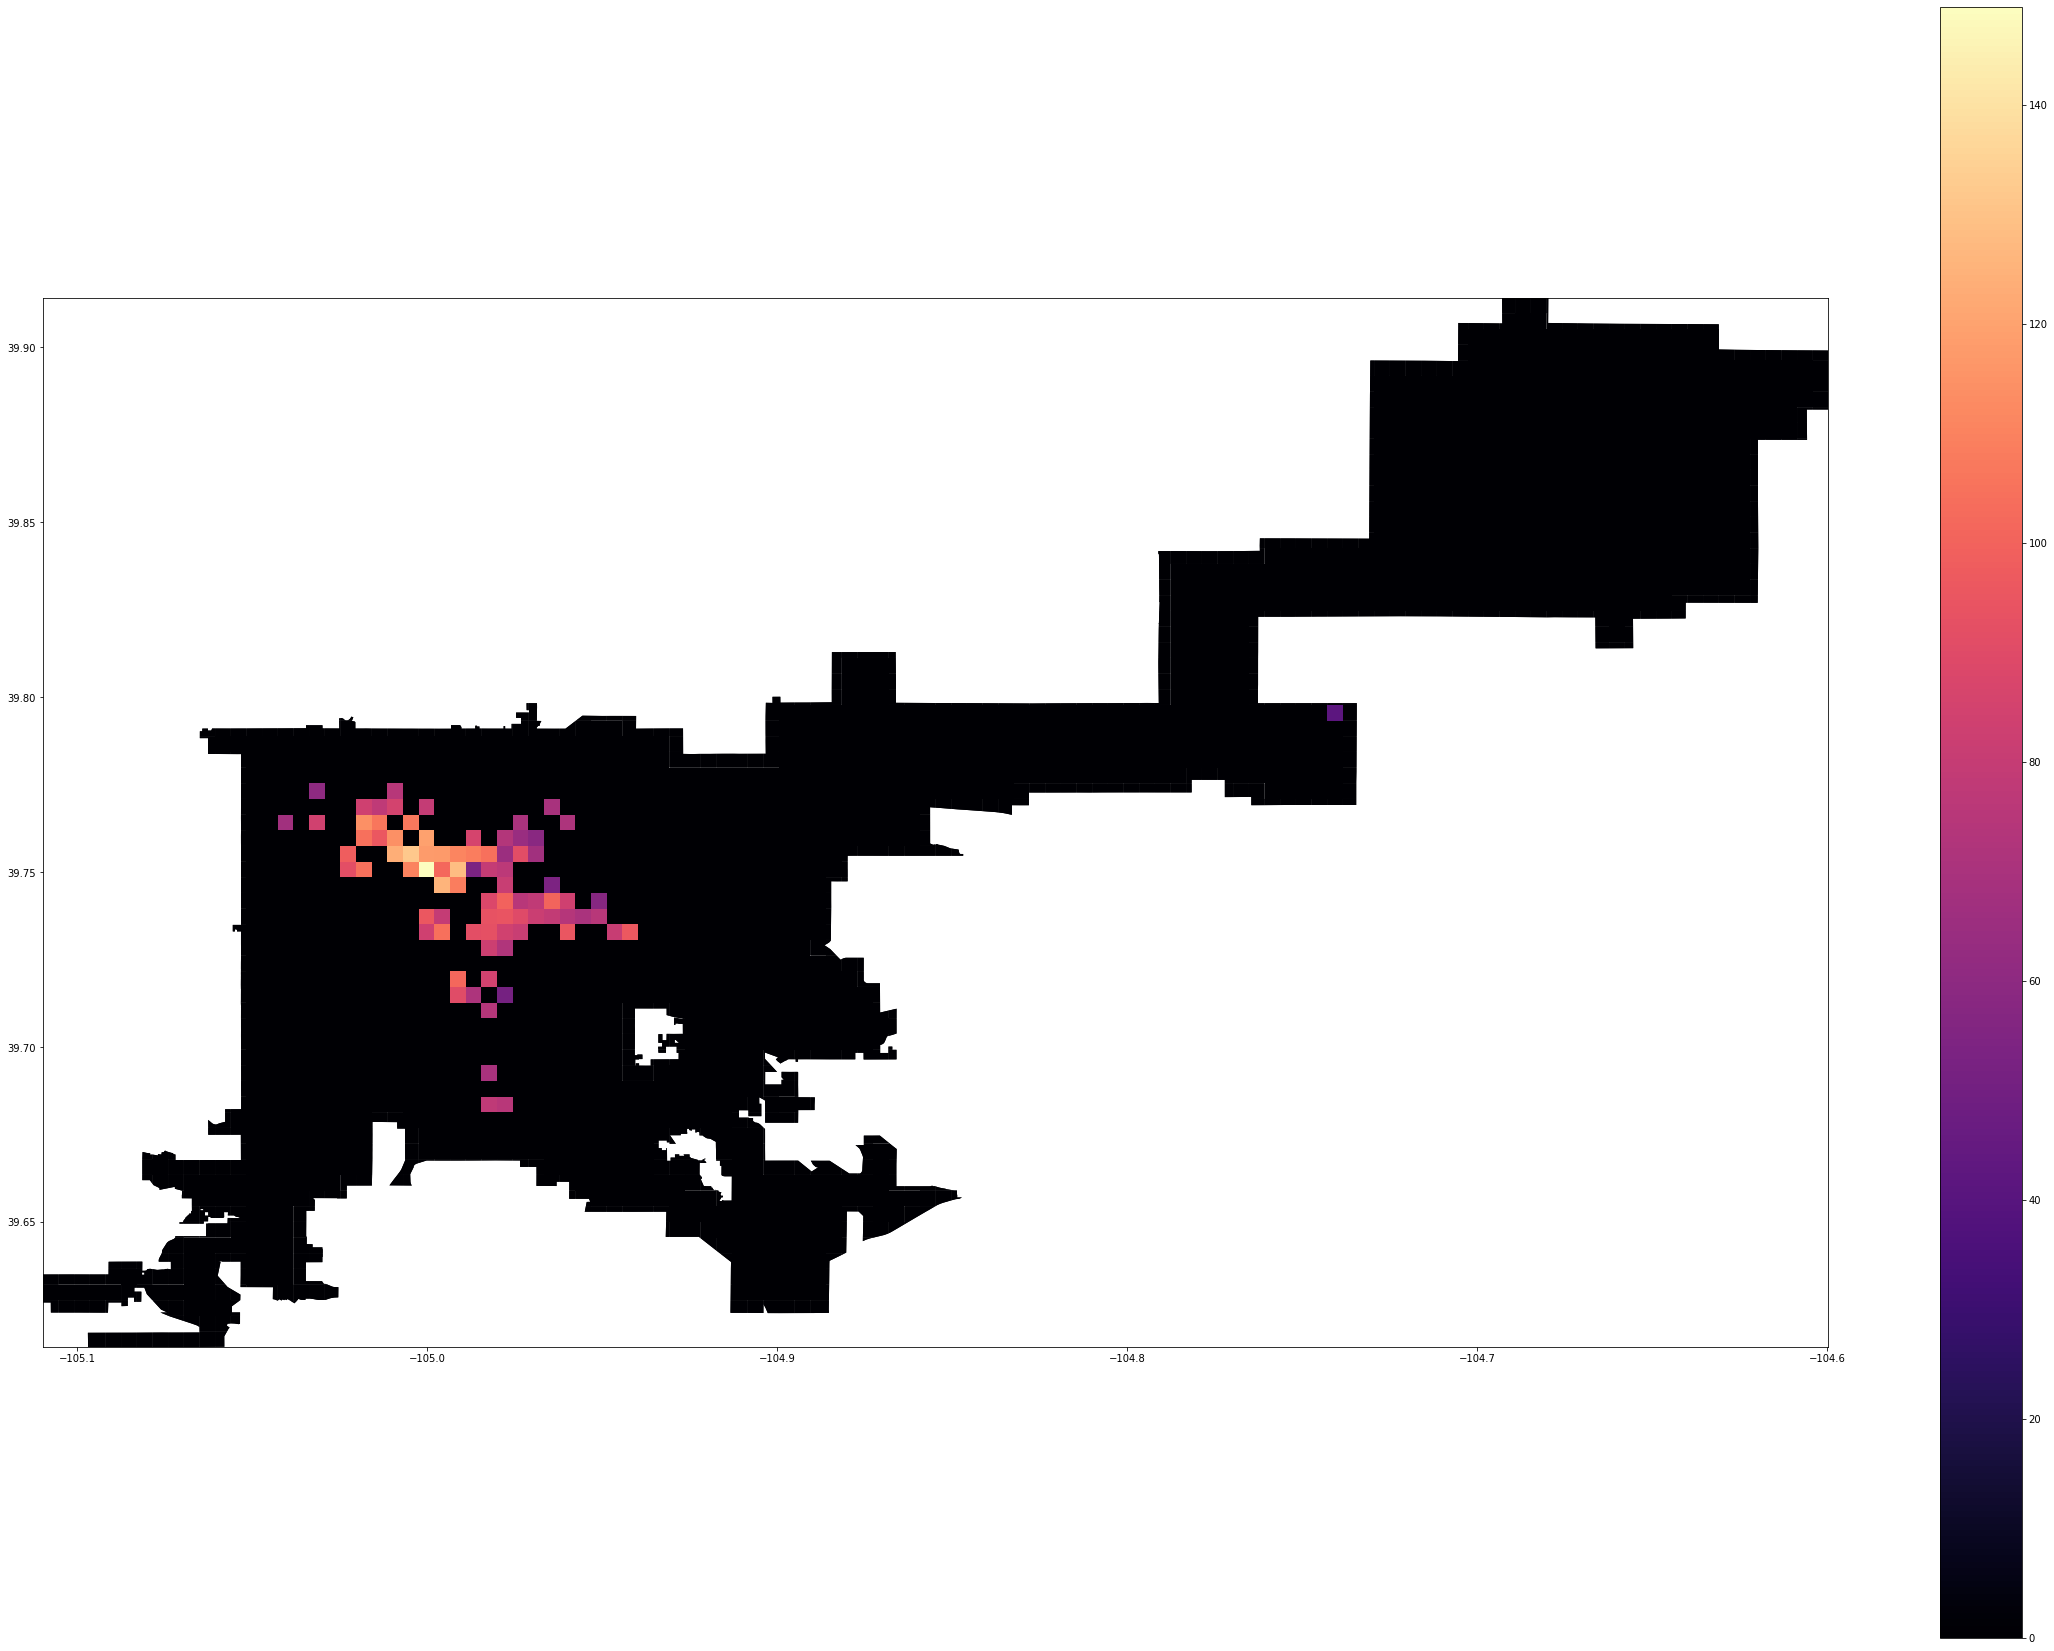

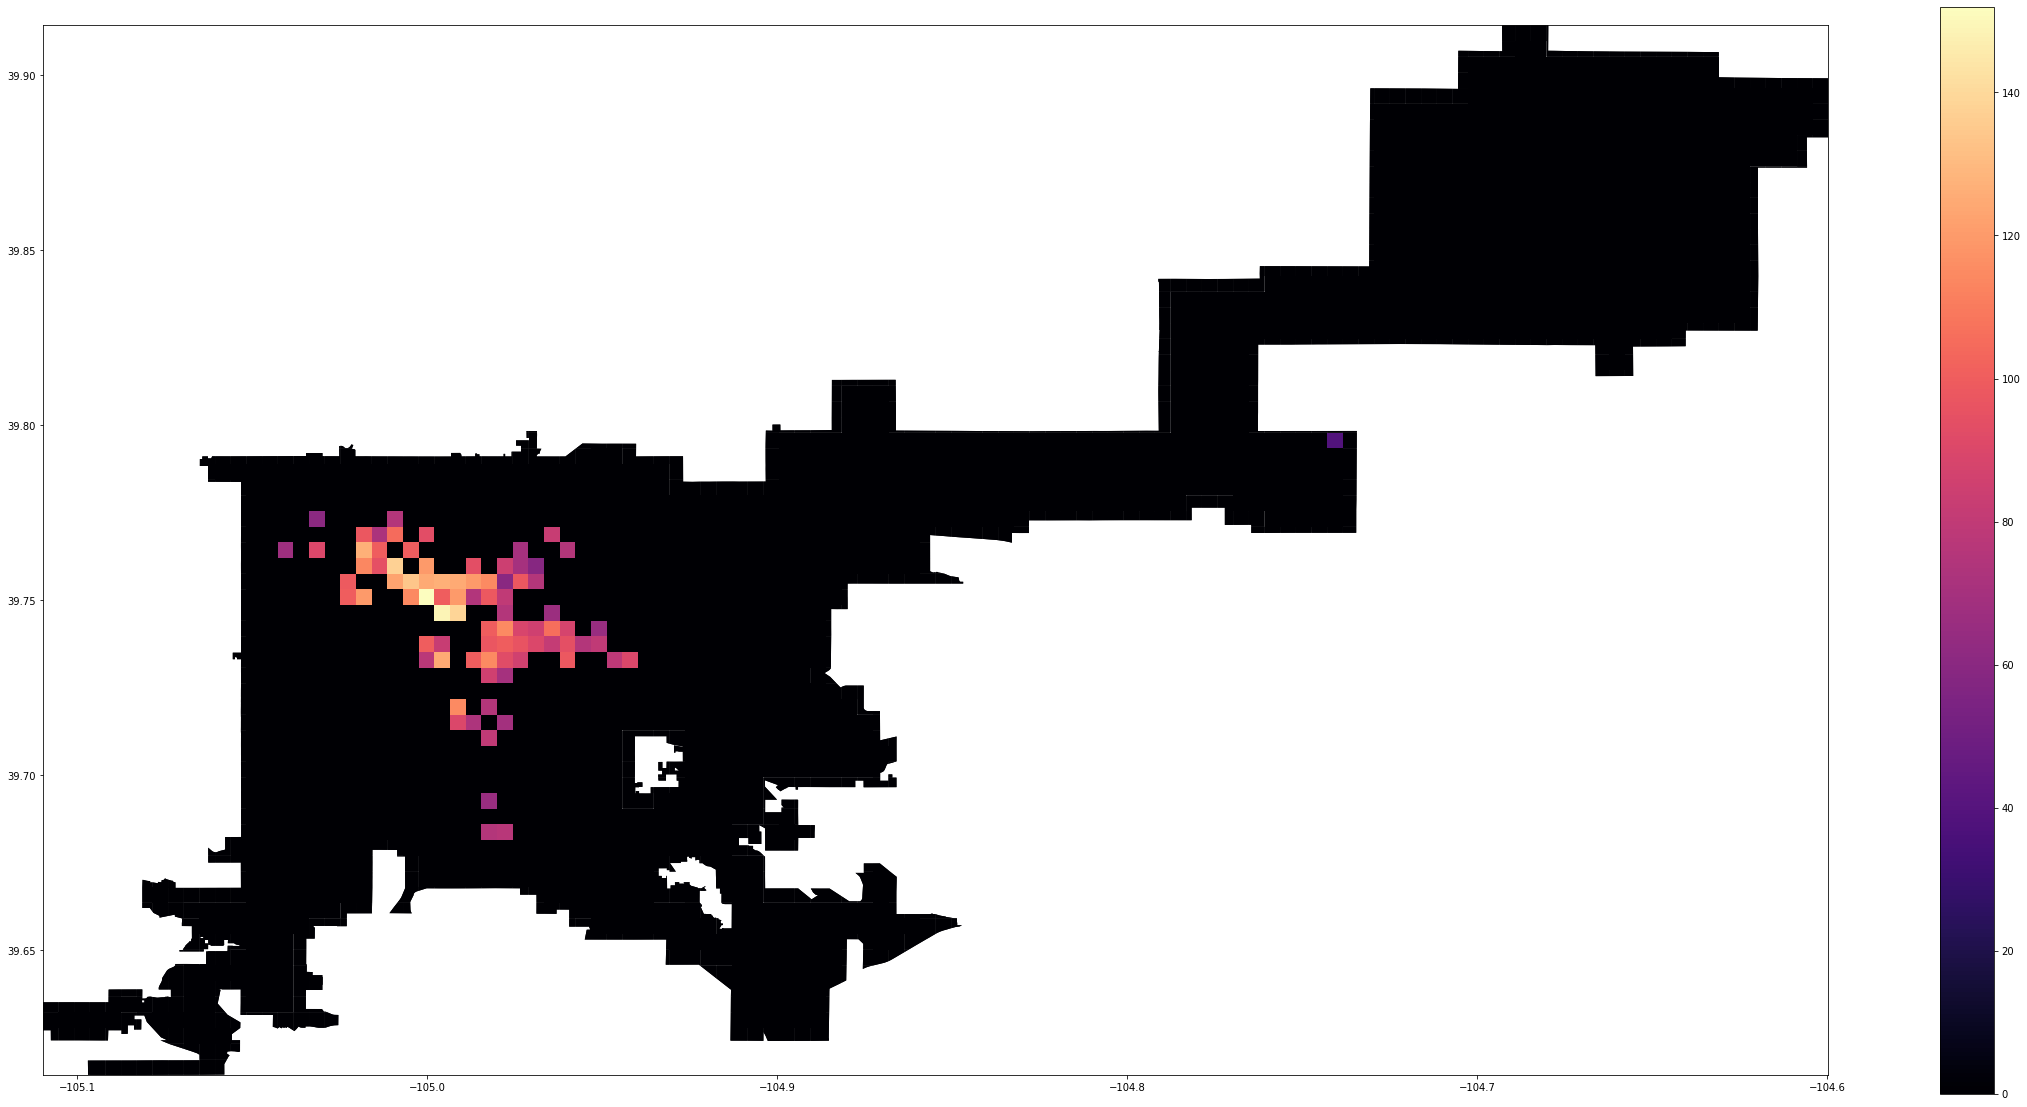

time: 13.8 s


In [3]:
data = pd.read_csv('data/Airbnb_Denver.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]
# plot the city

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>5]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<225]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


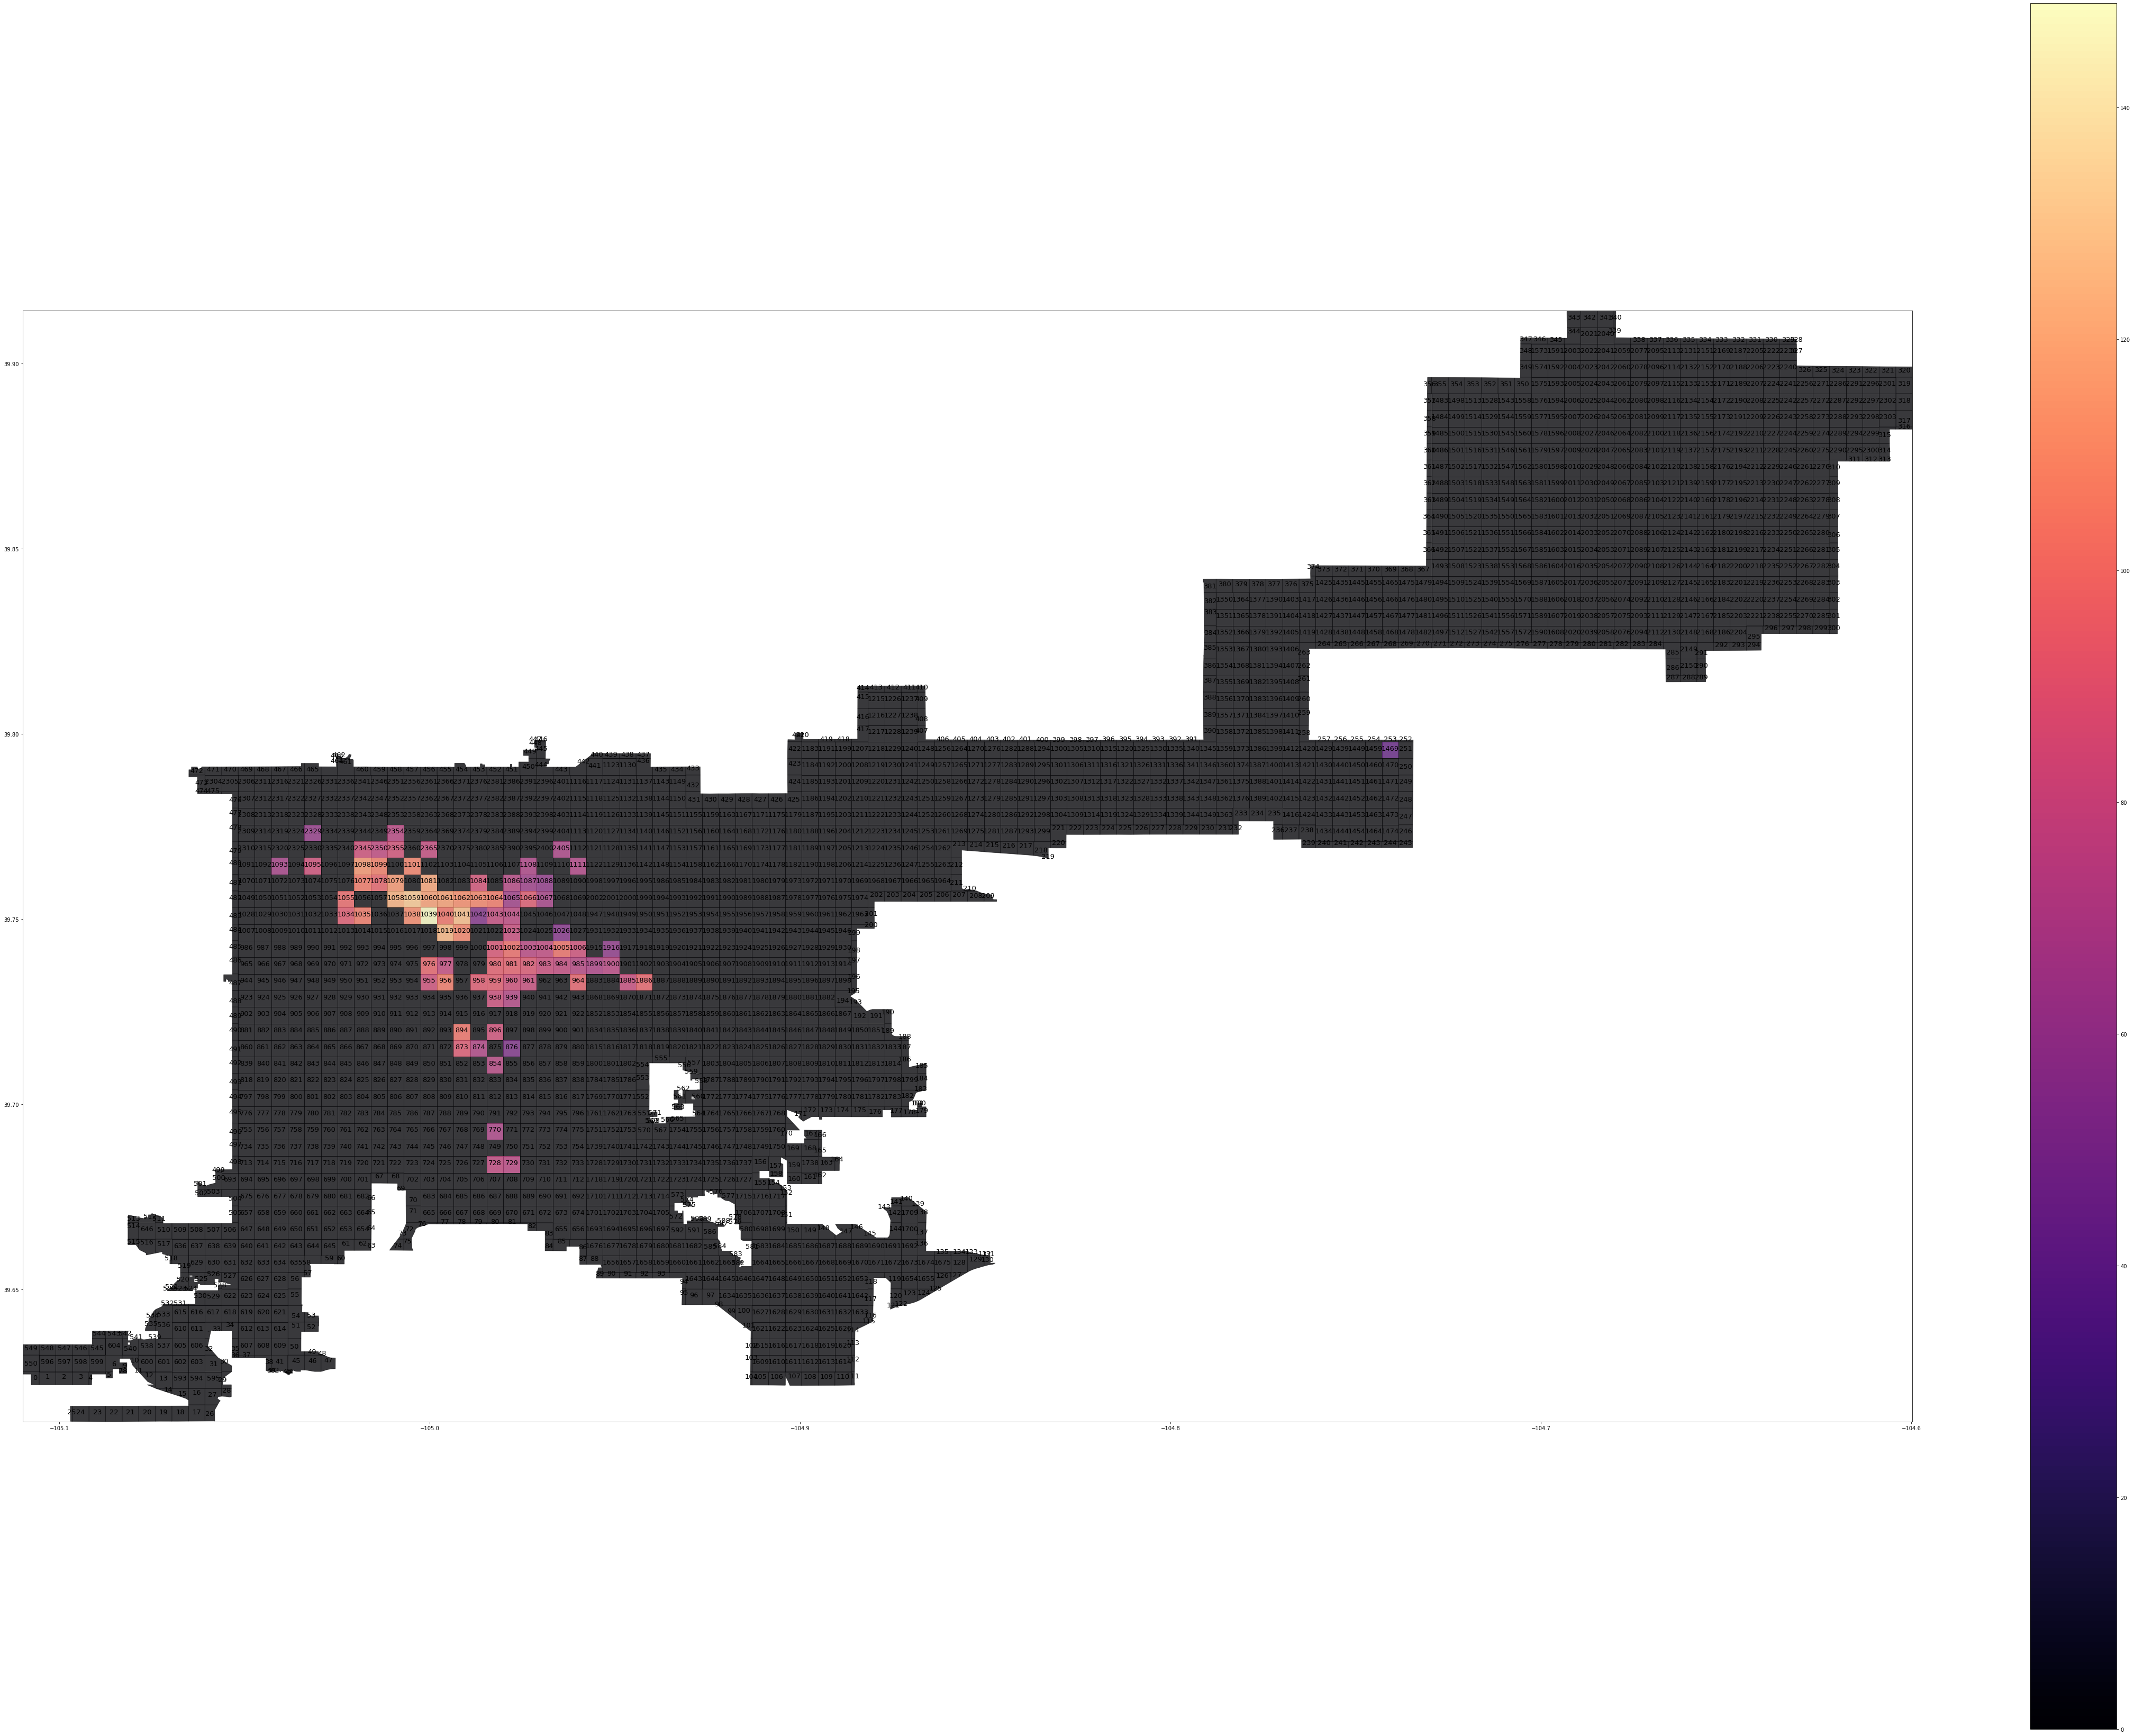

time: 25 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds

fig, ax = plt.subplots(figsize=(80,60))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=13)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

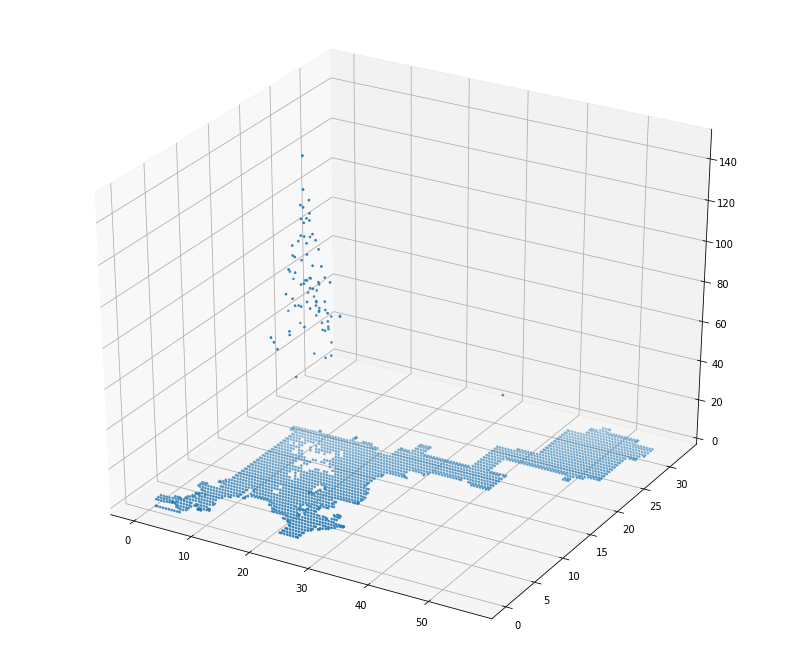

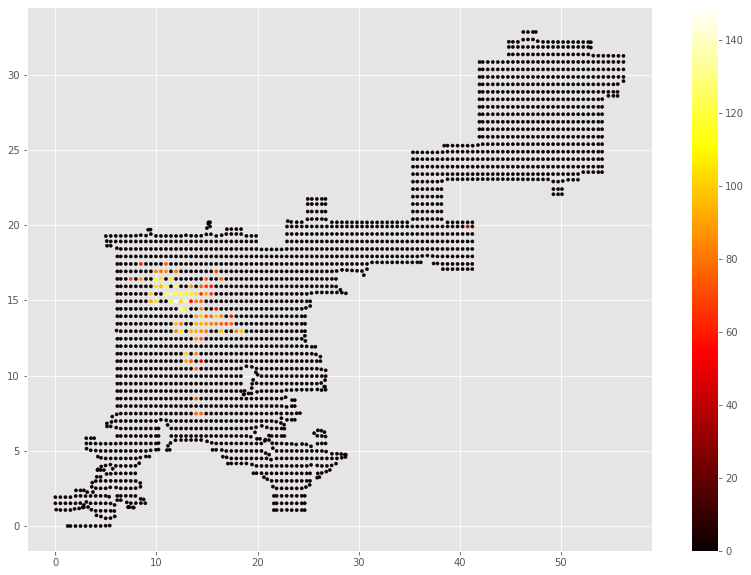

time: 2.84 s


In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.hmean_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.hmean_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.hmean_prices), s=10, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Denver_observed.jpg')
plt.show()

In [6]:
cdf = polyair[polyair.index.isin([1039,1005])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
1005  POLYGON ((-104.9666716999955 39.73964394328808... -104.964434   
1039  POLYGON ((-105.0024748999955 39.74859598209405... -105.000237   

      center_lat  count  prices  hmean_prices  median_prices  cen_lon_km  \
1005   39.741882      8  123.00    100.294185         106.25   15.913021   
1039   39.750834      6  154.75    148.977178         152.00   11.934569   

      cen_lat_km  
1005   13.945086  
1039   14.939836

time: 332 ms


Fitted parameters:
[96.11770974 12.94123721 14.90447456  0.94570334  2.94285437  2.00081712
  0.98866953]
RMS residual = 12.188006954732847


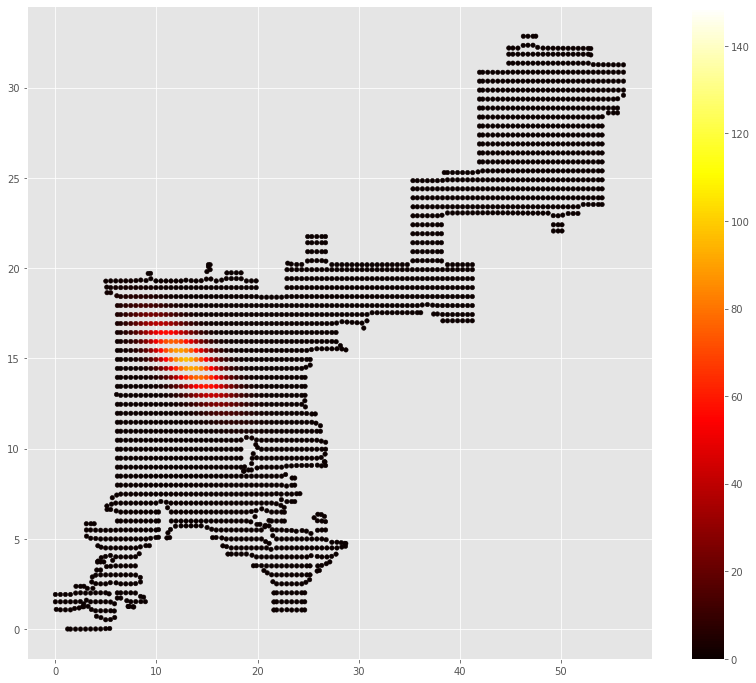

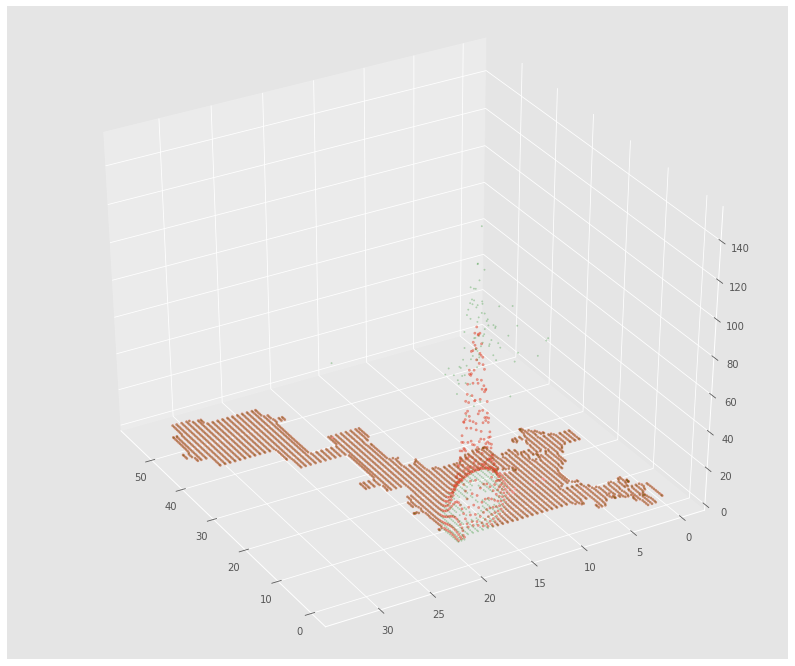

{'Denver': 0.9886695315944182}
time: 1.39 s


In [7]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.hmean_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr

guess_prms = [(100.294185,15.913021,13.945086, 1, 5.5,1.6, 1),
              #(148.977178,11.934569,14.939836, 2, 0.6,0.4, 1.5)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Denver_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Denver'] = np.mean(popt[6::7])
print(alphas)

In [8]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Denver'] = alphas['Denver']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 62.35708529  14.51772816  13.82447079   1.7494175    1.5388285
   8.60911042 116.31196162  11.40542861  15.65893098   1.55237245
   0.60154382   0.42461598]
RMS residual = 11.735375329468352


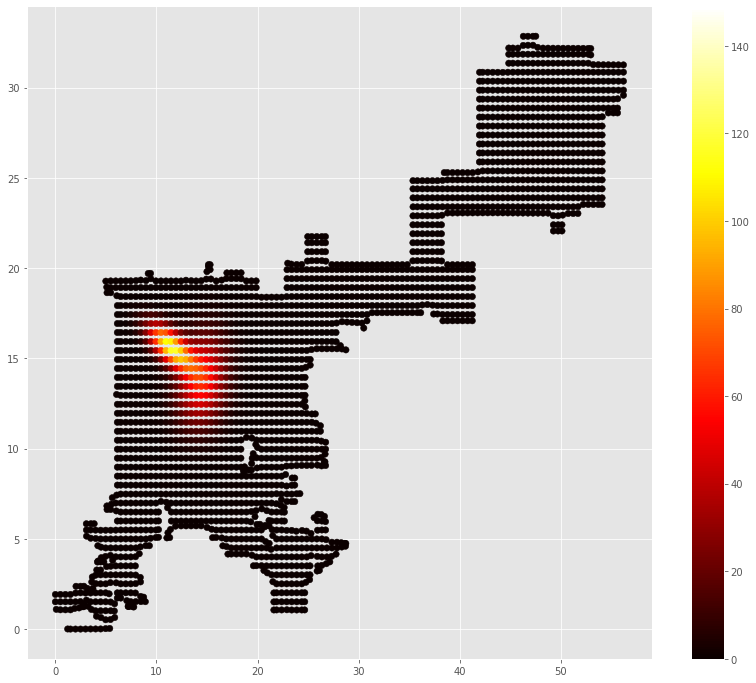

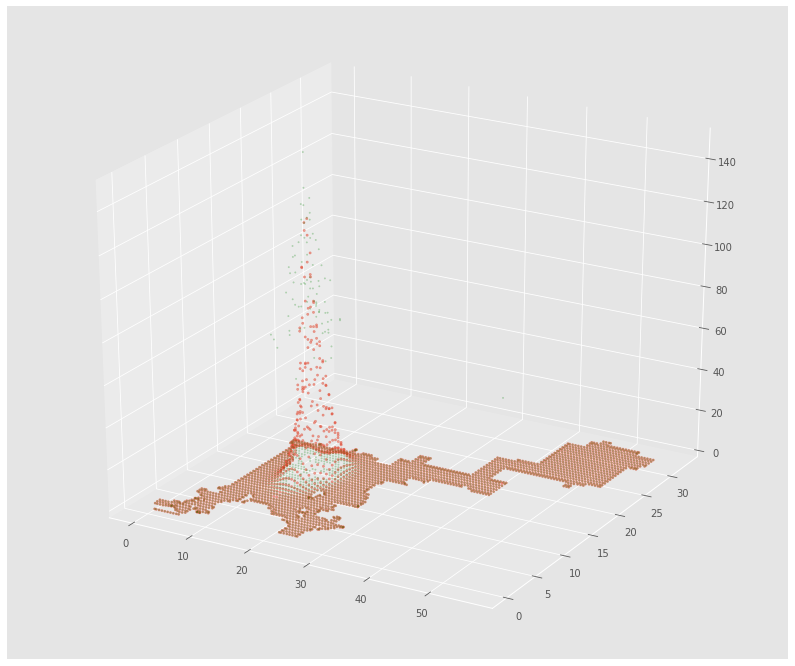

[ 62.35708529 116.31196162]
time: 1.57 s


In [9]:
xy = np.vstack([x, y])
zobs = np.array(polyair.hmean_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(100.294185,15.913021,13.945086, 1, 1,1),
              (148.977178,11.934569,14.939836, 1, 1,1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Denver_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.hmean_prices))+2)
ax.view_init(25, 300)
plt.show()

print(popt[::6])

In [10]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
long stds:  [0.00736901 0.01010633] mean:  0.00873766709683174
short stds:  [0.00648195 0.0039162 ] mean:  0.005199074627718015
time: 85.1 ms


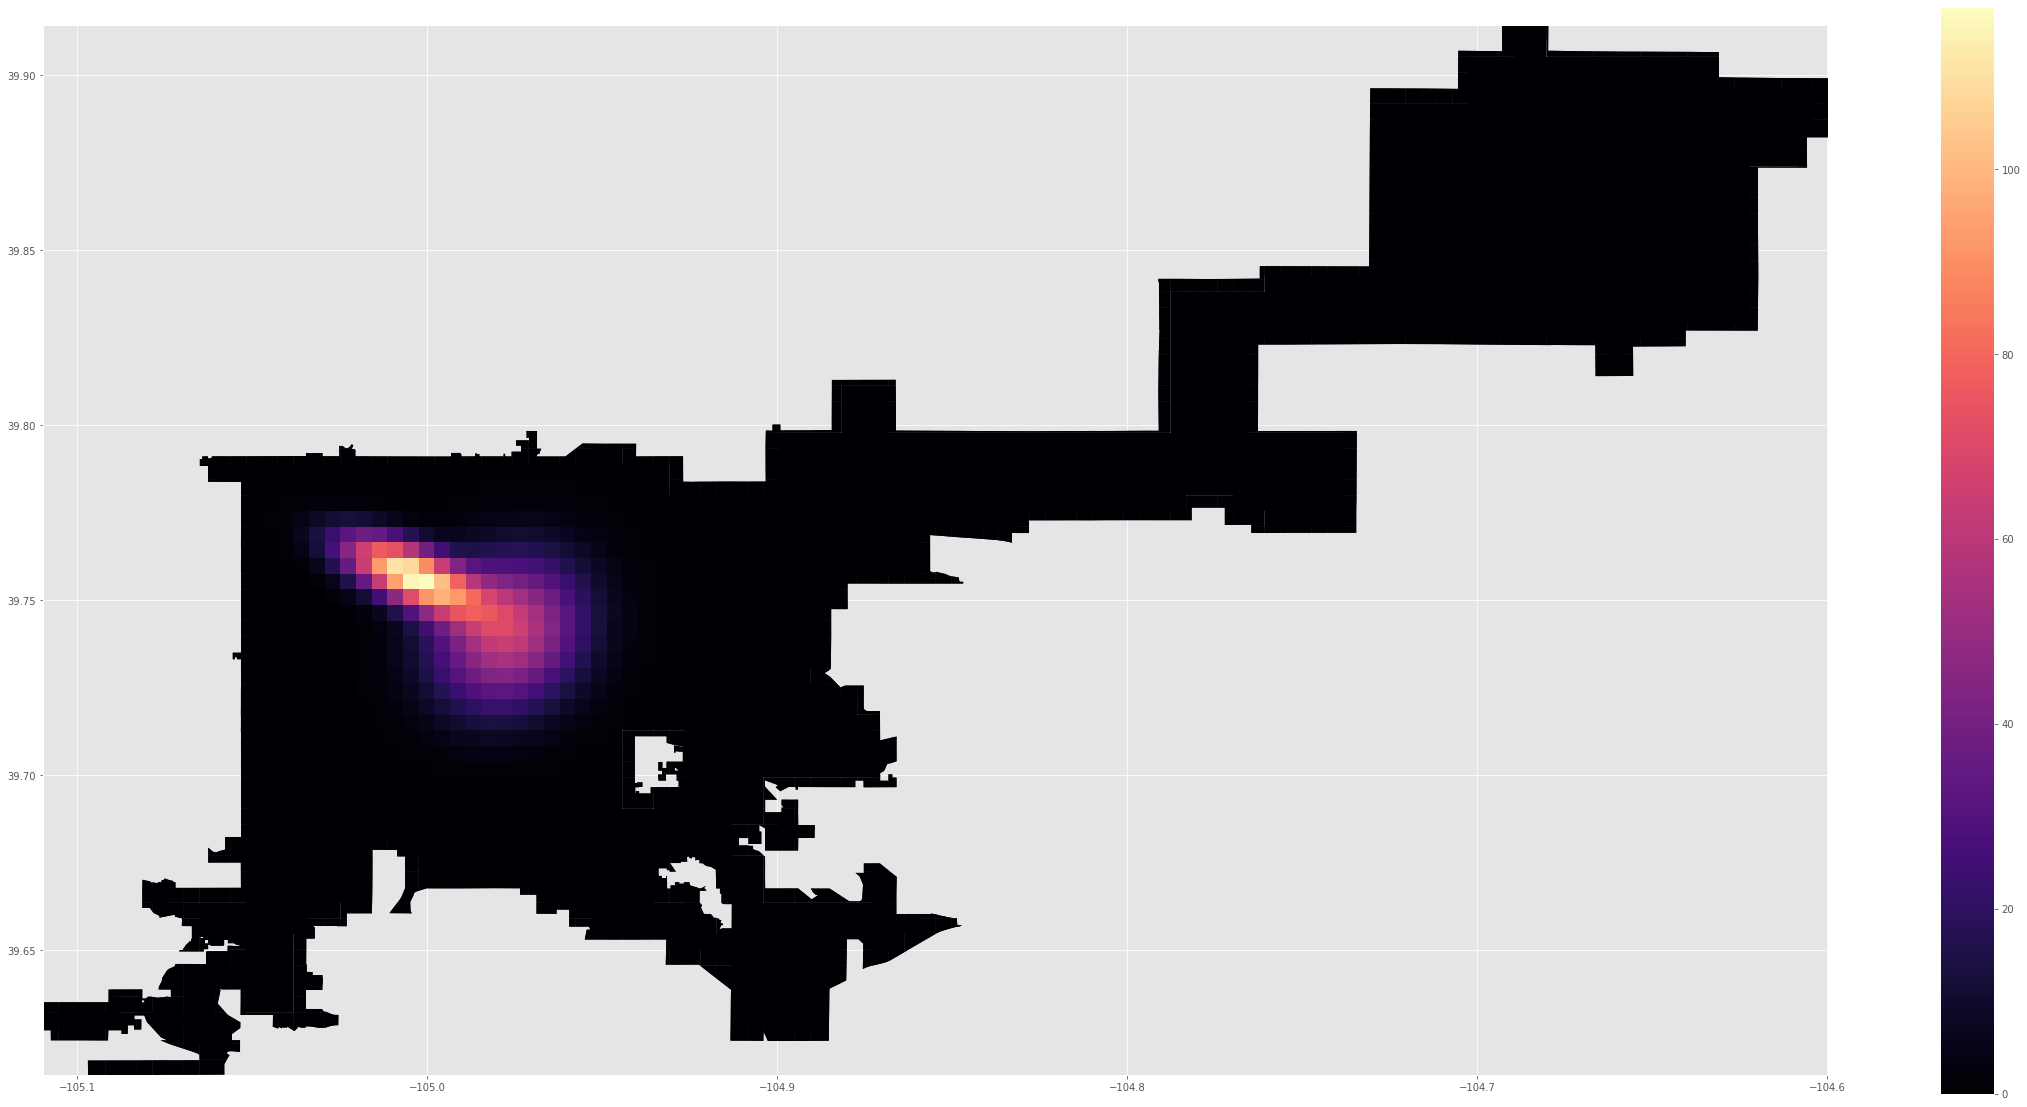

time: 1.89 s


In [11]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [12]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Denver'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Denver'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Denver'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

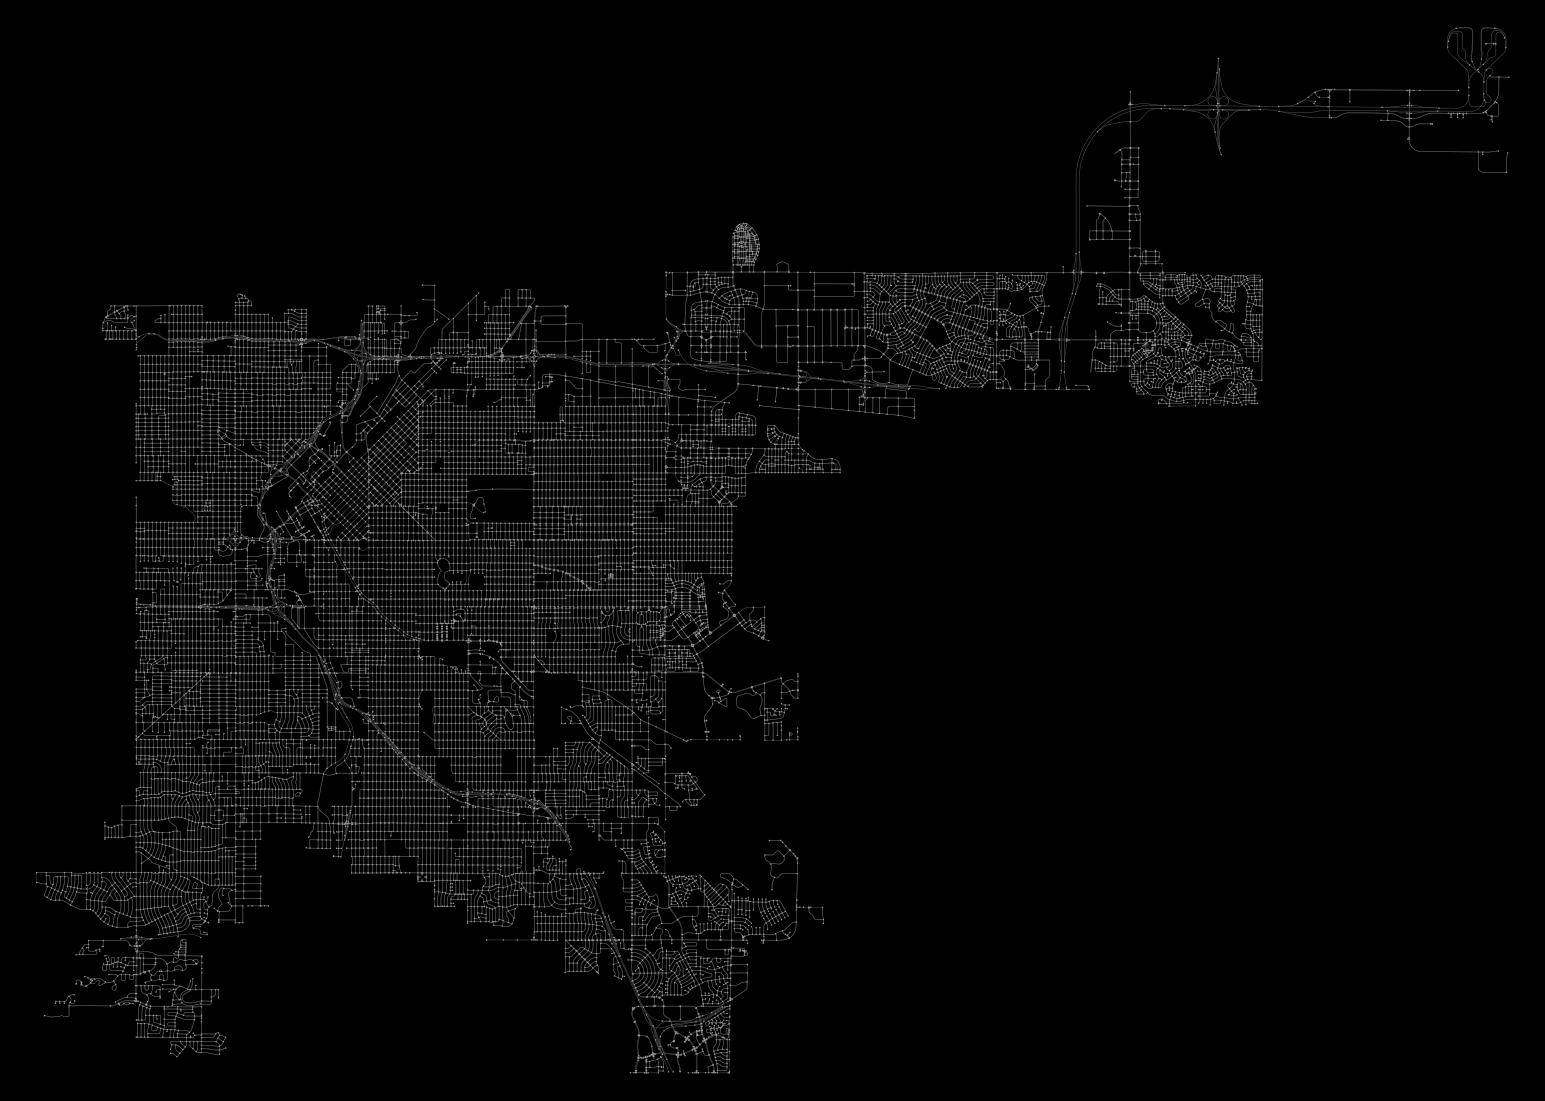

time: 1min 6s


In [13]:
# download and project a street network
G = ox.graph_from_place('Denver, USA', which_result=2, network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [14]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 176095776, 'center_node_2': 279956716}

time: 109 ms


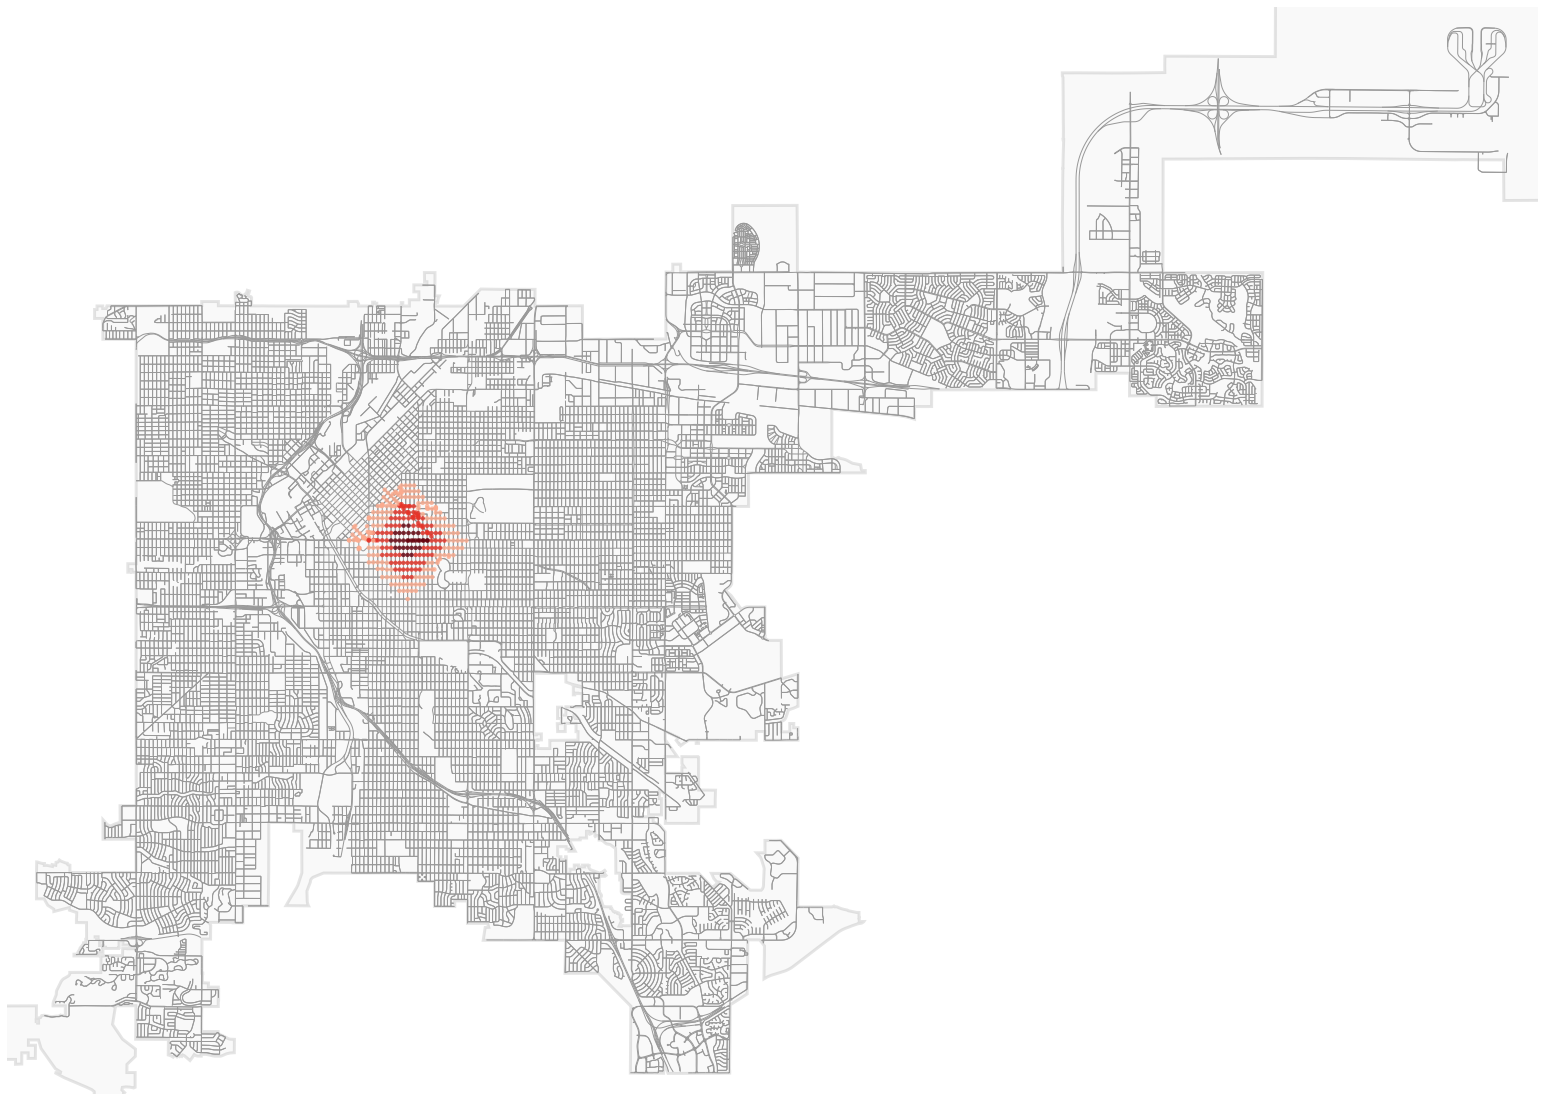

time: 8.9 s


In [15]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

2406
2406 202
Number of cells with price above 5th percentile:  202



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


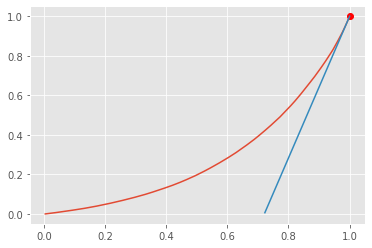

Loubar price:  42.98179246720029
Average price:  32.659750559811485
average city distance:  3896.3436245957214
eta =  0.6312111392217781
time: 3.82 s


In [16]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [17]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Denver'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 10 ms


In [18]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Denver'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345,
 'Buenos_Aires': 4620.5517793826875,
 'Denver': 3896.3436245957214}

time: 8 ms


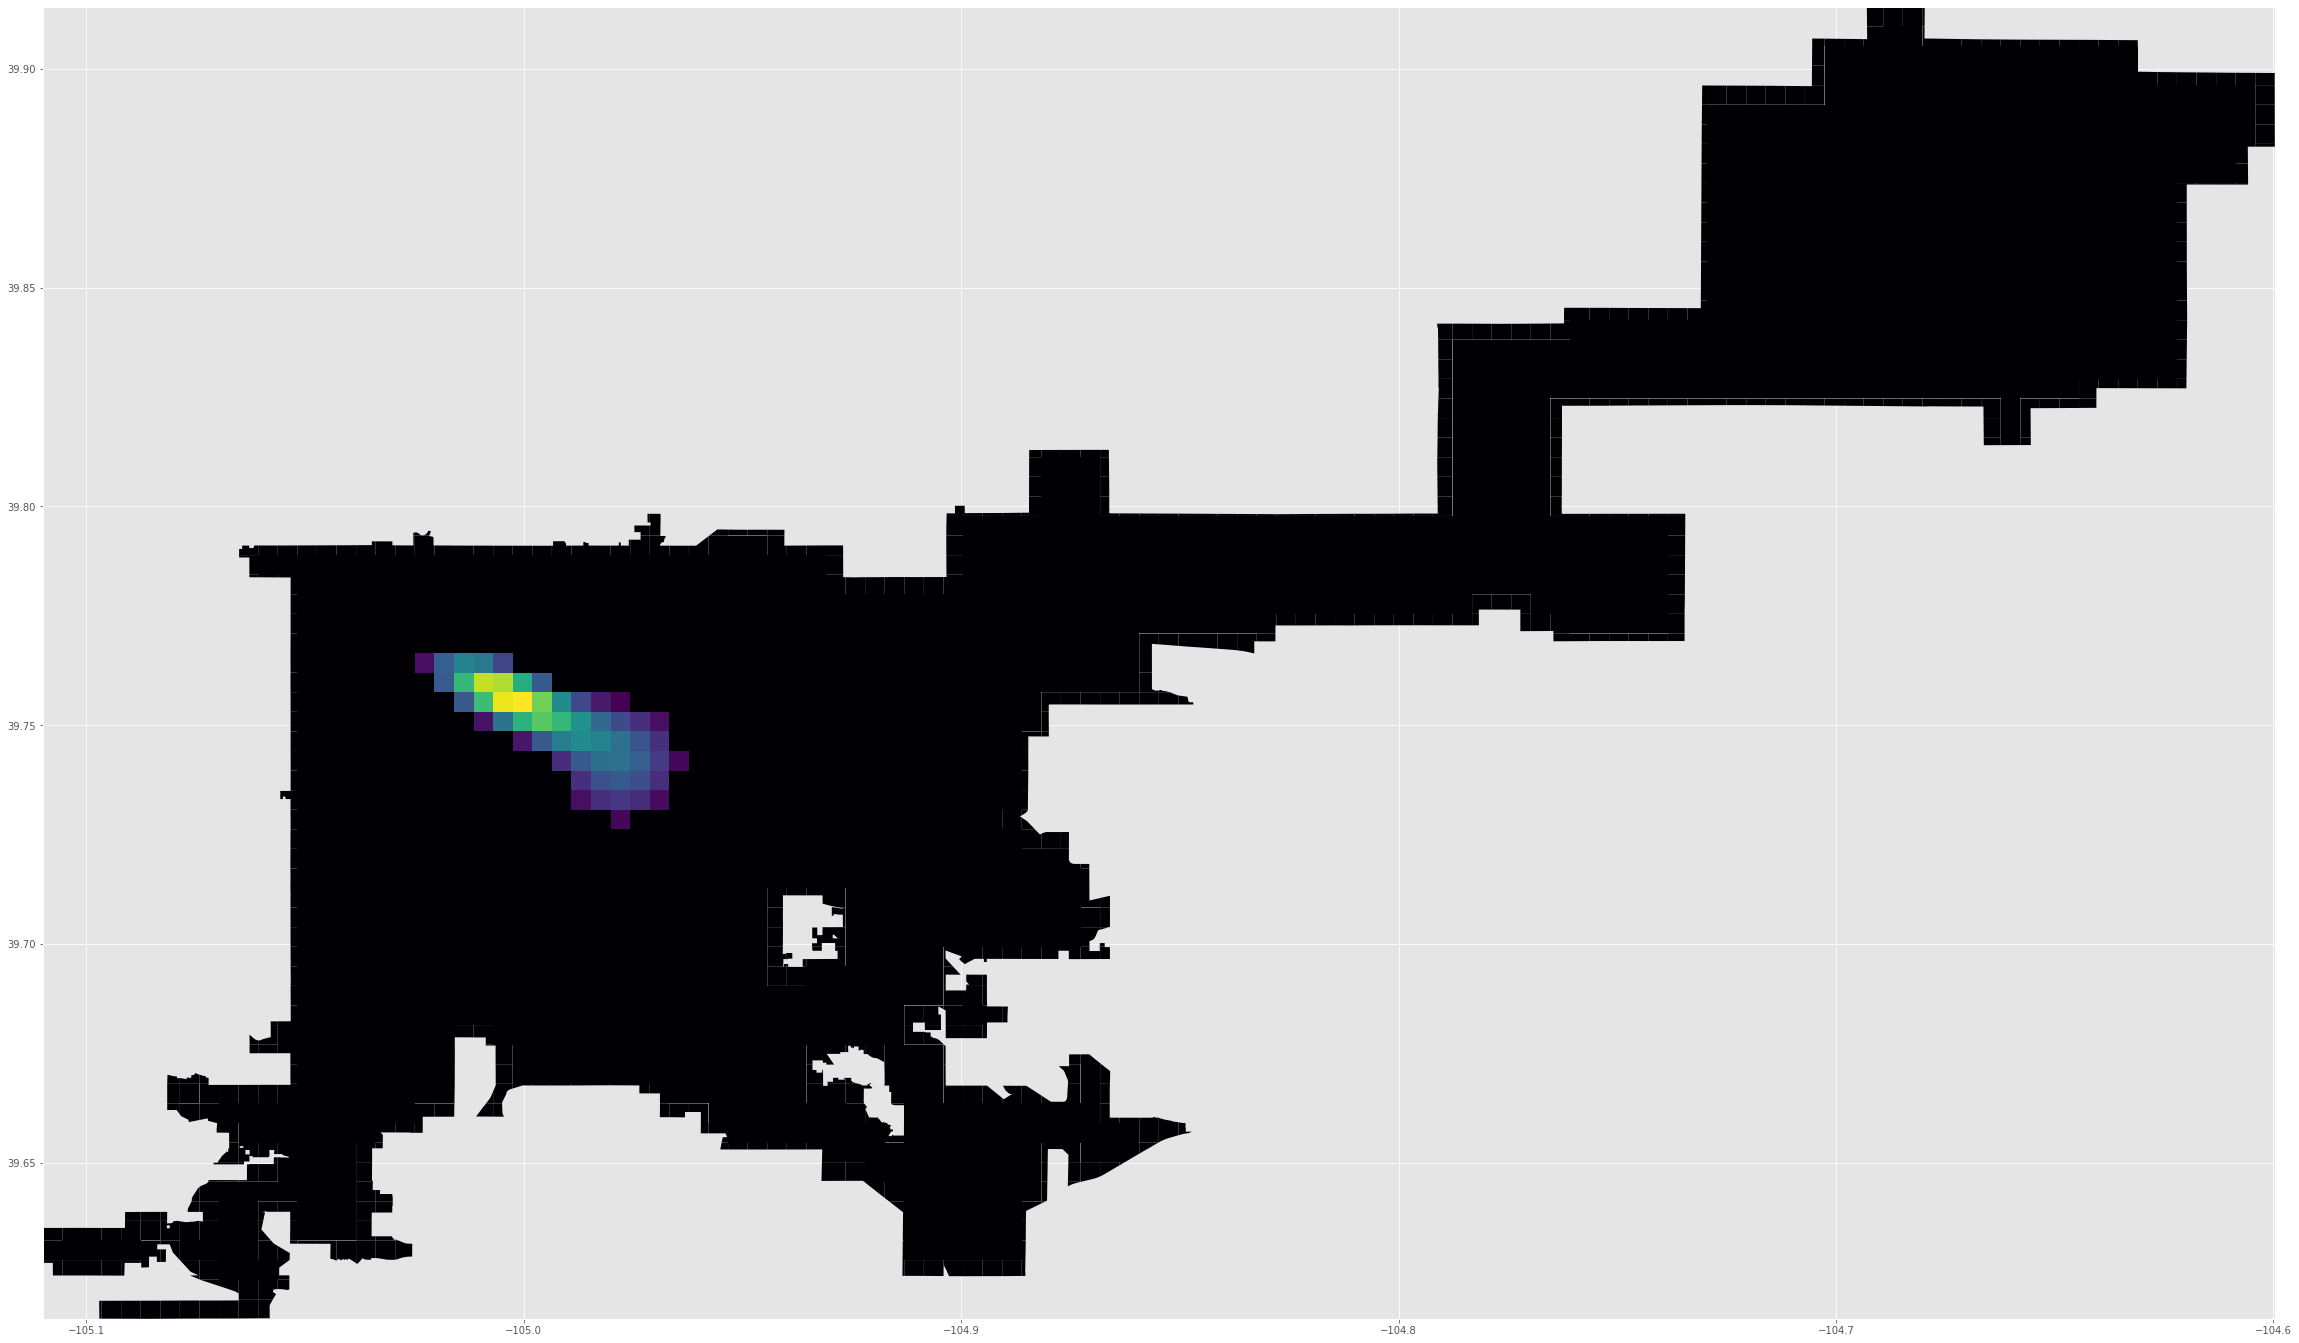

time: 1.43 s


In [19]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [20]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

2406
320



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00447602 0.00895204]
 [0.         0.         0.         ... 0.         0.         0.00447602]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 5.78 s


2406


2406 320
Number of cells with price above 1.0th percentile:  320
Loubar price:  28.215053296125202
Average price:  21.696533288383222
eta =  0.6009491382978265
2406 269
Number of cells with price above 2.0th percentile:  269
Loubar price:  32.814460702462085
Average price:  25.49195972860742
eta =  0.6174588057792653
2406 237
Number of cells with price above 3.0th percentile:  237
Loubar price:  37.29004773810646
Average price:  28.538560102528912
eta =  0.6039862999185456
2406 222
Number of cells with price above 4.0th percentile:  222
Loubar price:  41.5364426658078
Average price:  30.1979864780655
eta =  0.622837365166549
2406 202
Number of cells with price above 5.0th percentile:  202
Loubar price:  42.98179246720029
Average price:  32.659750559811485
eta =  0.6312111392217781
2406 191
Number of cells with price above 6.000000000000001th percentile:  191
Loubar price:  44.25813251235149
Average price:  34.16700356213687
eta =  0.6371309216557048
2406 177
Number of cells with price 

eta =  0.5338145840770431
2406 32
Number of cells with price above 52.0th percentile:  32
Loubar price:  92.72871628672549
Average price:  80.57134557387835
eta =  0.49322162863980695
2406 32
Number of cells with price above 53.0th percentile:  32
Loubar price:  92.72871628672549
Average price:  80.57134557387835
eta =  0.49322162863980695
2406 31
Number of cells with price above 54.0th percentile:  31
Loubar price:  92.72871628672549
Average price:  81.1446627761132
eta =  0.5043643405651426
2406 25
Number of cells with price above 55.00000000000001th percentile:  25
Loubar price:  94.35477527614512
Average price:  85.3110228633717
eta =  0.46829005539865254
2406 23
Number of cells with price above 56.00000000000001th percentile:  23
Loubar price:  94.35477527614512
Average price:  87.04754112396385
eta =  0.5130014472456347
2406 23
Number of cells with price above 57.00000000000001th percentile:  23
Loubar price:  94.35477527614512
Average price:  87.04754112396385
eta =  0.513001447

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
2406 6
Number of cells with price above 81.0th percentile:  6
Loubar price:  115.44616051119236
Average price:  108.76244893651022
eta =  nan
2406 6
Number of cells with price above 82.0th percentile:  6
Loubar price:  115.44616051119236
Average price:  108.76244893651022
eta =  nan
2406 6
Number of cells with price above 83.0th percentile:  6
Loubar price:  115.44616051119236
Average price:  108.76244893651022
eta =  nan
2406 5
Number of cells with price above 84.00000000000001th percentile:  5
Loubar price:  115.44616051119236
Average price:  110.85647795735272
eta =  nan
2406 5
Number of cells with price above 85.0th percentile:  5
Loubar price:  115.44616051119236
Average price:  110.85647795735272
eta =  nan
2406 5
Number of cells with price above 86.0th percentile:  5
Loubar price:  115.44616051119236
Average price:  110.85647795735272
eta =  nan
2406 4
Number of cells with price above 87.0th percentile:  4
Loubar price:  115.44616051119236
Average price:  113.12360006

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  117.55211417881874
Average price:  117.55211417881874
eta =  nan
2406 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  117.55211417881874
Average price:  117.55211417881874
eta =  nan



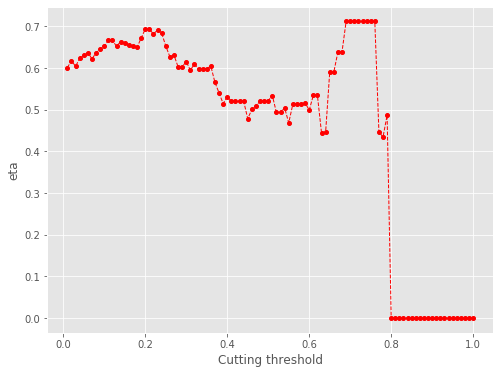

time: 2.31 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [22]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Denver'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 39 ms


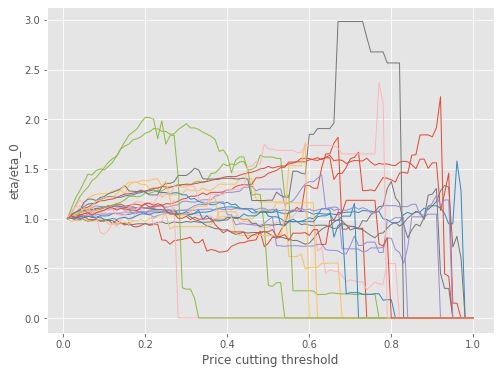

time: 275 ms


In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

2406 202
Number of cells with price above 5th percentile:  202


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9967300846665431
eta =  0.9741747365296094
eta =  0.9420997794747021
eta =  0.9299877948612375
eta =  0.9182059408122043
eta =  0.8983233775901638
eta =  0.8664489794919195
eta =  0.8428578770576488
eta =  0.8413911367796508
eta =  0.832213077934002
eta =  0.8121109921935105
eta =  0.8125218530300836
eta =  0.7975542115457621
eta =  0.7908180415757835
eta =  0.7784746220711795
eta =  0.7631748772954942
eta =  0.7652383442897528
eta =  0.754853934934096
eta =  0.7394749691889564
eta =  0.7342578721536068
eta =  0.7345860536759377
eta =  0.7240551831122913
eta =  0.7217843466097146
eta =  0.6982122492853373
eta =  0.6982122492853373
eta =  0.6790911000354789
eta =  0.6615802775105799
eta =  0.6436424627242299
eta =  0.6467128603518484
eta =  0.6450014665525668
eta =  0.6477310352550971
eta =  0.6318756981220014
eta =  0.632725268571781
eta =  0.6205418323424541
eta =  0.5904069936538395
eta =  0.5918080648226038
eta =  0.595

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan



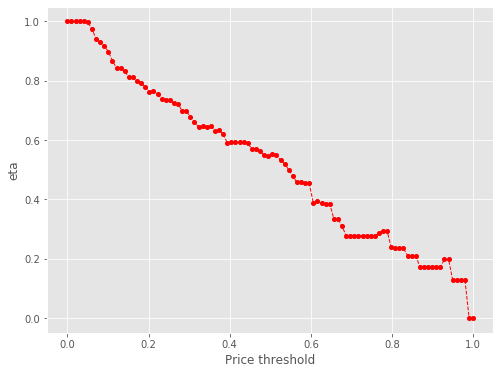

time: 791 ms


In [24]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [25]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Denver'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 57.9 ms


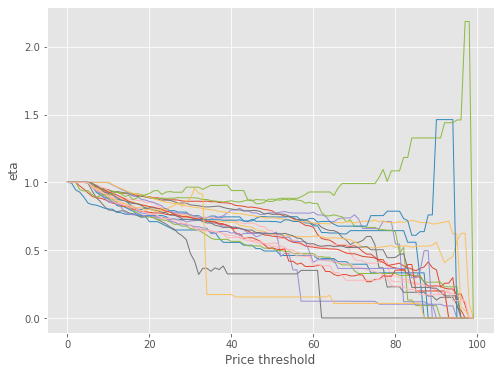

time: 228 ms


In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

2406 320
Number of cells with price above 1.0th percentile:  320


eta =  1.0
eta =  0.9273907992613485
eta =  0.872761339157019
eta =  0.8529102924193277
eta =  0.8201311506475397
eta =  0.7989510476017925
eta =  0.7785720334806386
eta =  0.7627119602877149
eta =  0.7530492947697199
eta =  0.7430147295309533
eta =  0.7128887574220657
eta =  0.6912540005436322
eta =  0.6900510811517365
eta =  0.6825238691899437
eta =  0.6681343553303131
eta =  0.6654775391711634
eta =  0.6540990532188172
eta =  0.6515458524540153
eta =  0.638451287549145
eta =  0.6259034902616486
eta =  0.6275958038219731
eta =  0.618451737088549
eta =  0.6102566167190128
eta =  0.6009491382978265
eta =  0.6007281735855794
eta =  0.5938202104581987
eta =  0.5901578698248732
eta =  0.5726256154025906
eta =  0.5726256154025906
eta =  0.5610631870523607
eta =  0.5425825942404705
eta =  0.5293190219715095
eta =  0.5303893622989231
eta =  0.5289857949331073
eta =  0.5289857949331073
eta =  0.5225290622121468
eta =  0.5189177025575483
eta =  0.5089256869839496
eta =  0.49765745379092713
eta

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan


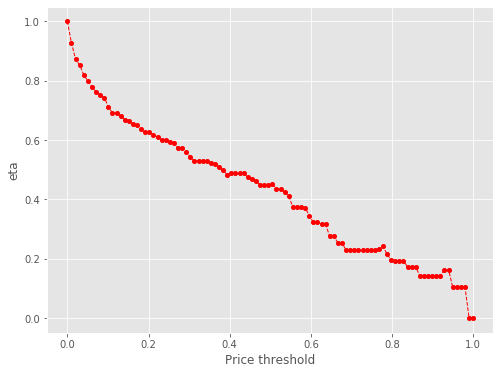

2406 269
Number of cells with price above 2.0th percentile:  269


eta =  1.0
eta =  0.9410933770878028
eta =  0.9196881110947582
eta =  0.8843425568819108
eta =  0.8613167749570614
eta =  0.8395296072602386
eta =  0.8224277843765567
eta =  0.8120085894420253
eta =  0.8011883772437167
eta =  0.7687037201467493
eta =  0.7453750900852204
eta =  0.7440779892374939
eta =  0.7375277035782248
eta =  0.7203487904746326
eta =  0.7175804846254732
eta =  0.713099813925996
eta =  0.7025580294445026
eta =  0.6915566928157009
eta =  0.6749080223355358
eta =  0.6749080223355358
eta =  0.6712189364232847
eta =  0.6580360913706198
eta =  0.6472814632660842
eta =  0.6477616276375068
eta =  0.6437679996237243
eta =  0.636363731767583
eta =  0.620990732308774
eta =  0.6174588057792653
eta =  0.6174588057792653
eta =  0.5844352922038227
eta =  0.5707615628633618
eta =  0.5719157044919677
eta =  0.5704827145098321
eta =  0.5704022461236792
eta =  0.5634399895150272
eta =  0.5595458818125625
eta =  0.5487715506659118
eta =  0.5417013324087756
eta =  0.5221220303687985
eta 

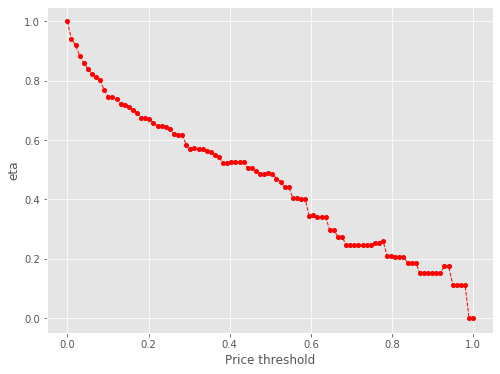

2406 237
Number of cells with price above 3.0th percentile:  237


eta =  1.0
eta =  0.9748603413406718
eta =  0.9358212317452079
eta =  0.9132570893977197
eta =  0.888399664857198
eta =  0.8703023236950531
eta =  0.8616500276135131
eta =  0.8485924016667323
eta =  0.8225314584633188
eta =  0.7911915653579554
eta =  0.7873916900006336
eta =  0.7804601041052838
eta =  0.7622811852061063
eta =  0.7593517328468959
eta =  0.7574604961505498
eta =  0.7434548019552502
eta =  0.7342526277645389
eta =  0.7254259225040808
eta =  0.7141952537076673
eta =  0.7138935473467405
eta =  0.6963411867574366
eta =  0.6920163765111588
eta =  0.6854686337728275
eta =  0.6858127645944843
eta =  0.6775862133116466
eta =  0.6679842538301306
eta =  0.6534018471457965
eta =  0.6534018471457965
eta =  0.6288029859926277
eta =  0.6191208701982873
eta =  0.6023342822701079
eta =  0.6052076255599335
eta =  0.6036060669066886
eta =  0.6061604552520237
eta =  0.5913226941263946
eta =  0.5921177401911616
eta =  0.5807162218921437
eta =  0.5525154000321212
eta =  0.553826552179037
eta

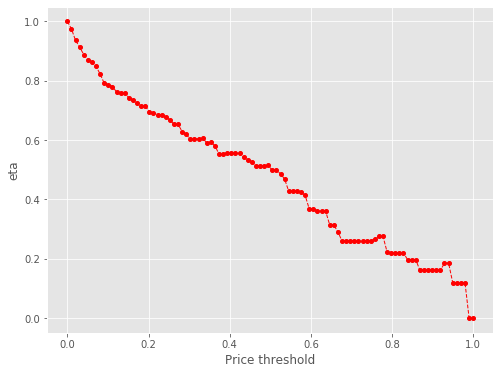

2406 222
Number of cells with price above 4.0th percentile:  222


eta =  1.0
eta =  0.9615678904767252
eta =  0.9365313790256415
eta =  0.9128416439578605
eta =  0.8942464020738217
eta =  0.8853560608326948
eta =  0.8719391886669876
eta =  0.8451612471864262
eta =  0.8129591193880529
eta =  0.8082250321555464
eta =  0.8019324102170927
eta =  0.7844261699143766
eta =  0.7802432976667442
eta =  0.778300028569177
eta =  0.7639090045517789
eta =  0.754453656752221
eta =  0.7453841079225473
eta =  0.733844456825862
eta =  0.7358286204305995
eta =  0.7154991822035419
eta =  0.7110553861833661
eta =  0.7060387931926727
eta =  0.7046810982085906
eta =  0.696228215014025
eta =  0.6940446515486247
eta =  0.6713784796503112
eta =  0.6713784796503112
eta =  0.6578220383070693
eta =  0.6361543518268546
eta =  0.6189059251029819
eta =  0.6218583208726958
eta =  0.6202126995473457
eta =  0.6202126995473457
eta =  0.6126424629370621
eta =  0.6084083017518868
eta =  0.5966931006780952
eta =  0.5834815902845936
eta =  0.5660421684666157
eta =  0.5721987279037756
eta =

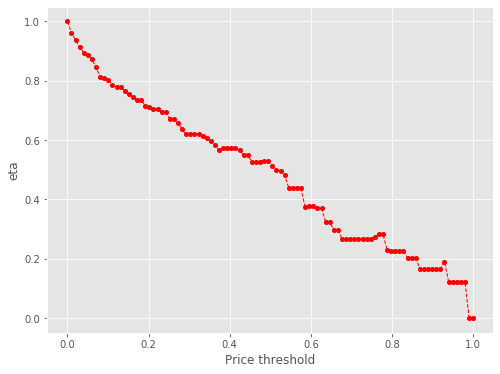

2406 202
Number of cells with price above 5.0th percentile:  202


eta =  1.0
eta =  0.9739628249871456
eta =  0.9493262545458884
eta =  0.9299877948612375
eta =  0.9207421229443861
eta =  0.906789002942578
eta =  0.8789407961276796
eta =  0.8454516081906654
eta =  0.8405283081518513
eta =  0.8333413288182824
eta =  0.8157782489237183
eta =  0.81142819492435
eta =  0.8094072569159024
eta =  0.7944410499949711
eta =  0.786891822231081
eta =  0.775175747136275
eta =  0.7631748772954942
eta =  0.7652383442897528
eta =  0.754853934934096
eta =  0.7394749691889564
eta =  0.7342578721536068
eta =  0.7345860536759377
eta =  0.7240551831122913
eta =  0.7195896282672719
eta =  0.6982122492853373
eta =  0.6982122492853373
eta =  0.6841139817812916
eta =  0.6615802775105799
eta =  0.6454077760045845
eta =  0.6467128603518484
eta =  0.6450924588784781
eta =  0.6450014665525668
eta =  0.6371286614336996
eta =  0.632725268571781
eta =  0.6278939865771896
eta =  0.6125469459693895
eta =  0.5904069936538395
eta =  0.5918080648226038
eta =  0.5950684642975043
eta =  0

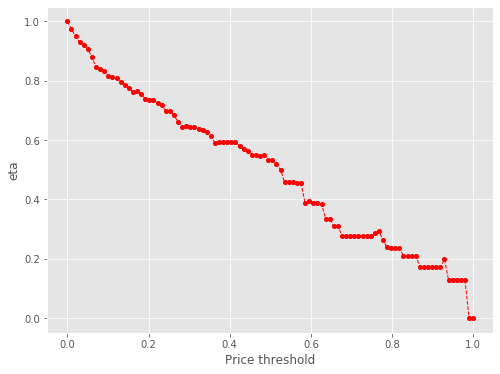

2406 191
Number of cells with price above 6.000000000000001th percentile:  191


eta =  1.0
eta =  0.974704814383873
eta =  0.9548493751530112
eta =  0.9453565365357123
eta =  0.9310304045275504
eta =  0.902437725114693
eta =  0.8707791404095945
eta =  0.862998347152464
eta =  0.8556192366266965
eta =  0.8372440401280098
eta =  0.8331202938213368
eta =  0.8310453296064816
eta =  0.815679027590664
eta =  0.8079279845629286
eta =  0.7958987009042217
eta =  0.7835770090152738
eta =  0.7856956391532216
eta =  0.7742480588589861
eta =  0.7592435257461864
eta =  0.7523363197109978
eta =  0.7520596910118222
eta =  0.74742303684474
eta =  0.7388265853748259
eta =  0.7209783326694547
eta =  0.7168777199422908
eta =  0.7168777199422908
eta =  0.6898891591145375
eta =  0.675068134284031
eta =  0.6640015858514762
eta =  0.6623378658081657
eta =  0.662244440963216
eta =  0.6541611703117195
eta =  0.6487677783085211
eta =  0.6496400605229791
eta =  0.6371309216557048
eta =  0.6061904813067498
eta =  0.6076290076373444
eta =  0.6109765681306758
eta =  0.6109765681306758
eta =  0.

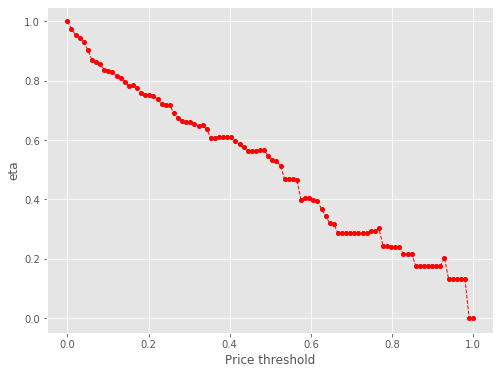

2406 177
Number of cells with price above 6.999999999999999th percentile:  177


eta =  1.0
eta =  0.9796292796158879
eta =  0.9679205149900348
eta =  0.9551921677088157
eta =  0.9258574614563064
eta =  0.8905806661747583
eta =  0.8853945670700104
eta =  0.8778239565458057
eta =  0.8589718936160643
eta =  0.854741129341775
eta =  0.852612316408634
eta =  0.8368472336994337
eta =  0.8288950384159467
eta =  0.8165535751532349
eta =  0.8039121151880078
eta =  0.8060857272464309
eta =  0.7943410635028012
eta =  0.7838152290043546
eta =  0.7710049266498815
eta =  0.7715768711855718
eta =  0.7668198882522176
eta =  0.7580003447934649
eta =  0.7396889007111317
eta =  0.7354818703706116
eta =  0.7354818703706116
eta =  0.707792912206582
eta =  0.6968945337207046
eta =  0.6779992227562665
eta =  0.6812335140369677
eta =  0.6794307683622468
eta =  0.6794307683622468
eta =  0.6711377236042746
eta =  0.6664992836150371
eta =  0.6536655121155278
eta =  0.6391925632958183
eta =  0.6200880209763369
eta =  0.6268324102994035
eta =  0.6268324102994035
eta =  0.6268324102994035
eta 

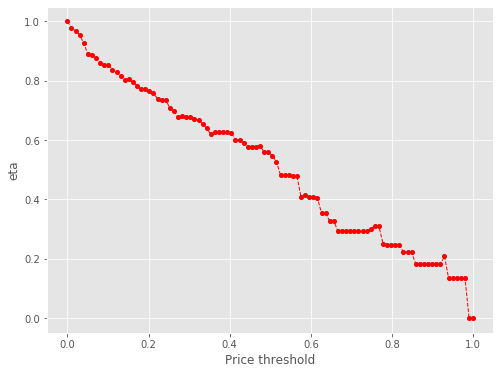

2406 169
Number of cells with price above 8.0th percentile:  169


eta =  1.0
eta =  0.9865077821848829
eta =  0.9597342324407179
eta =  0.9245898243572723
eta =  0.9063106867799385
eta =  0.904733525997719
eta =  0.8948645159995627
eta =  0.8758809030518038
eta =  0.8725148861178574
eta =  0.8703418059767905
eta =  0.854248899162713
eta =  0.8436753617376473
eta =  0.8335332478765898
eta =  0.8206289174035523
eta =  0.8228477282370498
eta =  0.811681550129082
eta =  0.7951448107975359
eta =  0.7895349554164468
eta =  0.7898878434050249
eta =  0.7785641780603442
eta =  0.7737624431669462
eta =  0.7550702251377821
eta =  0.7507757124807394
eta =  0.7507757124807394
eta =  0.7225109813827811
eta =  0.7113859785754431
eta =  0.6953992987062199
eta =  0.6953992987062199
eta =  0.6935590661690423
eta =  0.6935590661690423
eta =  0.6850935732213184
eta =  0.6803586800471819
eta =  0.6672580390531302
eta =  0.6524841351684032
eta =  0.6329823269670677
eta =  0.63986696125006
eta =  0.63986696125006
eta =  0.63986696125006
eta =  0.63986696125006
eta =  0.637

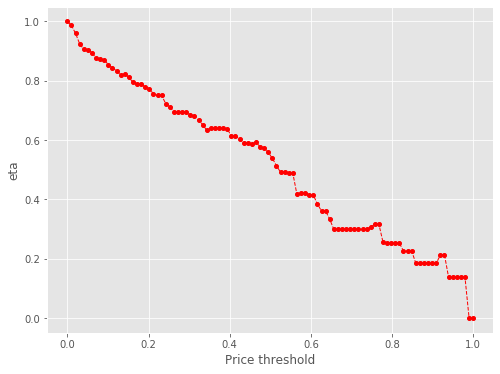

2406 161
Number of cells with price above 9.0th percentile:  161


eta =  1.0
eta =  0.9866747564754904
eta =  0.9541058956122374
eta =  0.9207646897196247
eta =  0.9154028206443069
eta =  0.9082757413748785
eta =  0.8884480187550485
eta =  0.8837104606474192
eta =  0.8815094968781585
eta =  0.8686005786896575
eta =  0.8612643486887712
eta =  0.8478213736915874
eta =  0.831158723086047
eta =  0.8334060043358648
eta =  0.8253307892520177
eta =  0.8103807027740825
eta =  0.7971362269835914
eta =  0.7977275561612207
eta =  0.793254852340404
eta =  0.7885542348722163
eta =  0.7773797663492885
eta =  0.760409204788775
eta =  0.760409204788775
eta =  0.7450550594087364
eta =  0.7205140460378369
eta =  0.7029008932720315
eta =  0.7043222349223692
eta =  0.7025574876022451
eta =  0.7024583896527908
eta =  0.6938842727047962
eta =  0.689088624292825
eta =  0.689088624292825
eta =  0.6671128106920737
eta =  0.6430006248179919
eta =  0.6445265038245305
eta =  0.6480773406575142
eta =  0.6480773406575142
eta =  0.6480773406575142
eta =  0.6480773406575142
eta =  

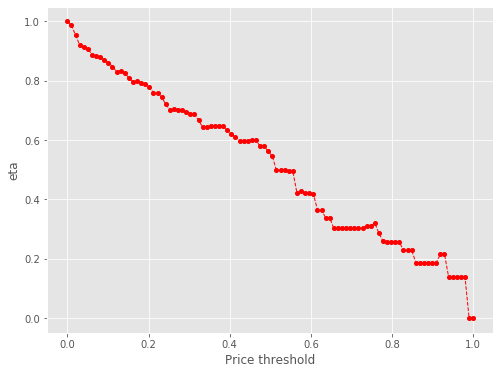

2406 155
Number of cells with price above 10.0th percentile:  155


eta =  1.0
eta =  0.9594544079524436
eta =  0.933199804369878
eta =  0.9277655221607425
eta =  0.9198326166660682
eta =  0.9000783797887195
eta =  0.8956451503878837
eta =  0.8934144621546884
eta =  0.8803312063971245
eta =  0.8728958991160382
eta =  0.8592713740038284
eta =  0.8423836909084776
eta =  0.8446613221492376
eta =  0.8364770496411493
eta =  0.8213250592007142
eta =  0.8162240037136814
eta =  0.808501029266007
eta =  0.808906926939224
eta =  0.7992038204048291
eta =  0.7966972970752494
eta =  0.7706786859583187
eta =  0.7706786859583187
eta =  0.7551171797180198
eta =  0.7302447349637193
eta =  0.7123937129828577
eta =  0.7138342501416423
eta =  0.7120456695495655
eta =  0.7119452332621223
eta =  0.7032553211186089
eta =  0.6974571603636371
eta =  0.6983949064981905
eta =  0.6849469690933606
eta =  0.6516844792045355
eta =  0.649762612018877
eta =  0.656829757125354
eta =  0.656829757125354
eta =  0.656829757125354
eta =  0.656829757125354
eta =  0.6549067791736273
eta =  0.

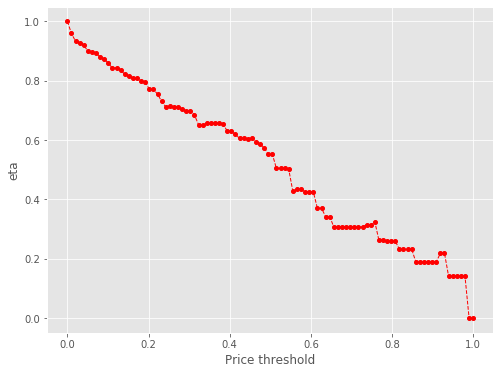

2406 145
Number of cells with price above 11.0th percentile:  145


eta =  1.0
eta =  0.9696519875602068
eta =  0.9679646003214942
eta =  0.9594433905398912
eta =  0.9384986745792319
eta =  0.933494226473216
eta =  0.9311692715668586
eta =  0.9175331303921208
eta =  0.9097836143969273
eta =  0.8955833303612474
eta =  0.8779819905212539
eta =  0.880355872200135
eta =  0.8718257404499936
eta =  0.8560334419156935
eta =  0.8507168208811215
eta =  0.842667481190082
eta =  0.8430905316965497
eta =  0.8329773814999686
eta =  0.8303649349795249
eta =  0.8032468031524413
eta =  0.8032468031524413
eta =  0.787027683086582
eta =  0.7611041534762689
eta =  0.7424987650045465
eta =  0.7440001778354686
eta =  0.7421360136008244
eta =  0.7420313329754494
eta =  0.7451715204134908
eta =  0.7269310084801939
eta =  0.7279083828366831
eta =  0.7138921489298227
eta =  0.6980857091792921
eta =  0.6772209358082215
eta =  0.680835858487383
eta =  0.6845867314603139
eta =  0.6845867314603139
eta =  0.6845867314603139
eta =  0.6845867314603139
eta =  0.6664790961712084
eta = 

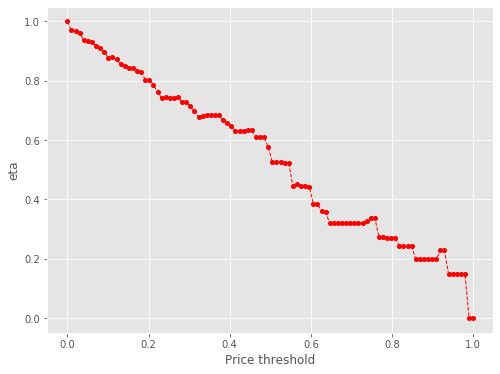

2406 137
Number of cells with price above 12.0th percentile:  137


eta =  1.0
eta =  0.9982598011860335
eta =  0.9873705883122229
eta =  0.9665540522078182
eta =  0.962710579103778
eta =  0.9603128581315276
eta =  0.9425563569131048
eta =  0.9308897865203042
eta =  0.9196992378387127
eta =  0.9054609300914149
eta =  0.9079091091384709
eta =  0.8946808793904582
eta =  0.8828254393306665
eta =  0.8683969613098809
eta =  0.8690411529092645
eta =  0.8641686075708925
eta =  0.8590477740326894
eta =  0.8530305253707117
eta =  0.8283866928108234
eta =  0.8283866928108234
eta =  0.8116599493255972
eta =  0.7849250692419285
eta =  0.7657373723048692
eta =  0.7672857761138481
eta =  0.7653632675658743
eta =  0.7652553106630701
eta =  0.7684937791840727
eta =  0.7496823786328369
eta =  0.7506903426952306
eta =  0.7362354309468131
eta =  0.7199342837792587
eta =  0.6984164880765246
eta =  0.7021445500261084
eta =  0.7060128172199587
eta =  0.7060128172199587
eta =  0.7060128172199587
eta =  0.7060128172199587
eta =  0.6873384520648198
eta =  0.6769933207337202
et

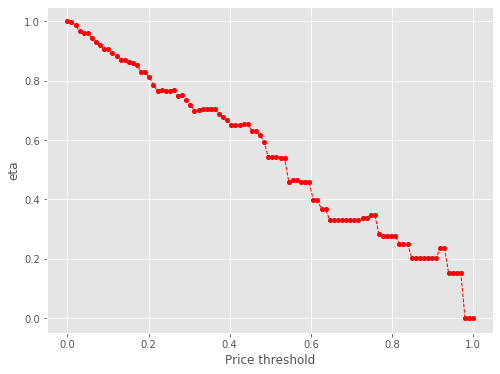

2406 134
Number of cells with price above 13.0th percentile:  134


eta =  1.0
eta =  0.9766155135732051
eta =  0.9652003173004562
eta =  0.9643888073625528
eta =  0.9583670317364941
eta =  0.9441994516790646
eta =  0.9325125437429345
eta =  0.9213024873344765
eta =  0.9070393589080076
eta =  0.9094918057000624
eta =  0.896240516073558
eta =  0.884364409226717
eta =  0.8699107790157808
eta =  0.8705560935908225
eta =  0.8656750542736199
eta =  0.8605452939325552
eta =  0.8545175558078419
eta =  0.8298307633209474
eta =  0.8298307633209474
eta =  0.8130748612347839
eta =  0.7862933760423471
eta =  0.7670722304905956
eta =  0.7686233335272391
eta =  0.7666974736001043
eta =  0.766589328503331
eta =  0.766589328503331
eta =  0.7572324375465286
eta =  0.751998970411645
eta =  0.7375188603929468
eta =  0.7280168749029828
eta =  0.7017033670137879
eta =  0.7033685511445916
eta =  0.7072435616270876
eta =  0.7072435616270876
eta =  0.7072435616270876
eta =  0.7072435616270876
eta =  0.6906680374645477
eta =  0.678173477414781
eta =  0.678173477414781
eta =  0

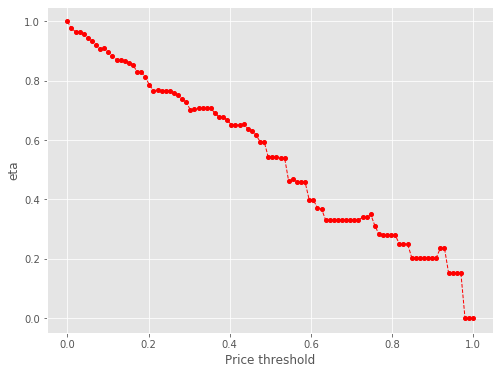

2406 129
Number of cells with price above 14.000000000000002th percentile:  129


eta =  1.0
eta =  0.9789172005417056
eta =  0.975024565750335
eta =  0.9725961756396381
eta =  0.9546125518325171
eta =  0.9427967548755275
eta =  0.9314630684015155
eta =  0.9170426391160572
eta =  0.9195221327084689
eta =  0.9061247012834306
eta =  0.8941176188362444
eta =  0.88384921900972
eta =  0.8801570182425358
eta =  0.8805988898949376
eta =  0.8700358145173392
eta =  0.8673071425428323
eta =  0.8389825488187155
eta =  0.8389825488187155
eta =  0.8389825488187155
eta =  0.807397062309189
eta =  0.7949650096258712
eta =  0.77341065622532
eta =  0.7771000931123742
eta =  0.7750436560715982
eta =  0.7750436560715982
eta =  0.7655835726775573
eta =  0.7602923882697729
eta =  0.7602923882697729
eta =  0.7360458063096758
eta =  0.7094420999962479
eta =  0.7111256486040667
eta =  0.7150433946253073
eta =  0.7150433946253073
eta =  0.7150433946253073
eta =  0.7150433946253073
eta =  0.7129499866037067
eta =  0.6961301665261594
eta =  0.6856527110970048
eta =  0.674666529167118
eta =  0

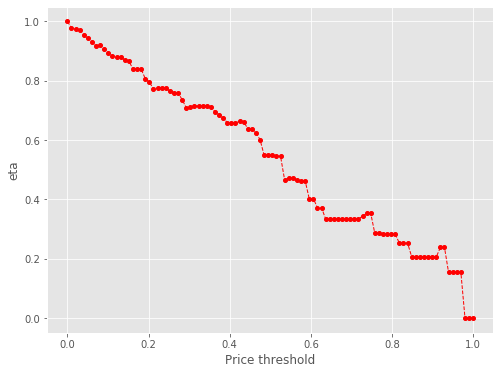

2406 120
Number of cells with price above 15.000000000000002th percentile:  120


eta =  1.0
eta =  0.9960235300909857
eta =  0.9935428400904901
eta =  0.9751719055546894
eta =  0.9631016334719728
eta =  0.9515238550166139
eta =  0.9367928550122434
eta =  0.9393257491028156
eta =  0.9302242338529398
eta =  0.9133741018560757
eta =  0.9077013515585008
eta =  0.8991128338080905
eta =  0.899564221986945
eta =  0.8887736511687461
eta =  0.8832922077972031
eta =  0.8570515957370509
eta =  0.8570515957370509
eta =  0.8570515957370509
eta =  0.8247858571311218
eta =  0.8120860571108156
eta =  0.7900674906900563
eta =  0.7938363864506094
eta =  0.7917356602199968
eta =  0.7917356602199968
eta =  0.7820718363656339
eta =  0.7715826189145093
eta =  0.7766666964775449
eta =  0.7617115972615213
eta =  0.7247212528328875
eta =  0.7225839946366066
eta =  0.7304431817416449
eta =  0.7304431817416449
eta =  0.7304431817416449
eta =  0.7304431817416449
eta =  0.7304431817416449
eta =  0.7111226221594026
eta =  0.7004195152742065
eta =  0.6891967255185385
eta =  0.6733241264366341
et

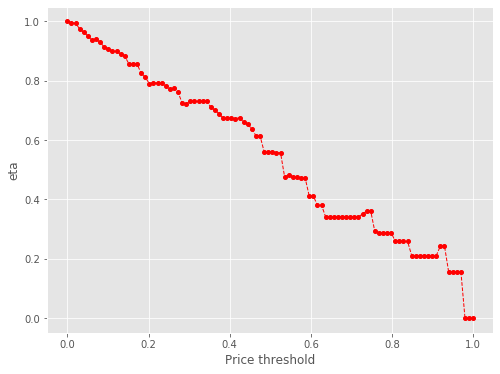

2406 118
Number of cells with price above 16.0th percentile:  118


eta =  1.0
eta =  0.9829017731139088
eta =  0.9790651285774429
eta =  0.9669466678001015
eta =  0.9553226668547612
eta =  0.9405328556110198
eta =  0.9430758618895372
eta =  0.9293352527852647
eta =  0.9170206067045825
eta =  0.9020332591735961
eta =  0.9027024027494185
eta =  0.9031555930257699
eta =  0.8923219425223393
eta =  0.8895233751114687
eta =  0.8604732416901437
eta =  0.8604732416901437
eta =  0.8604732416901437
eta =  0.8280786871127216
eta =  0.8153281851048563
eta =  0.7932217129628298
eta =  0.7970056554568478
eta =  0.795008680883489
eta =  0.7948965424016363
eta =  0.7851941372250437
eta =  0.7746630431954014
eta =  0.7797674181518556
eta =  0.7647526130150155
eta =  0.7478200607803349
eta =  0.7254687994876982
eta =  0.7293412633730068
eta =  0.7333593631818314
eta =  0.7333593631818314
eta =  0.7333593631818314
eta =  0.7333593631818314
eta =  0.7161717682657609
eta =  0.7032158318691768
eta =  0.7032158318691768
eta =  0.6919482368610118
eta =  0.6760122688819677
et

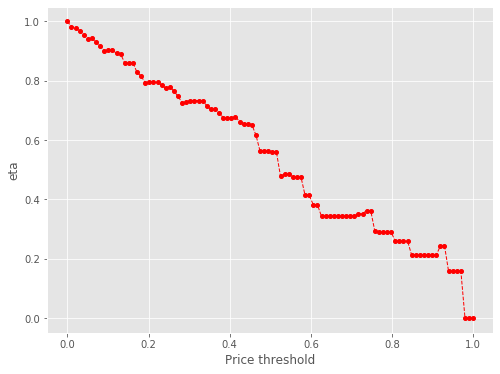

2406 112
Number of cells with price above 17.0th percentile:  112


eta =  1.0
eta =  0.9915539660220426
eta =  0.9760773760599873
eta =  0.9568940471348821
eta =  0.9568940471348821
eta =  0.9564898145118637
eta =  0.9464609728172491
eta =  0.9271783140054634
eta =  0.9187433238751221
eta =  0.9184055085073125
eta =  0.9132561867931086
eta =  0.9078444733041781
eta =  0.901485425405562
eta =  0.8754417432416446
eta =  0.8754417432416446
eta =  0.8660813856617445
eta =  0.8424836639467078
eta =  0.8295113585173761
eta =  0.8070203296610627
eta =  0.810870096339202
eta =  0.8087242938664589
eta =  0.8087242938664589
eta =  0.7988531089301915
eta =  0.7914335227424981
eta =  0.7933319884870002
eta =  0.778055990877115
eta =  0.7402719277346116
eta =  0.7380888094131288
eta =  0.742028637370749
eta =  0.7461166346851651
eta =  0.7461166346851651
eta =  0.7461166346851651
eta =  0.7461166346851651
eta =  0.7286300501797585
eta =  0.7154487366945474
eta =  0.7154487366945474
eta =  0.7039851344136518
eta =  0.6877719497242422
eta =  0.6877719497242422
eta =

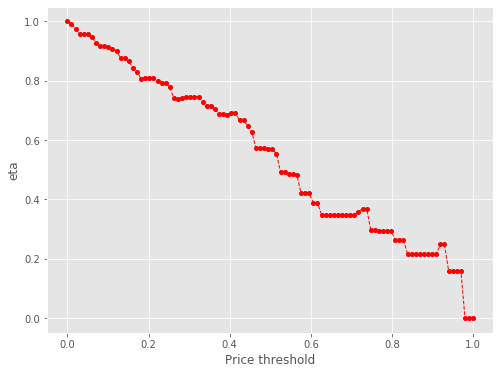

2406 111
Number of cells with price above 18.000000000000004th percentile:  111


eta =  1.0
eta =  0.9840262231461961
eta =  0.9757498648152458
eta =  0.9606438102617245
eta =  0.9632411924013705
eta =  0.9492067745641862
eta =  0.9366288104214177
eta =  0.921320995758707
eta =  0.9220044473047697
eta =  0.9224673279274407
eta =  0.9114020267669637
eta =  0.9085436189560995
eta =  0.8788723207212884
eta =  0.8788723207212884
eta =  0.8788723207212884
eta =  0.8457850892063731
eta =  0.8327619494420231
eta =  0.8101827854040324
eta =  0.8140476380921431
eta =  0.8120079631868993
eta =  0.8118934269026629
eta =  0.8019835599352938
eta =  0.7953714100322501
eta =  0.7964408039788304
eta =  0.7811049445976919
eta =  0.7710414082621574
eta =  0.7431728177409473
eta =  0.7449364113628696
eta =  0.7490404282372759
eta =  0.7490404282372759
eta =  0.7490404282372759
eta =  0.7490404282372759
eta =  0.7468474882664132
eta =  0.7292279628943038
eta =  0.7182523525180923
eta =  0.7067438280294952
eta =  0.6904671090310373
eta =  0.6904671090310373
eta =  0.6887537746974701
et

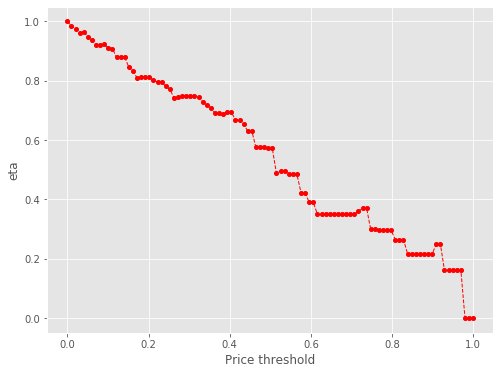

2406 105
Number of cells with price above 19.0th percentile:  105


eta =  1.0
eta =  0.980346507976099
eta =  0.9829971621345719
eta =  0.9799323680391093
eta =  0.9558389631597979
eta =  0.9499024736625812
eta =  0.9412607508471321
eta =  0.9409146559820167
eta =  0.9356391298398276
eta =  0.9300947809780853
eta =  0.9235798795424175
eta =  0.8968978942790721
eta =  0.8968978942790721
eta =  0.8873081242367791
eta =  0.8631320473254478
eta =  0.8498418044128464
eta =  0.8267995442314865
eta =  0.8307436646184164
eta =  0.8286621562077001
eta =  0.8285452707970118
eta =  0.8184321535602275
eta =  0.8116843891980158
eta =  0.8127757162955122
eta =  0.7971253201439816
eta =  0.7868553817973807
eta =  0.7584152095838724
eta =  0.7602149743148495
eta =  0.7644031641189383
eta =  0.7644031641189383
eta =  0.7644031641189383
eta =  0.7644031641189383
eta =  0.7621652471931522
eta =  0.7441843473151446
eta =  0.7329836283907248
eta =  0.7212390653447404
eta =  0.7046285126497731
eta =  0.7046285126497731
eta =  0.7046285126497731
eta =  0.7028800380195661
et

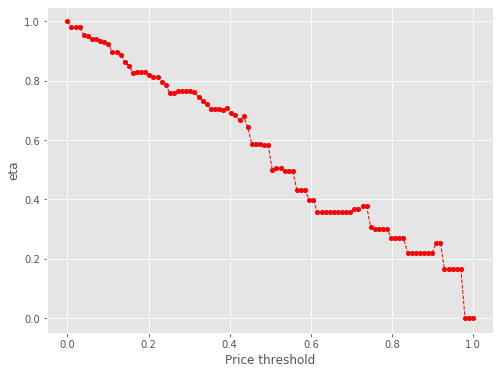

2406 102
Number of cells with price above 20.0th percentile:  102


eta =  1.0
eta =  0.9995775575945646
eta =  0.9750011402938576
eta =  0.9689456390512688
eta =  0.9601306713381798
eta =  0.959777638137878
eta =  0.9543963509100789
eta =  0.9487408517405166
eta =  0.9457653390891776
eta =  0.9148784506109942
eta =  0.9148784506109942
eta =  0.9148784506109942
eta =  0.8804356829988229
eta =  0.8668790040037209
eta =  0.8456879218715275
eta =  0.8473979943412724
eta =  0.845274756900448
eta =  0.8451555282300367
eta =  0.8451555282300367
eta =  0.8348396683228467
eta =  0.8290698336585779
eta =  0.813105686263551
eta =  0.8026298613760802
eta =  0.773619534943417
eta =  0.7713380719872835
eta =  0.7797275329689597
eta =  0.7797275329689597
eta =  0.7797275329689597
eta =  0.7797275329689597
eta =  0.7797275329689597
eta =  0.7614532166454705
eta =  0.747678114245494
eta =  0.747678114245494
eta =  0.7356981021268902
eta =  0.7187545494546221
eta =  0.7187545494546221
eta =  0.7169710222874608
eta =  0.7235345334150945
eta =  0.7217281415211919
eta =  

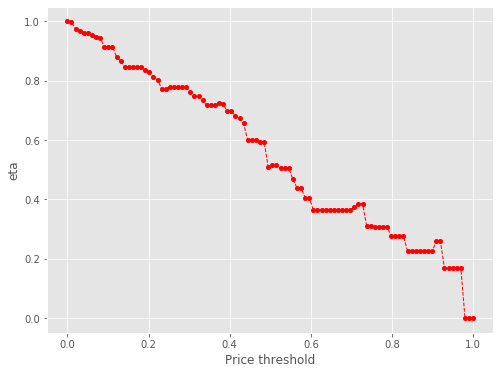

2406 100
Number of cells with price above 21.000000000000004th percentile:  100


eta =  1.0
eta =  0.9864298366213015
eta =  0.9723720474270748
eta =  0.9564800623422717
eta =  0.9571895954804455
eta =  0.9576701403598822
eta =  0.9461825698035492
eta =  0.9403470613265608
eta =  0.9176305642302971
eta =  0.9124114787182744
eta =  0.9124114787182744
eta =  0.8939881108757615
eta =  0.8645414627316121
eta =  0.8434075224022032
eta =  0.8451129836575134
eta =  0.8451129836575134
eta =  0.8428765643614181
eta =  0.8428765643614181
eta =  0.8325885211947178
eta =  0.8214217694463034
eta =  0.8268342449031847
eta =  0.810913144869136
eta =  0.7929585423615979
eta =  0.7692581570629496
eta =  0.7733643631931222
eta =  0.7776249958433673
eta =  0.7776249958433673
eta =  0.7776249958433673
eta =  0.7776249958433673
eta =  0.7691458433800685
eta =  0.7570564554826925
eta =  0.7456619984528294
eta =  0.7337142904650655
eta =  0.716816426122408
eta =  0.716816426122408
eta =  0.716816426122408
eta =  0.7150377082404457
eta =  0.7197819998909802
eta =  0.7197819998909802
eta =

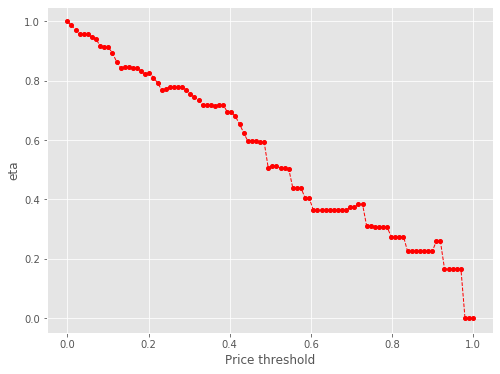

2406 96
Number of cells with price above 22.0th percentile:  96


eta =  1.0
eta =  0.9867489734799422
eta =  0.9706220187711128
eta =  0.9713420426525022
eta =  0.9718296925882957
eta =  0.9601722735127128
eta =  0.9542504846103702
eta =  0.9311981146352045
eta =  0.9259018627683195
eta =  0.9259018627683195
eta =  0.907206097752505
eta =  0.8773240686407585
eta =  0.8719016167491371
eta =  0.8576083314048203
eta =  0.8576083314048203
eta =  0.8553388457171847
eta =  0.8553388457171847
eta =  0.8448986895437112
eta =  0.8379327153426952
eta =  0.8390593338785473
eta =  0.8229028337438113
eta =  0.8123007851647175
eta =  0.7829409119863939
eta =  0.7847988776785709
eta =  0.7891225055585874
eta =  0.7891225055585874
eta =  0.7891225055585874
eta =  0.7891225055585874
eta =  0.7891225055585874
eta =  0.7706280011646582
eta =  0.7566869219279087
eta =  0.7566869219279087
eta =  0.7445625620971635
eta =  0.7274148557863536
eta =  0.7274148557863536
eta =  0.7256098388190507
eta =  0.7322524339914674
eta =  0.7304242767992885
eta =  0.7051192839242338
et

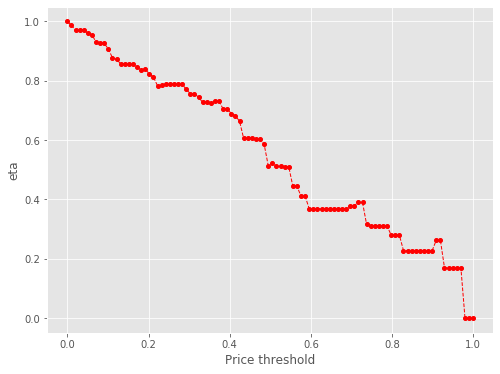

2406 94
Number of cells with price above 23.0th percentile:  94


eta =  1.0
eta =  0.9836564768322434
eta =  0.9843861698957692
eta =  0.9848803684699756
eta =  0.9730664022142308
eta =  0.9670650897614209
eta =  0.9437031501042986
eta =  0.9383357750076652
eta =  0.9383357750076652
eta =  0.9193889450455516
eta =  0.8891056309354165
eta =  0.8891056309354165
eta =  0.864998787555453
eta =  0.8691251315725367
eta =  0.8668251690201239
eta =  0.8668251690201239
eta =  0.8562448122586119
eta =  0.8491852921696786
eta =  0.850327040036797
eta =  0.8339535746783714
eta =  0.8232091514622987
eta =  0.7934550053041518
eta =  0.7953379215696987
eta =  0.7997196113370247
eta =  0.7997196113370247
eta =  0.7997196113370247
eta =  0.7997196113370247
eta =  0.7997196113370247
eta =  0.7809767447204979
eta =  0.7668484510901697
eta =  0.7668484510901697
eta =  0.7545612735439023
eta =  0.7371832911272239
eta =  0.7371832911272239
eta =  0.7353540346336123
eta =  0.7353540346336123
eta =  0.7402331255773391
eta =  0.722385447961353
eta =  0.7145883126054926
eta 

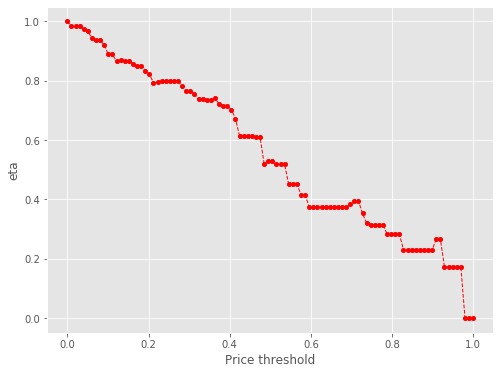

2406 90
Number of cells with price above 24.000000000000004th percentile:  90


eta =  1.0
eta =  1.0007418169663007
eta =  1.0012442266853907
eta =  0.9892339705299183
eta =  0.9831329458387207
eta =  0.9593828458725651
eta =  0.9539262914523486
eta =  0.9539262914523486
eta =  0.9346646585465911
eta =  0.9038781849926739
eta =  0.8982916108301728
eta =  0.8835657081946512
eta =  0.8835657081946512
eta =  0.881227531598875
eta =  0.881227531598875
eta =  0.8704713814481793
eta =  0.8632945669248127
eta =  0.8644552850149281
eta =  0.8478097733509836
eta =  0.8368868307697749
eta =  0.8066383173314586
eta =  0.8085525183862929
eta =  0.8130070102445042
eta =  0.8130070102445042
eta =  0.8130070102445042
eta =  0.8130070102445042
eta =  0.8130070102445042
eta =  0.8066644836560702
eta =  0.7795896933040283
eta =  0.7795896933040283
eta =  0.7670983634183788
eta =  0.7494316445729517
eta =  0.7494316445729517
eta =  0.7494316445729517
eta =  0.747571994851026
eta =  0.7525321522419877
eta =  0.7525321522419877
eta =  0.7264612488566587
eta =  0.7264612488566587
eta 

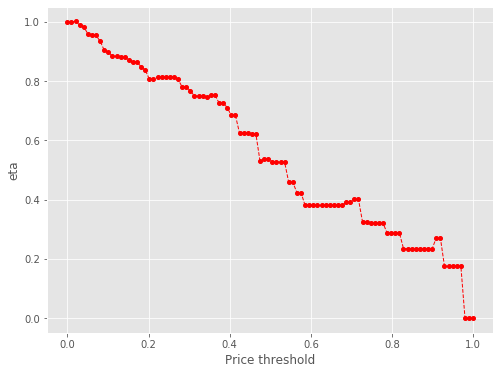

2406 87
Number of cells with price above 25.0th percentile:  87


eta =  1.0
eta =  0.9938347258568744
eta =  0.9885006839513634
eta =  0.9854004735139625
eta =  0.9532191772940288
eta =  0.9532191772940288
eta =  0.9532191772940288
eta =  0.9200954237526701
eta =  0.9032081698481792
eta =  0.8811290118326754
eta =  0.8829107500205567
eta =  0.8829107500205567
eta =  0.8805743066381224
eta =  0.8805743066381224
eta =  0.8698261296674603
eta =  0.8626546350804521
eta =  0.8638144927684561
eta =  0.8471813198743678
eta =  0.8362664741109309
eta =  0.8060403828999001
eta =  0.8079531650205044
eta =  0.8124043549105351
eta =  0.8124043549105351
eta =  0.8124043549105351
eta =  0.8124043549105351
eta =  0.8124043549105351
eta =  0.8060665298282765
eta =  0.7790118091270692
eta =  0.7790118091270692
eta =  0.766529738653072
eta =  0.7488761155647685
eta =  0.7488761155647685
eta =  0.7488761155647685
eta =  0.7470178443399652
eta =  0.7519743249295325
eta =  0.7519743249295325
eta =  0.7259227470466759
eta =  0.7259227470466759
eta =  0.7098852372549925
et

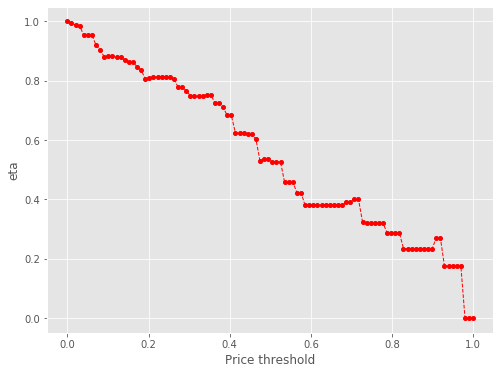

2406 81
Number of cells with price above 26.0th percentile:  81


eta =  1.0
eta =  0.9858291693471932
eta =  0.9643080604493841
eta =  0.9643080604493841
eta =  0.9643080604493841
eta =  0.9280043980225116
eta =  0.9137152705223816
eta =  0.8913792637052228
eta =  0.8931817290113256
eta =  0.8931817290113256
eta =  0.8908181055759884
eta =  0.8908181055759884
eta =  0.8799448941102178
eta =  0.8726899728912042
eta =  0.8738633233064691
eta =  0.8570366552382186
eta =  0.845994836106838
eta =  0.815417122098379
eta =  0.8130123948728697
eta =  0.8173521557828863
eta =  0.8218551267593329
eta =  0.8218551267593329
eta =  0.8218551267593329
eta =  0.8218551267593329
eta =  0.8128936929579692
eta =  0.8001166790040067
eta =  0.7880741225318145
eta =  0.775446847025942
eta =  0.775446847025942
eta =  0.7575878577759436
eta =  0.7575878577759436
eta =  0.7557079691173186
eta =  0.762626097619525
eta =  0.760722108884784
eta =  0.7423804236972434
eta =  0.7343674706879546
eta =  0.7343674706879546
eta =  0.7127182113319345
eta =  0.6913261647779988
eta =  

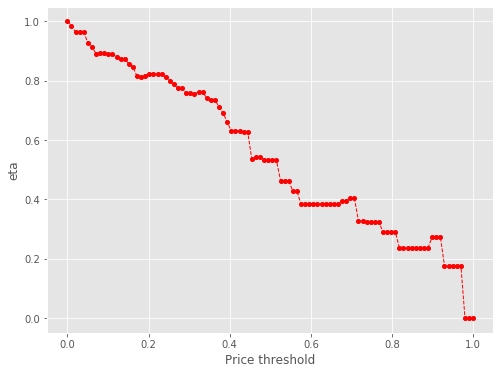

2406 80
Number of cells with price above 27.0th percentile:  80


eta =  1.0
eta =  0.9758424330435859
eta =  0.9702922636150134
eta =  0.9702922636150134
eta =  0.9507001698017751
eta =  0.9183981786335902
eta =  0.9193855101881122
eta =  0.894457670650537
eta =  0.8987245437501561
eta =  0.8964727026872544
eta =  0.8963462523851145
eta =  0.8963462523851145
eta =  0.8854055650688945
eta =  0.8792862538824314
eta =  0.8792862538824314
eta =  0.862355164618869
eta =  0.8499408199375618
eta =  0.8204773532874614
eta =  0.822424395203752
eta =  0.8269553102514733
eta =  0.8269553102514733
eta =  0.8269553102514733
eta =  0.8269553102514733
eta =  0.8269553102514733
eta =  0.8075741260737354
eta =  0.7929646713639042
eta =  0.7929646713639042
eta =  0.7802590348184898
eta =  0.7622892181012244
eta =  0.7622892181012244
eta =  0.7622892181012244
eta =  0.7603976634241106
eta =  0.7673587237322214
eta =  0.7654429194212334
eta =  0.7389247323381145
eta =  0.7389247323381145
eta =  0.7225999750848092
eta =  0.7366562239110984
eta =  0.6956163251462726
eta 

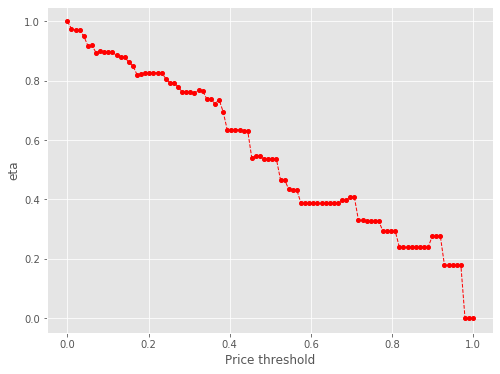

2406 75
Number of cells with price above 28.000000000000004th percentile:  75


eta =  1.0
eta =  0.9623526299158441
eta =  0.94753461886088
eta =  0.924371889300422
eta =  0.9262410692648236
eta =  0.9262410692648236
eta =  0.9237899610222609
eta =  0.9237899610222609
eta =  0.9125142993206429
eta =  0.9125142993206429
eta =  0.9062076313032517
eta =  0.9062076313032517
eta =  0.888758157677148
eta =  0.8690799719831669
eta =  0.8431044271205116
eta =  0.8476048156249842
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8456255906606023
eta =  0.8297314020491944
eta =  0.8172431143679941
eta =  0.8041484654443005
eta =  0.8041484654443005
eta =  0.7856284613268656
eta =  0.7856284613268656
eta =  0.7836789923389686
eta =  0.7908531815695165
eta =  0.7888787204892537
eta =  0.7698581544068827
eta =  0.761548617923744
eta =  0.761548617923744
eta =  0.7447240405613684
eta =  0.7169142239211699
eta =  0.7169142239211699
eta =  0.6544305156226506
eta =  0.6544305156226506
eta =  

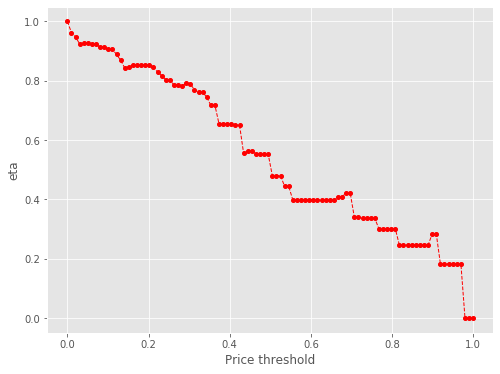

2406 75
Number of cells with price above 29.000000000000004th percentile:  75


eta =  1.0
eta =  0.9623526299158441
eta =  0.94753461886088
eta =  0.924371889300422
eta =  0.9262410692648236
eta =  0.9262410692648236
eta =  0.9237899610222609
eta =  0.9237899610222609
eta =  0.9125142993206429
eta =  0.9125142993206429
eta =  0.9062076313032517
eta =  0.9062076313032517
eta =  0.888758157677148
eta =  0.8690799719831669
eta =  0.8431044271205116
eta =  0.8476048156249842
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8522744550909741
eta =  0.8456255906606023
eta =  0.8297314020491944
eta =  0.8172431143679941
eta =  0.8041484654443005
eta =  0.8041484654443005
eta =  0.7856284613268656
eta =  0.7856284613268656
eta =  0.7836789923389686
eta =  0.7908531815695165
eta =  0.7888787204892537
eta =  0.7698581544068827
eta =  0.761548617923744
eta =  0.761548617923744
eta =  0.7447240405613684
eta =  0.7169142239211699
eta =  0.7169142239211699
eta =  0.6544305156226506
eta =  0.6544305156226506
eta =  

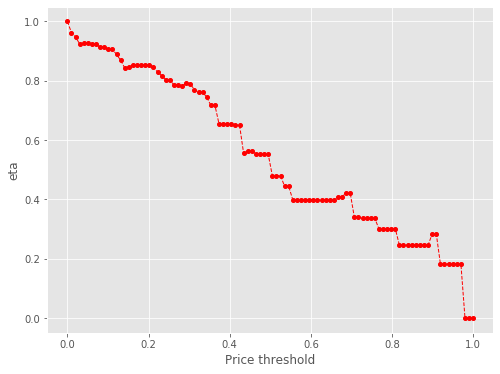

2406 73
Number of cells with price above 30.0th percentile:  73


eta =  1.0
eta =  0.96706147678485
eta =  0.9610843874497421
eta =  0.9408409707521512
eta =  0.9453291082692705
eta =  0.9429604949730606
eta =  0.9428274874211986
eta =  0.9428274874211986
eta =  0.9313194561157018
eta =  0.9248828198545145
eta =  0.9248828198545145
eta =  0.9070737462881422
eta =  0.8953872633540447
eta =  0.8630243049799121
eta =  0.8650723133616679
eta =  0.8698381850756343
eta =  0.8698381850756343
eta =  0.8698381850756343
eta =  0.8698381850756343
eta =  0.8698381850756343
eta =  0.8698381850756343
eta =  0.8468305632622686
eta =  0.834084916098459
eta =  0.834084916098459
eta =  0.8207204117583959
eta =  0.801818746135456
eta =  0.801818746135456
eta =  0.801818746135456
eta =  0.7998291023579566
eta =  0.8071511377685131
eta =  0.8051359868599071
eta =  0.777242663680373
eta =  0.777242663680373
eta =  0.7600713642824681
eta =  0.7734780308568532
eta =  0.73168844104794
eta =  0.6989799578955304
eta =  0.6679170642355516
eta =  0.6679170642355516
eta =  0.667

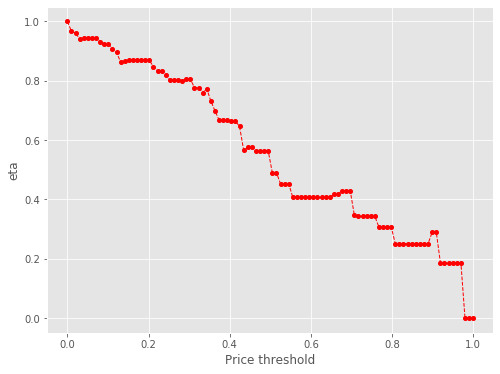

2406 68
Number of cells with price above 31.0th percentile:  68


eta =  1.0
eta =  0.9728864124338061
eta =  0.9775274178143957
eta =  0.9750781285467838
eta =  0.974940590701409
eta =  0.974940590701409
eta =  0.9630405909787884
eta =  0.9501242043972451
eta =  0.9563847201621916
eta =  0.9379690620123278
eta =  0.9258845325231053
eta =  0.8924192780888904
eta =  0.889787465638022
eta =  0.8945370425029634
eta =  0.8994652418246976
eta =  0.8994652418246976
eta =  0.8994652418246976
eta =  0.8994652418246976
eta =  0.8994652418246976
eta =  0.8783846570613241
eta =  0.8624942013733266
eta =  0.8624942013733266
eta =  0.8486744963588165
eta =  0.8486744963588165
eta =  0.8291290320044907
eta =  0.8291290320044907
eta =  0.8270716201177984
eta =  0.8270716201177984
eta =  0.8325592593520631
eta =  0.8124855167111479
eta =  0.8037158777789806
eta =  0.8037158777789806
eta =  0.7859597166557047
eta =  0.7771147496402354
eta =  0.7566100590425282
eta =  0.6906666021442074
eta =  0.6906666021442074
eta =  0.6906666021442074
eta =  0.6906666021442074
eta 

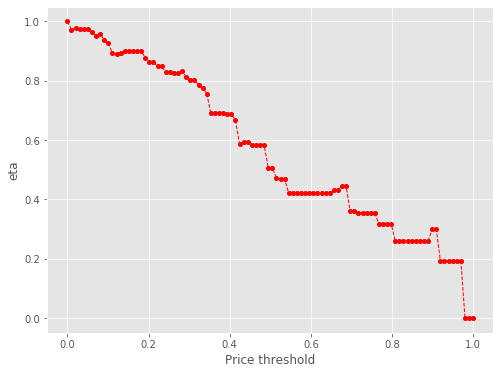

2406 66
Number of cells with price above 32.0th percentile:  66


eta =  1.0
eta =  1.0020221081861502
eta =  0.9995114451083028
eta =  0.9993704608665657
eta =  0.9993704608665657
eta =  0.9871722732841289
eta =  0.9790332896725326
eta =  0.9803496209616268
eta =  0.9803496209616268
eta =  0.9614725068606025
eta =  0.9401843371079784
eta =  0.9147813453825596
eta =  0.9169521763220901
eta =  0.9220038654961562
eta =  0.9220038654961562
eta =  0.9220038654961562
eta =  0.9220038654961562
eta =  0.9220038654961562
eta =  0.911950418926047
eta =  0.8976164373379496
eta =  0.8841064119620681
eta =  0.8841064119620681
eta =  0.8699404154889345
eta =  0.849905184721098
eta =  0.849905184721098
eta =  0.849905184721098
eta =  0.8477962186107457
eta =  0.8555573689806227
eta =  0.853421366032981
eta =  0.823855232659763
eta =  0.823855232659763
eta =  0.823855232659763
eta =  0.8056541411325114
eta =  0.7755690455534524
eta =  0.7755690455534524
eta =  0.7079731904417096
eta =  0.7079731904417096
eta =  0.7079731904417096
eta =  0.7079731904417096
eta =  0.

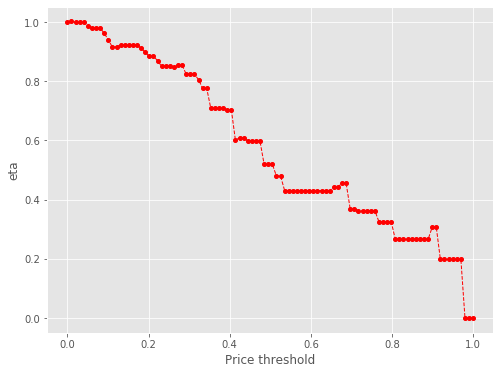

2406 64
Number of cells with price above 33.0th percentile:  64


eta =  1.0
eta =  0.9973537037776696
eta =  0.9973537037776696
eta =  0.9851801324734218
eta =  0.9851801324734218
eta =  0.97837124845104
eta =  0.97837124845104
eta =  0.9595322288856977
eta =  0.9471698856214632
eta =  0.9129352914562804
eta =  0.915101741599242
eta =  0.9201432363255515
eta =  0.9201432363255515
eta =  0.9201432363255515
eta =  0.9201432363255515
eta =  0.9201432363255515
eta =  0.9201432363255515
eta =  0.8985780255916096
eta =  0.8823222608954887
eta =  0.8823222608954887
eta =  0.8681848517930322
eta =  0.8481900526721784
eta =  0.8481900526721784
eta =  0.8481900526721784
eta =  0.8460853425134676
eta =  0.8460853425134676
eta =  0.8516991382334221
eta =  0.8516991382334221
eta =  0.8221926701308987
eta =  0.8221926701308987
eta =  0.8040283089071737
eta =  0.8182103185978837
eta =  0.7740039258788205
eta =  0.7065444810626735
eta =  0.7065444810626735
eta =  0.7065444810626735
eta =  0.7065444810626735
eta =  0.7022458450260166
eta =  0.7022458450260166
eta = 

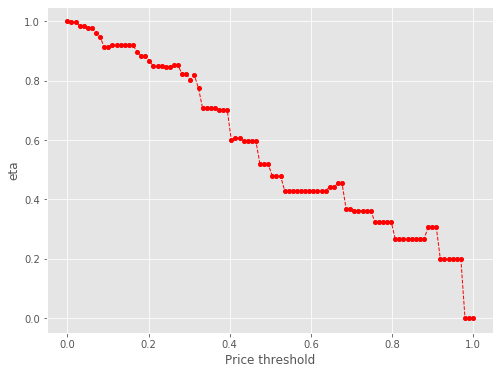

2406 62
Number of cells with price above 34.0th percentile:  62


eta =  1.0
eta =  0.987794128343698
eta =  0.9809671781889113
eta =  0.9809671781889113
eta =  0.9620781727197525
eta =  0.9496830282314834
eta =  0.9153575988120982
eta =  0.912658139505583
eta =  0.917529797235542
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9125248890539392
eta =  0.8981818779790789
eta =  0.88466334215587
eta =  0.88466334215587
eta =  0.8704884220157949
eta =  0.8504405703407877
eta =  0.8504405703407877
eta =  0.8504405703407877
eta =  0.848330275717387
eta =  0.8560963151129752
eta =  0.8539589666208159
eta =  0.8333692580453699
eta =  0.8243742084845981
eta =  0.8243742084845981
eta =  0.8061616514399669
eta =  0.8203812905078252
eta =  0.7760576041850862
eta =  0.7413656975650607
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.7041091263471775
eta =  0.7041091263471775
eta =  0.6008849734190165
eta =  0.60990823

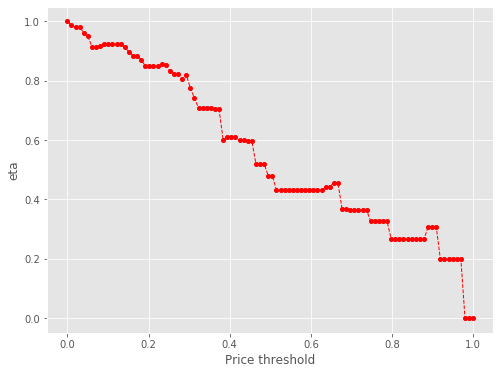

2406 62
Number of cells with price above 35.0th percentile:  62


eta =  1.0
eta =  0.987794128343698
eta =  0.9809671781889113
eta =  0.9809671781889113
eta =  0.9620781727197525
eta =  0.9496830282314834
eta =  0.9153575988120982
eta =  0.912658139505583
eta =  0.917529797235542
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9225846686489773
eta =  0.9125248890539392
eta =  0.8981818779790789
eta =  0.88466334215587
eta =  0.88466334215587
eta =  0.8704884220157949
eta =  0.8504405703407877
eta =  0.8504405703407877
eta =  0.8504405703407877
eta =  0.848330275717387
eta =  0.8560963151129752
eta =  0.8539589666208159
eta =  0.8333692580453699
eta =  0.8243742084845981
eta =  0.8243742084845981
eta =  0.8061616514399669
eta =  0.8203812905078252
eta =  0.7760576041850862
eta =  0.7413656975650607
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.70841916803086
eta =  0.7041091263471775
eta =  0.7041091263471775
eta =  0.6008849734190165
eta =  0.60990823

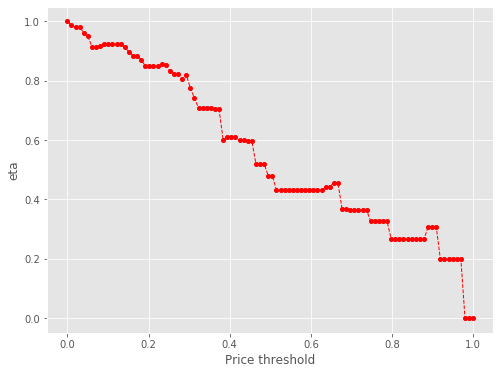

2406 59
Number of cells with price above 36.00000000000001th percentile:  59


eta =  1.0
eta =  0.9930886912982224
eta =  0.9930886912982224
eta =  0.9739662801326171
eta =  0.961417972613263
eta =  0.9266683943008863
eta =  0.9288674339196843
eta =  0.9288674339196843
eta =  0.9339847668419917
eta =  0.9339847668419917
eta =  0.9339847668419917
eta =  0.9339847668419917
eta =  0.9339847668419917
eta =  0.9312503716742909
eta =  0.9092804383086605
eta =  0.8955948580492633
eta =  0.8955948580492633
eta =  0.8812447827316027
eta =  0.8609492058499878
eta =  0.8609492058499878
eta =  0.8609492058499878
eta =  0.8588128349576651
eta =  0.8666748369404165
eta =  0.864511077882906
eta =  0.843666948539912
eta =  0.8345607498871073
eta =  0.8345607498871073
eta =  0.816123145813504
eta =  0.8305184926371395
eta =  0.7856471120013186
eta =  0.7505265280409787
eta =  0.7171728882603452
eta =  0.7171728882603452
eta =  0.7171728882603452
eta =  0.7171728882603452
eta =  0.7128095887022586
eta =  0.7128095887022586
eta =  0.6083099263067715
eta =  0.6083099263067715
eta =

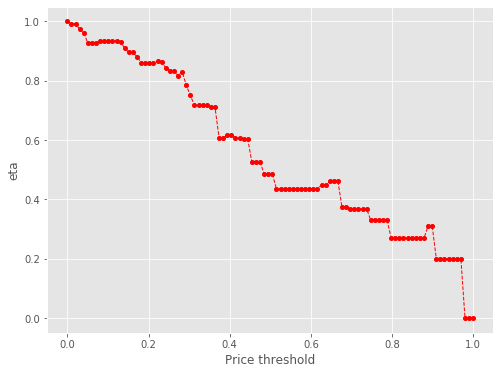

2406 55
Number of cells with price above 37.0th percentile:  55


eta =  1.0
eta =  0.9807445081862655
eta =  0.966625847026157
eta =  0.9331174571019356
eta =  0.9353318007331405
eta =  0.9353318007331405
eta =  0.9404847472596163
eta =  0.9404847472596163
eta =  0.9404847472596163
eta =  0.9404847472596163
eta =  0.9404847472596163
eta =  0.9377313223221856
eta =  0.9156084912416
eta =  0.9018276674548478
eta =  0.9018276674548478
eta =  0.8873777241180634
eta =  0.8669409020502546
eta =  0.8669409020502546
eta =  0.8669409020502546
eta =  0.8647896632827182
eta =  0.8647896632827182
eta =  0.8705275626014507
eta =  0.8705275626014507
eta =  0.840368798073938
eta =  0.840368798073938
eta =  0.840368798073938
eta =  0.8218028792036903
eta =  0.7911147502588876
eta =  0.7911147502588876
eta =  0.7221639865043834
eta =  0.7221639865043834
eta =  0.7221639865043834
eta =  0.7221639865043834
eta =  0.7177703209674386
eta =  0.7177703209674386
eta =  0.7177703209674386
eta =  0.6125434028571546
eta =  0.6217417352236261
eta =  0.6217417352236261
eta =  0

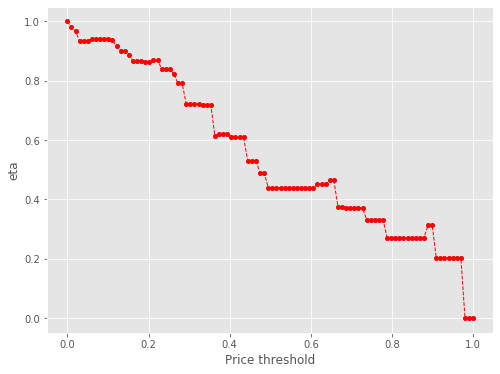

2406 53
Number of cells with price above 38.0th percentile:  53


eta =  1.0
eta =  0.9778587847278815
eta =  0.9514378610465953
eta =  0.9536956800939842
eta =  0.9589497972299601
eta =  0.9589497972299601
eta =  0.9589497972299601
eta =  0.9589497972299601
eta =  0.9589497972299601
eta =  0.9589497972299601
eta =  0.9561423127990529
eta =  0.9335851321103756
eta =  0.9195337418943471
eta =  0.9195337418943471
eta =  0.9048000949392321
eta =  0.8839620255978053
eta =  0.8839620255978053
eta =  0.8839620255978053
eta =  0.8817685503862901
eta =  0.8817685503862901
eta =  0.8876191050117181
eta =  0.8876191050117181
eta =  0.8568682170120632
eta =  0.8568682170120632
eta =  0.8568682170120632
eta =  0.8379377833310401
eta =  0.8066471376137822
eta =  0.8066471376137822
eta =  0.7363426259096912
eta =  0.7363426259096912
eta =  0.7363426259096912
eta =  0.7363426259096912
eta =  0.7318626971410152
eta =  0.7318626971410152
eta =  0.7318626971410152
eta =  0.6245698015581636
eta =  0.6339487298006294
eta =  0.6339487298006294
eta =  0.6339487298006294
e

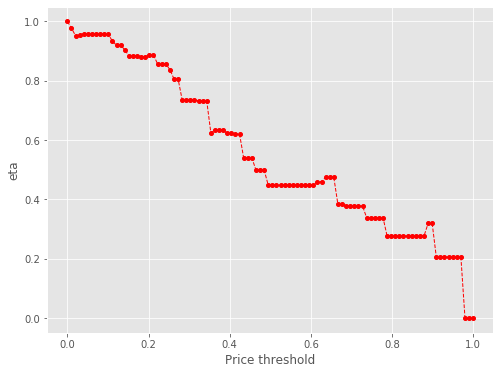

2406 50
Number of cells with price above 39.0th percentile:  50


eta =  1.0
eta =  0.9729808392643948
eta =  0.9752897810897906
eta =  0.980662864829523
eta =  0.980662864829523
eta =  0.980662864829523
eta =  0.980662864829523
eta =  0.980662864829523
eta =  0.980662864829523
eta =  0.9777918117953281
eta =  0.9547238790416692
eta =  0.9403543295366875
eta =  0.9403543295366875
eta =  0.9252870752610969
eta =  0.9039771789172957
eta =  0.9039771789172957
eta =  0.9039771789172957
eta =  0.9017340378362184
eta =  0.9017340378362184
eta =  0.9099889619649807
eta =  0.907717063930376
eta =  0.8858311999183821
eta =  0.876269897447935
eta =  0.876269897447935
eta =  0.8569108304981086
eta =  0.847267399835778
eta =  0.824911684807593
eta =  0.7530152997649866
eta =  0.7530152997649866
eta =  0.7530152997649866
eta =  0.7530152997649866
eta =  0.7530152997649866
eta =  0.7484339339904563
eta =  0.7484339339904563
eta =  0.693833579698071
eta =  0.6387116537813472
eta =  0.648302944864421
eta =  0.648302944864421
eta =  0.6362960899432325
eta =  0.636296

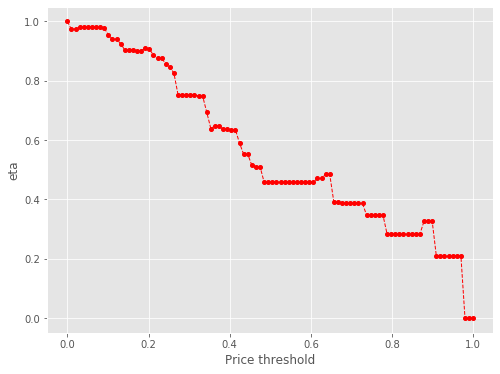

2406 48
Number of cells with price above 40.0th percentile:  48


eta =  1.0
eta =  1.0053378779184483
eta =  1.0108765031655464
eta =  1.0108765031655464
eta =  1.0108765031655464
eta =  1.0108765031655464
eta =  1.0108765031655464
eta =  1.0108765031655464
eta =  0.9871847952268897
eta =  0.9693260859264579
eta =  0.9693260859264579
eta =  0.9537946185275542
eta =  0.9537946185275542
eta =  0.9318281769792788
eta =  0.9318281769792788
eta =  0.9318281769792788
eta =  0.9295159260585298
eta =  0.9380251794793073
eta =  0.9356832856204336
eta =  0.9356832856204336
eta =  0.9032672506829214
eta =  0.9032672506829214
eta =  0.9032672506829214
eta =  0.8833117424194465
eta =  0.8503267221234692
eta =  0.8503267221234692
eta =  0.776215252311927
eta =  0.776215252311927
eta =  0.776215252311927
eta =  0.776215252311927
eta =  0.776215252311927
eta =  0.7714927373886312
eta =  0.7714927373886312
eta =  0.6583899791268345
eta =  0.6583899791268345
eta =  0.6682767721712373
eta =  0.6682767721712373
eta =  0.6558999932066774
eta =  0.6558999932066774
eta = 

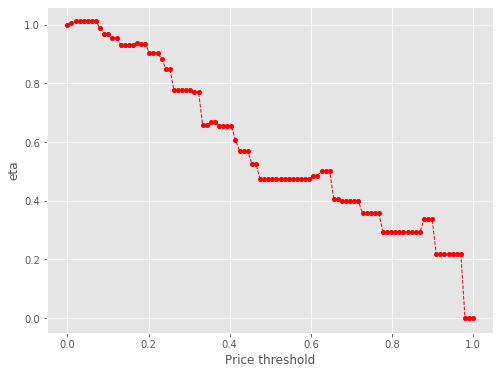

2406 46
Number of cells with price above 41.0th percentile:  46


eta =  1.0
eta =  0.9765632024639346
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9435322866252791
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9195148202057947
eta =  0.9195148202057947
eta =  0.927932518504381
eta =  0.9256158222001932
eta =  0.9032984032411319
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.873807769448956
eta =  0.8411776507423827
eta =  0.8411776507423827
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.6513060468465683
eta =  0.6513060468465683
eta =  0.6610864631619563
eta =  0.6610864631619563
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6472517199775882
eta =  0.6472517199775882
eta =  0.5633588749851861
eta =  0.5633588749851861
eta =  0.5633

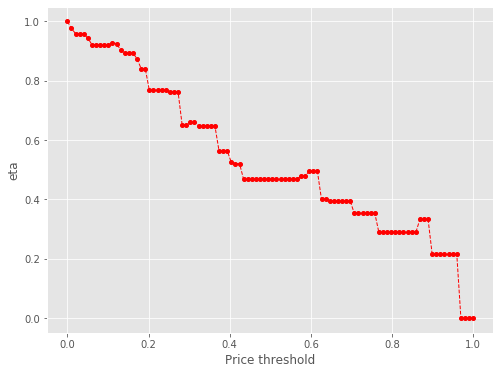

2406 46
Number of cells with price above 42.00000000000001th percentile:  46


eta =  1.0
eta =  0.9765632024639346
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9435322866252791
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9195148202057947
eta =  0.9195148202057947
eta =  0.927932518504381
eta =  0.9256158222001932
eta =  0.9032984032411319
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.873807769448956
eta =  0.8411776507423827
eta =  0.8411776507423827
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.6513060468465683
eta =  0.6513060468465683
eta =  0.6610864631619563
eta =  0.6610864631619563
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6472517199775882
eta =  0.6472517199775882
eta =  0.5633588749851861
eta =  0.5633588749851861
eta =  0.5633

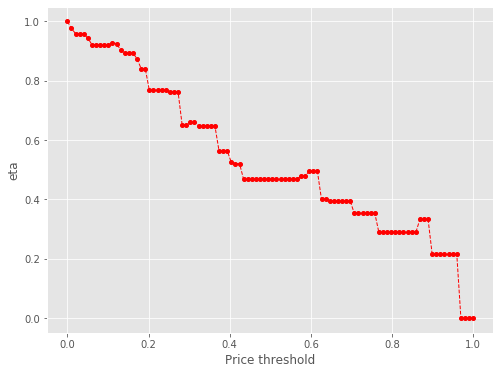

2406 46
Number of cells with price above 43.0th percentile:  46


eta =  1.0
eta =  0.9765632024639346
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9435322866252791
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9195148202057947
eta =  0.9195148202057947
eta =  0.927932518504381
eta =  0.9256158222001932
eta =  0.9032984032411319
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.873807769448956
eta =  0.8411776507423827
eta =  0.8411776507423827
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.6513060468465683
eta =  0.6513060468465683
eta =  0.6610864631619563
eta =  0.6610864631619563
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6472517199775882
eta =  0.6472517199775882
eta =  0.5633588749851861
eta =  0.5633588749851861
eta =  0.5633

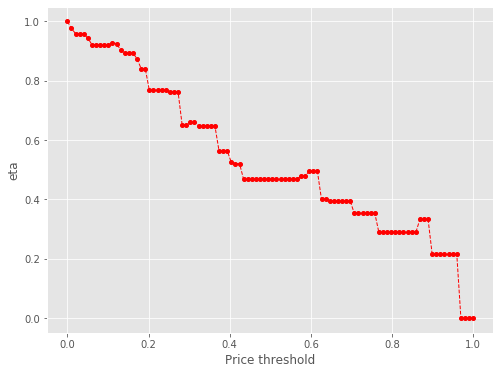

2406 46
Number of cells with price above 44.0th percentile:  46


eta =  1.0
eta =  0.9765632024639346
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9588966435474818
eta =  0.9435322866252791
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9218021925143883
eta =  0.9195148202057947
eta =  0.9195148202057947
eta =  0.927932518504381
eta =  0.9256158222001932
eta =  0.9032984032411319
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.8935485668668248
eta =  0.873807769448956
eta =  0.8411776507423827
eta =  0.8411776507423827
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.76786358163556
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.7631918785061398
eta =  0.6513060468465683
eta =  0.6513060468465683
eta =  0.6610864631619563
eta =  0.6610864631619563
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6488428518743241
eta =  0.6472517199775882
eta =  0.6472517199775882
eta =  0.5633588749851861
eta =  0.5633588749851861
eta =  0.5633

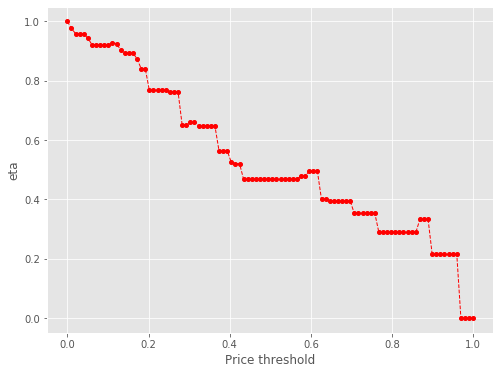

2406 42
Number of cells with price above 45.0th percentile:  42


eta =  1.0
eta =  0.9819094566824975
eta =  0.9819094566824975
eta =  0.9819094566824975
eta =  0.9661763665113366
eta =  0.943924766147874
eta =  0.943924766147874
eta =  0.943924766147874
eta =  0.9415824985887211
eta =  0.9415824985887211
eta =  0.9502022154461123
eta =  0.9478299201370708
eta =  0.9249768995616969
eta =  0.9149930742960023
eta =  0.9149930742960023
eta =  0.9149930742960023
eta =  0.8947785122809053
eta =  0.8847089295026034
eta =  0.8613652947602725
eta =  0.8228599000442026
eta =  0.7862917419970245
eta =  0.7862917419970245
eta =  0.7862917419970245
eta =  0.7862917419970245
eta =  0.7815079214336106
eta =  0.7815079214336106
eta =  0.7815079214336106
eta =  0.7244947270089911
eta =  0.6669369122277794
eta =  0.6769520513306161
eta =  0.6769520513306161
eta =  0.6769520513306161
eta =  0.6644146023905569
eta =  0.6644146023905569
eta =  0.6627852845003055
eta =  0.6627852845003055
eta =  0.5768790730224053
eta =  0.5768790730224053
eta =  0.5768790730224053
eta 

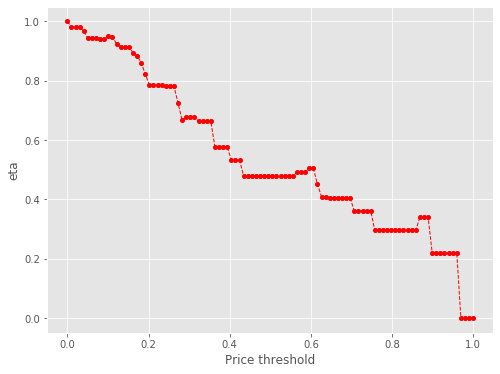

2406 39
Number of cells with price above 46.0th percentile:  39


eta =  1.0
eta =  0.9839770458833169
eta =  0.9613154855815733
eta =  0.9613154855815733
eta =  0.9613154855815733
eta =  0.9613154855815733
eta =  0.9589300644582587
eta =  0.9677085896050822
eta =  0.9652925875054014
eta =  0.9652925875054014
eta =  0.931850760850618
eta =  0.931850760850618
eta =  0.931850760850618
eta =  0.9112637689670747
eta =  0.9273372721747536
eta =  0.8772349516527742
eta =  0.8772349516527742
eta =  0.8007782557198383
eta =  0.8007782557198383
eta =  0.8007782557198383
eta =  0.8007782557198383
eta =  0.8007782557198383
eta =  0.7959062988088859
eta =  0.7959062988088859
eta =  0.7959062988088859
eta =  0.6792244515916042
eta =  0.6792244515916042
eta =  0.6894241080208987
eta =  0.6894241080208987
eta =  0.6766556711199868
eta =  0.6766556711199868
eta =  0.6766556711199868
eta =  0.674996334936632
eta =  0.674996334936632
eta =  0.5875074011115674
eta =  0.5875074011115674
eta =  0.5875074011115674
eta =  0.5875074011115674
eta =  0.5429554834565136
eta = 

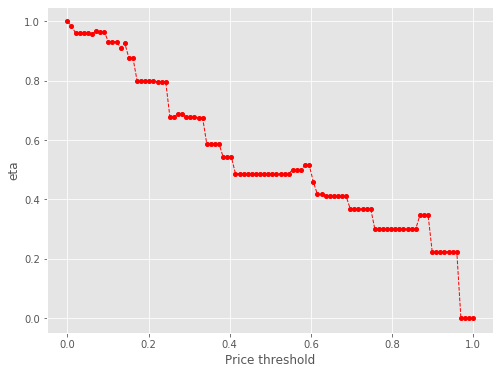

2406 38
Number of cells with price above 47.0th percentile:  38


eta =  1.0
eta =  0.976969421800485
eta =  0.976969421800485
eta =  0.976969421800485
eta =  0.9745451567901429
eta =  0.9745451567901429
eta =  0.9834666302976302
eta =  0.9810112863342838
eta =  0.9573582335713691
eta =  0.9470248973278589
eta =  0.9470248973278589
eta =  0.9470248973278589
eta =  0.9261026695485896
eta =  0.9156805736173248
eta =  0.8915197314031648
eta =  0.8915197314031648
eta =  0.8138180245871275
eta =  0.8138180245871275
eta =  0.8138180245871275
eta =  0.8138180245871275
eta =  0.8138180245871275
eta =  0.80886673336409
eta =  0.80886673336409
eta =  0.80886673336409
eta =  0.6902848541368807
eta =  0.7006506004436335
eta =  0.7006506004436335
eta =  0.7006506004436335
eta =  0.6876742439784786
eta =  0.6876742439784786
eta =  0.6876742439784786
eta =  0.6859878873807339
eta =  0.6859878873807339
eta =  0.597074295146958
eta =  0.597074295146958
eta =  0.597074295146958
eta =  0.597074295146958
eta =  0.5517968998647748
eta =  0.5517968998647748
eta =  0.55179

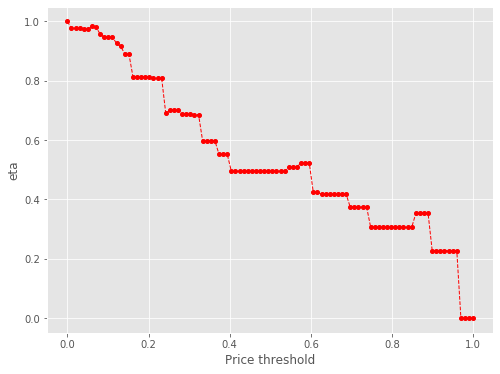

2406 37
Number of cells with price above 48.00000000000001th percentile:  37


eta =  1.0
eta =  0.9975185866044054
eta =  1.0066503703720544
eta =  1.00413714538409
eta =  1.00413714538409
eta =  0.9693495786004843
eta =  0.9693495786004843
eta =  0.9693495786004843
eta =  0.9479341409087794
eta =  0.9479341409087794
eta =  0.9125359622414358
eta =  0.9125359622414358
eta =  0.8717430981308679
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.827934544638466
eta =  0.827934544638466
eta =  0.827934544638466
eta =  0.7065572767515436
eta =  0.7065572767515436
eta =  0.7171673798678206
eta =  0.7171673798678206
eta =  0.7171673798678206
eta =  0.7038851254025373
eta =  0.7038851254025373
eta =  0.7021590154955998
eta =  0.7021590154955998
eta =  0.7021590154955998
eta =  0.6111494196477436
eta =  0.6111494196477436
eta =  0.6111494196477436
eta =  0.5694495986048163
eta =  0.5648046781728875
eta =  0.5648046781728875
eta =  0.5648046781728875
eta =  0.5068143400942903
eta =  0

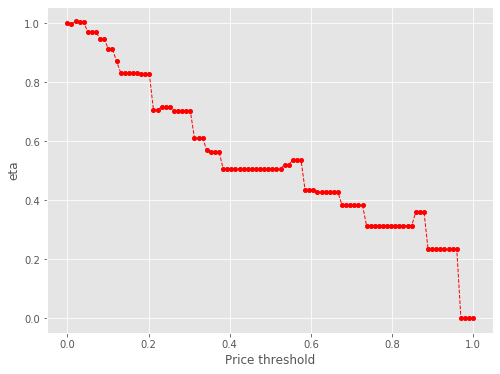

2406 37
Number of cells with price above 49.0th percentile:  37


eta =  1.0
eta =  0.9975185866044054
eta =  1.0066503703720544
eta =  1.00413714538409
eta =  1.00413714538409
eta =  0.9693495786004843
eta =  0.9693495786004843
eta =  0.9693495786004843
eta =  0.9479341409087794
eta =  0.9479341409087794
eta =  0.9125359622414358
eta =  0.9125359622414358
eta =  0.8717430981308679
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.8330025550721116
eta =  0.827934544638466
eta =  0.827934544638466
eta =  0.827934544638466
eta =  0.7065572767515436
eta =  0.7065572767515436
eta =  0.7171673798678206
eta =  0.7171673798678206
eta =  0.7171673798678206
eta =  0.7038851254025373
eta =  0.7038851254025373
eta =  0.7021590154955998
eta =  0.7021590154955998
eta =  0.7021590154955998
eta =  0.6111494196477436
eta =  0.6111494196477436
eta =  0.6111494196477436
eta =  0.5694495986048163
eta =  0.5648046781728875
eta =  0.5648046781728875
eta =  0.5648046781728875
eta =  0.5068143400942903
eta =  0

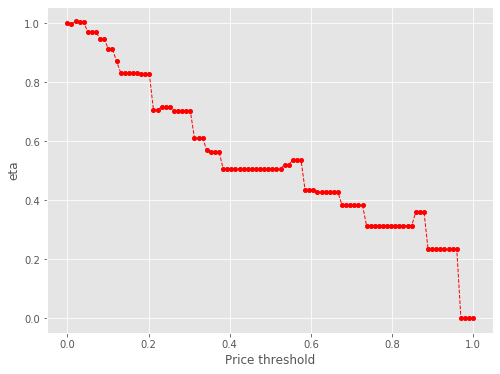

2406 36
Number of cells with price above 50.0th percentile:  36


eta =  1.0
eta =  1.0066350230146732
eta =  1.0066350230146732
eta =  0.9823641592192789
eta =  0.9717609191626098
eta =  0.9717609191626098
eta =  0.9717609191626098
eta =  0.9502922087252393
eta =  0.9687776006489772
eta =  0.9148059740397881
eta =  0.9148059740397881
eta =  0.8350747206703053
eta =  0.8350747206703053
eta =  0.8350747206703053
eta =  0.8350747206703053
eta =  0.8350747206703053
eta =  0.8299941031242231
eta =  0.8299941031242231
eta =  0.8299941031242231
eta =  0.8077710693615208
eta =  0.708314898829799
eta =  0.7189513954913744
eta =  0.7189513954913744
eta =  0.7189513954913744
eta =  0.7056361002741728
eta =  0.7056361002741728
eta =  0.7056361002741728
eta =  0.7039056965201803
eta =  0.7039056965201803
eta =  0.6539091762914303
eta =  0.6126697064644395
eta =  0.6126697064644395
eta =  0.6126697064644395
eta =  0.5662096784537178
eta =  0.5662096784537178
eta =  0.5662096784537178
eta =  0.5662096784537178
eta =  0.5080750844147248
eta =  0.5080750844147248
et

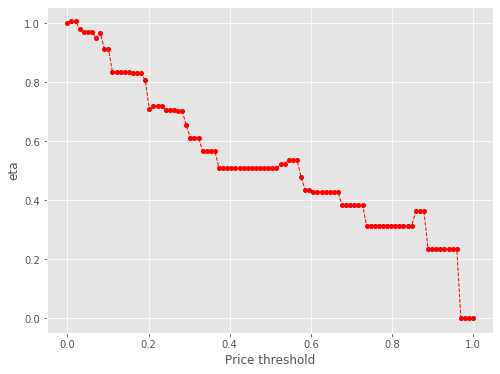

2406 34
Number of cells with price above 51.0th percentile:  34


eta =  1.0
eta =  0.9653557614679226
eta =  0.9653557614679226
eta =  0.9653557614679226
eta =  0.944028557519588
eta =  0.9368969338577222
eta =  0.9087762228857533
eta =  0.9087762228857533
eta =  0.8681514294518202
eta =  0.8295705013018734
eta =  0.8295705013018734
eta =  0.8295705013018734
eta =  0.8295705013018734
eta =  0.8295705013018734
eta =  0.8245233715776693
eta =  0.8245233715776693
eta =  0.8245233715776693
eta =  0.8024468162675343
eta =  0.7036461901638745
eta =  0.7142125785950273
eta =  0.7142125785950273
eta =  0.7142125785950273
eta =  0.7009850483454588
eta =  0.7009850483454588
eta =  0.7009850483454588
eta =  0.6992660501838309
eta =  0.6992660501838309
eta =  0.649599071501706
eta =  0.6086314229656093
eta =  0.6086314229656093
eta =  0.6086314229656093
eta =  0.5671034093525118
eta =  0.5624776264569372
eta =  0.5624776264569372
eta =  0.5624776264569372
eta =  0.5047262143662956
eta =  0.5047262143662956
eta =  0.5047262143662956
eta =  0.5047262143662956
eta

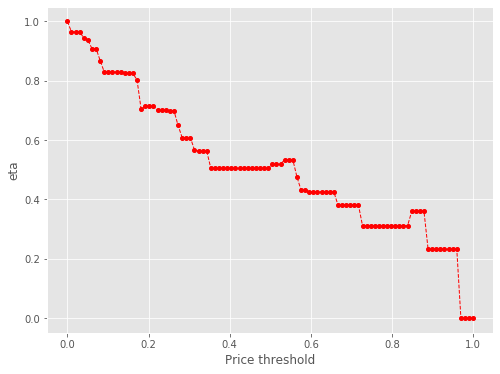

2406 32
Number of cells with price above 52.0th percentile:  32


eta =  1.0
eta =  0.9779074152767221
eta =  0.966902323477476
eta =  0.9413899612551809
eta =  0.9413899612551809
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.854113482809588
eta =  0.854113482809588
eta =  0.854113482809588
eta =  0.7918035090772888
eta =  0.7288983173352674
eta =  0.7398439073994789
eta =  0.7398439073994789
eta =  0.7398439073994789
eta =  0.7261416736971031
eta =  0.7261416736971031
eta =  0.7261416736971031
eta =  0.7243609849290432
eta =  0.7243609849290432
eta =  0.7243609849290432
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.5826635618786097
eta =  0.5826635618786097
eta =  0.5826635618786097
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =

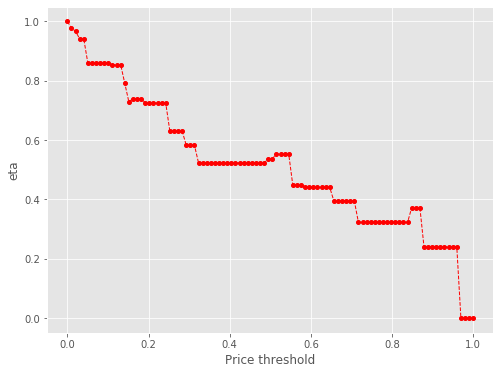

2406 32
Number of cells with price above 53.0th percentile:  32


eta =  1.0
eta =  0.9779074152767221
eta =  0.966902323477476
eta =  0.9413899612551809
eta =  0.9413899612551809
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.8593417415776606
eta =  0.854113482809588
eta =  0.854113482809588
eta =  0.854113482809588
eta =  0.7918035090772888
eta =  0.7288983173352674
eta =  0.7398439073994789
eta =  0.7398439073994789
eta =  0.7398439073994789
eta =  0.7261416736971031
eta =  0.7261416736971031
eta =  0.7261416736971031
eta =  0.7243609849290432
eta =  0.7243609849290432
eta =  0.7243609849290432
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.6304737043679345
eta =  0.5826635618786097
eta =  0.5826635618786097
eta =  0.5826635618786097
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =  0.5228395939739434
eta =

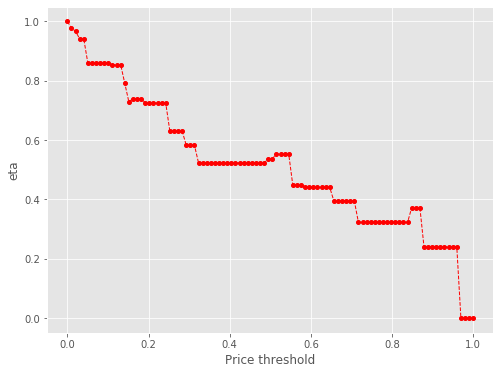

2406 31
Number of cells with price above 54.0th percentile:  31


eta =  1.0
eta =  0.9626575548450998
eta =  0.9626575548450998
eta =  0.9626575548450998
eta =  0.8787557269258354
eta =  0.8787557269258354
eta =  0.8787557269258354
eta =  0.8787557269258354
eta =  0.8787557269258354
eta =  0.8734093529374622
eta =  0.8734093529374622
eta =  0.8734093529374622
eta =  0.8734093529374622
eta =  0.7453653648070644
eta =  0.7453653648070644
eta =  0.7565582342885933
eta =  0.7565582342885933
eta =  0.7565582342885933
eta =  0.7425464439203829
eta =  0.7425464439203829
eta =  0.7425464439203829
eta =  0.7407255263772268
eta =  0.7407255263772268
eta =  0.7407255263772268
eta =  0.6447171731380389
eta =  0.6447171731380389
eta =  0.6447171731380389
eta =  0.6447171731380389
eta =  0.5958269185572452
eta =  0.5958269185572452
eta =  0.5958269185572452
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
eta =  0.5346514258980166
e

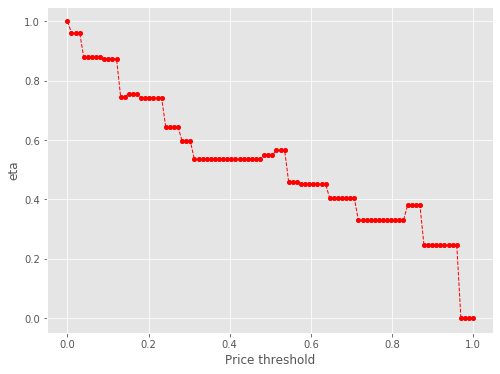

2406 25
Number of cells with price above 55.00000000000001th percentile:  25


eta =  1.0
eta =  0.9128435366273471
eta =  0.9128435366273471
eta =  0.9128435366273471
eta =  0.9128435366273471
eta =  0.9128435366273471
eta =  0.9128435366273471
eta =  0.9072897714681121
eta =  0.9072897714681121
eta =  0.9072897714681121
eta =  0.7742788295335202
eta =  0.7742788295335202
eta =  0.7859058815679582
eta =  0.7859058815679582
eta =  0.7859058815679582
eta =  0.7713505598985978
eta =  0.7713505598985978
eta =  0.7713505598985978
eta =  0.7694590071506955
eta =  0.7694590071506955
eta =  0.7694590071506955
eta =  0.6697263942854317
eta =  0.6697263942854317
eta =  0.6697263942854317
eta =  0.6697263942854317
eta =  0.6240297612009652
eta =  0.6189396380451395
eta =  0.6189396380451395
eta =  0.6189396380451395
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
eta =  0.5553910871078623
e

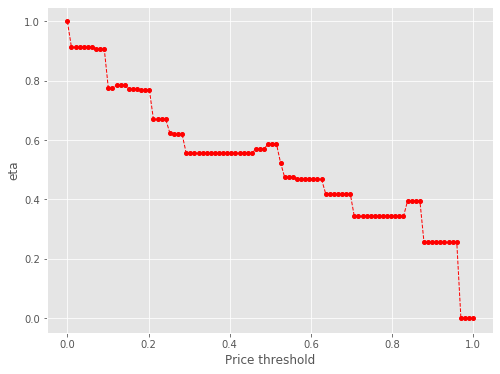

2406 23
Number of cells with price above 56.00000000000001th percentile:  23


eta =  1.0
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9673039422306207
eta =  0.848205413596094
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
et

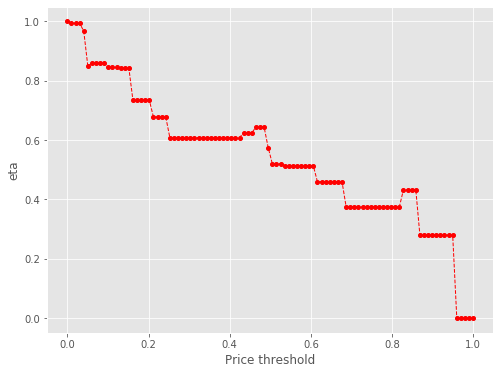

2406 23
Number of cells with price above 57.00000000000001th percentile:  23


eta =  1.0
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9673039422306207
eta =  0.848205413596094
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
et

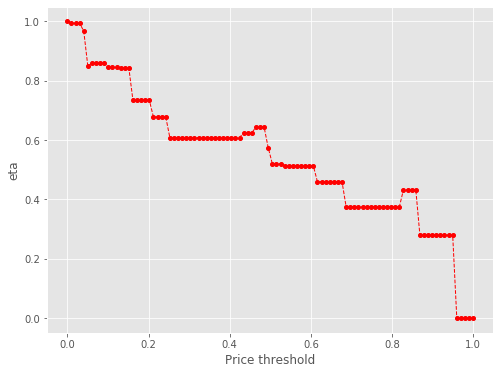

2406 23
Number of cells with price above 58.00000000000001th percentile:  23


eta =  1.0
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9939159725227893
eta =  0.9673039422306207
eta =  0.848205413596094
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8609425931541551
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8449975586708772
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.8429254042741983
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.7336705222888992
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6780347487937696
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
eta =  0.6084187101327874
et

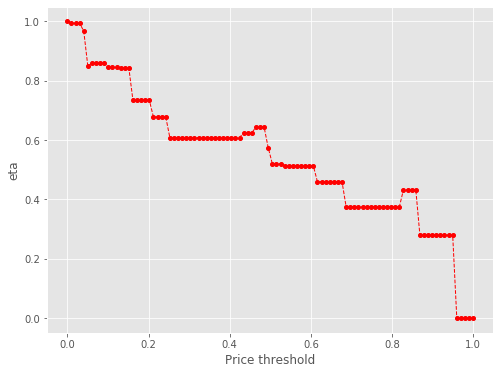

2406 22
Number of cells with price above 59.0th percentile:  22


eta =  1.0
eta =  0.8533975074805891
eta =  0.8533975074805891
eta =  0.8662126547467419
eta =  0.8662126547467419
eta =  0.8662126547467419
eta =  0.8662126547467419
eta =  0.8501700164110226
eta =  0.8501700164110226
eta =  0.8501700164110226
eta =  0.8480851777989422
eta =  0.8480851777989422
eta =  0.8480851777989422
eta =  0.7381615172424216
eta =  0.7381615172424216
eta =  0.7381615172424216
eta =  0.7381615172424216
eta =  0.7381615172424216
eta =  0.6821851821867397
eta =  0.6821851821867397
eta =  0.6821851821867397
eta =  0.6821851821867397
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
eta =  0.6121430049951603
e

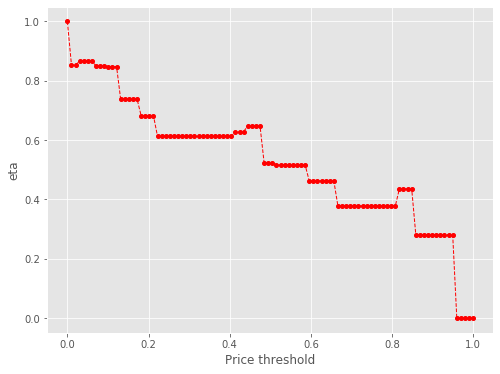

2406 20
Number of cells with price above 60.0th percentile:  20


eta =  1.0
eta =  0.9205545428621217
eta =  0.9343781619023641
eta =  0.9343781619023641
eta =  0.9343781619023641
eta =  0.9343781619023641
eta =  0.9170730684728801
eta =  0.9170730684728801
eta =  0.9170730684728801
eta =  0.9148241661282377
eta =  0.9148241661282377
eta =  0.9148241661282377
eta =  0.849846676737699
eta =  0.7962502024051945
eta =  0.7962502024051945
eta =  0.7962502024051945
eta =  0.7962502024051945
eta =  0.7419206229631831
eta =  0.7358688805984254
eta =  0.7358688805984254
eta =  0.7358688805984254
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
eta =  0.6603148230338398
et

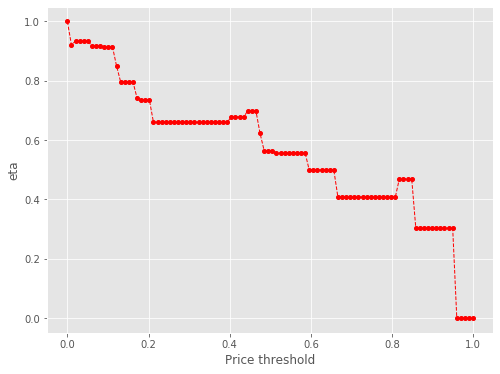

2406 18
Number of cells with price above 61.0th percentile:  18


eta =  1.0
eta =  0.981479561343502
eta =  0.981479561343502
eta =  0.981479561343502
eta =  0.9790727174805595
eta =  0.9790727174805595
eta =  0.9790727174805595
eta =  0.9095318270361096
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.7940260733969385
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7258049527684454
eta =  0.7258049527684454
eta 

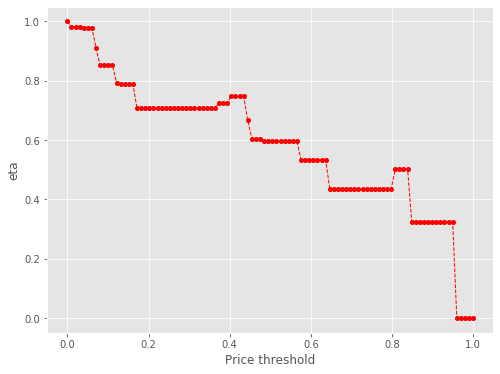

2406 18
Number of cells with price above 62.0th percentile:  18


eta =  1.0
eta =  0.981479561343502
eta =  0.981479561343502
eta =  0.981479561343502
eta =  0.9790727174805595
eta =  0.9790727174805595
eta =  0.9790727174805595
eta =  0.9095318270361096
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.8521712459375705
eta =  0.7940260733969385
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7875493141879727
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7066890579821129
eta =  0.7258049527684454
eta =  0.7258049527684454
eta 

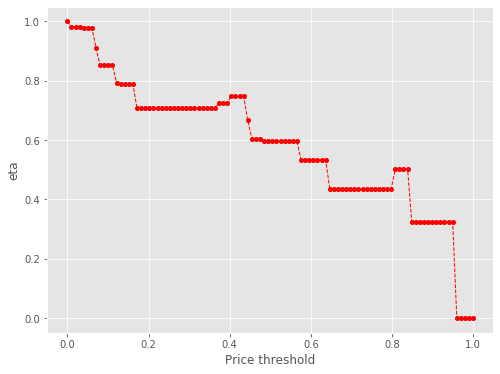

2406 17
Number of cells with price above 63.0th percentile:  17


eta =  1.0
eta =  0.9975477391911779
eta =  0.9975477391911779
eta =  0.9975477391911779
eta =  0.8682516473099783
eta =  0.8682516473099783
eta =  0.8682516473099783
eta =  0.8682516473099783
eta =  0.8682516473099783
eta =  0.8090092801423525
eta =  0.8024103050194268
eta =  0.8024103050194268
eta =  0.8024103050194268
eta =  0.8024103050194268
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7200242224247226
eta =  0.7395008325745719
eta =  0.7395008325745719
eta =  0.7395008325745719
eta =  0.7395008325745719
eta =  0.7615206420408115
e

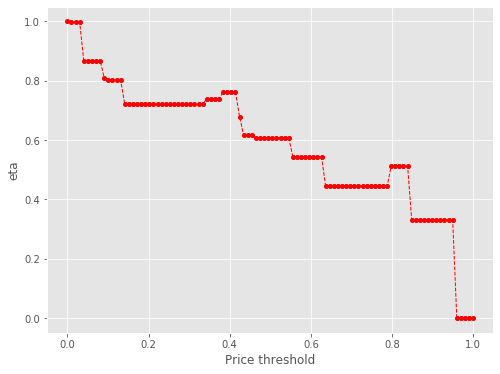

2406 16
Number of cells with price above 64.0th percentile:  16


eta =  1.0
eta =  0.8703860609357561
eta =  0.8703860609357561
eta =  0.8703860609357561
eta =  0.8703860609357561
eta =  0.8703860609357561
eta =  0.8043828615861828
eta =  0.8043828615861828
eta =  0.8043828615861828
eta =  0.8043828615861828
eta =  0.8043828615861828
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7217942501764636
eta =  0.7413187394662103
eta =  0.7413187394662103
eta =  0.7413187394662103
eta =  0.7413187394662103
eta =  0.7633926799916968
eta =  0.7633926799916968
eta =  0.7633926799916968
e

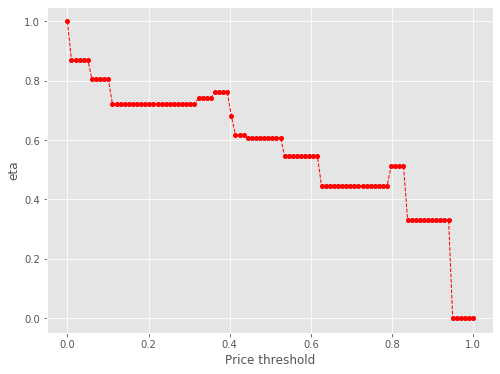

2406 14
Number of cells with price above 65.0th percentile:  14


eta =  1.0
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.7093328226531957
eta =  0.7093328226531957
e

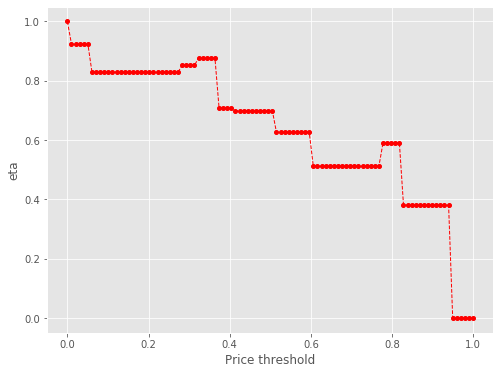

2406 14
Number of cells with price above 66.0th percentile:  14


eta =  1.0
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.9241679039774454
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8292805716585802
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8517125592167861
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.8770736507096285
eta =  0.7093328226531957
eta =  0.7093328226531957
e

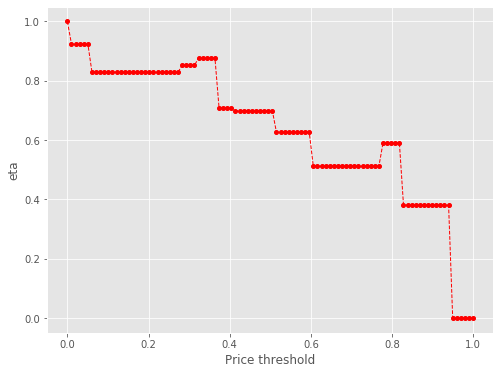

2406 12
Number of cells with price above 67.0th percentile:  12


eta =  1.0
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.8464947199539539
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7566005255014867
e

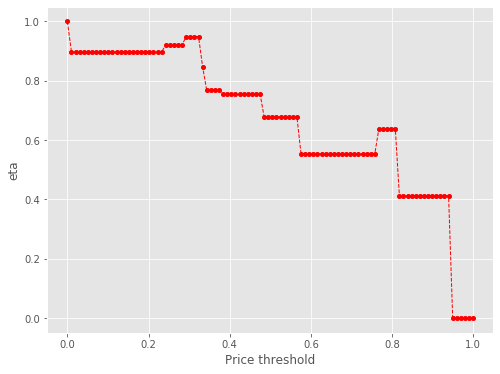

2406 12
Number of cells with price above 68.0th percentile:  12


eta =  1.0
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.8973267391017498
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9215993712302438
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.9490414533277642
eta =  0.8464947199539539
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7675367426204267
eta =  0.7566005255014867
e

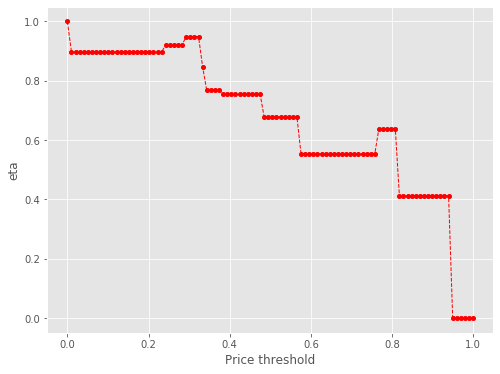

2406 11
Number of cells with price above 69.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

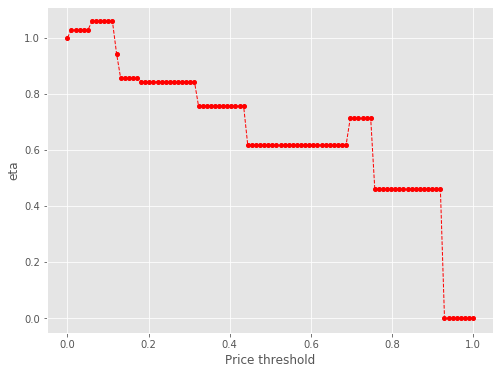

2406 11
Number of cells with price above 70.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

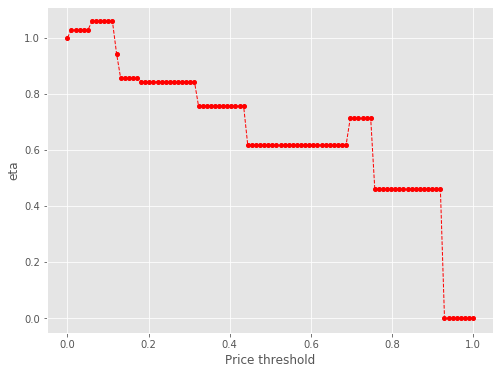

2406 11
Number of cells with price above 71.00000000000001th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

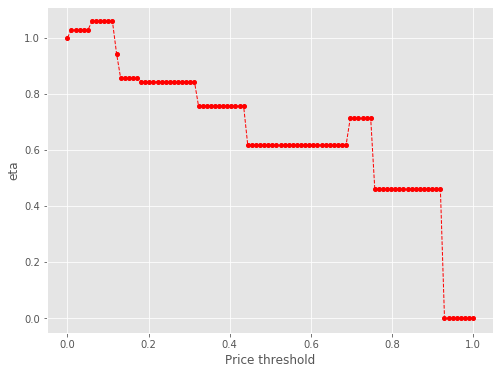

2406 11
Number of cells with price above 72.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

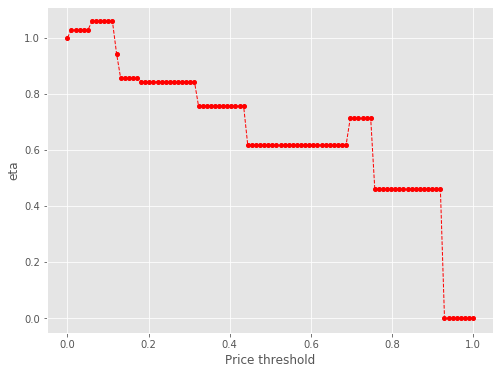

2406 11
Number of cells with price above 73.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

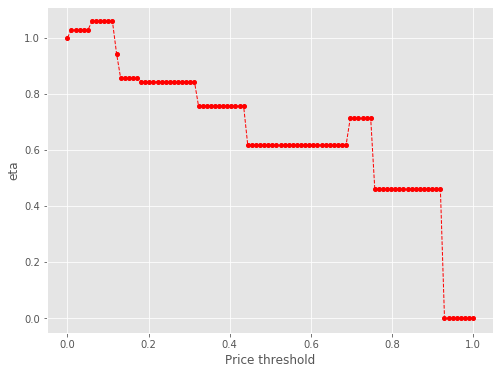

2406 11
Number of cells with price above 74.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

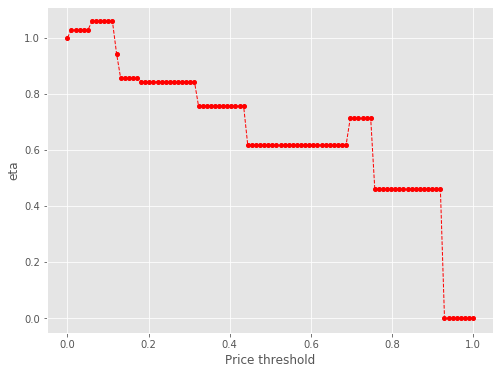

2406 11
Number of cells with price above 75.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

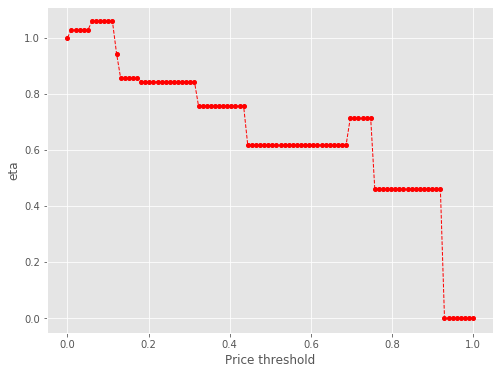

2406 11
Number of cells with price above 76.0th percentile:  11


eta =  1.0
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.027049937409412
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  1.0576319772636915
eta =  0.9433517169022733
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.8553592678947173
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.843171714975156
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.7558424635259336
eta =  0.75584246352

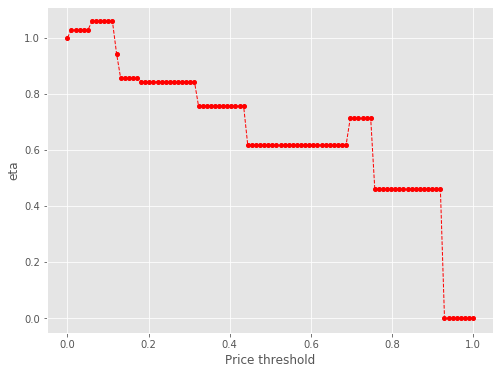

2406 10
Number of cells with price above 77.0th percentile:  10


eta =  1.0
eta =  1.029776585091294
eta =  1.029776585091294
eta =  1.029776585091294
eta =  1.029776585091294
eta =  1.029776585091294
eta =  1.029776585091294
eta =  0.9185061821645639
eta =  0.8328312351123256
eta =  0.8328312351123256
eta =  0.8328312351123256
eta =  0.8328312351123256
eta =  0.8328312351123256
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.8209646719826859
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  0.7359354555168361
eta =  

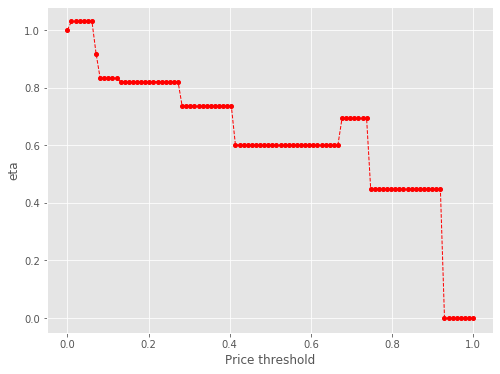

2406 9
Number of cells with price above 78.0th percentile:  9


eta =  1.0
eta =  0.8087494386352664
eta =  0.8087494386352664
eta =  0.8087494386352664
eta =  0.8087494386352664
eta =  0.8087494386352664
eta =  0.8087494386352664
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.7972260040365007
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.71465545650525
eta =  0.5834799826753067
eta =  0.5834799826753067
eta =  0.5834799826753067
eta

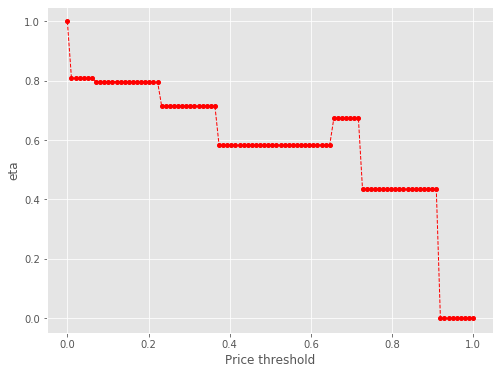

2406 8
Number of cells with price above 79.0th percentile:  8


eta =  1.0
eta =  0.9067236032637956
eta =  0.9067236032637956
eta =  0.9067236032637956
eta =  0.9067236032637956
eta =  0.9067236032637956
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8938041876299511
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.8012308134742445
eta =  0.6541643765668774
eta =  0.6541643765668774
eta =  0.6541643765668774
e

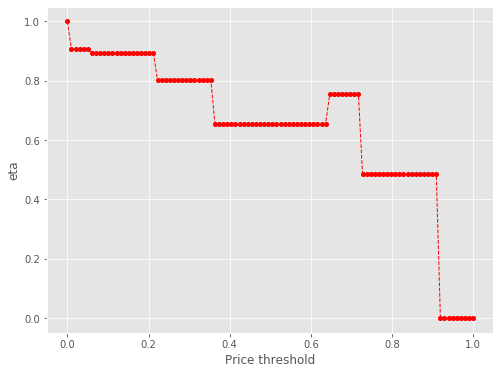

2406 7
Number of cells with price above 80.0th percentile:  7


eta =  1.0
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.9857515392923042
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.8836549645230094
eta =  0.7214595210846845
eta =  0.7214595210846845
eta =  0.7214595210846845
eta =  0.7214595210846845
eta =  0.7214595210846845
eta =  0.7214595210846845
eta =  0.7214595210846845
e

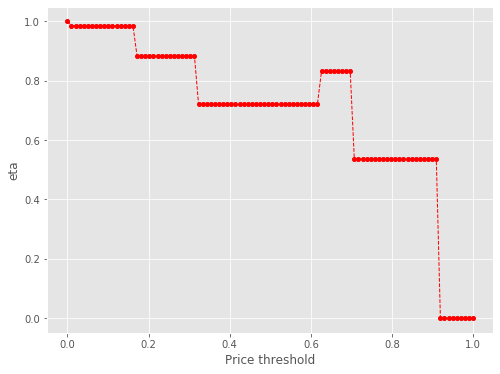

2406 6
Number of cells with price above 81.0th percentile:  6


eta =  1.0
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
e

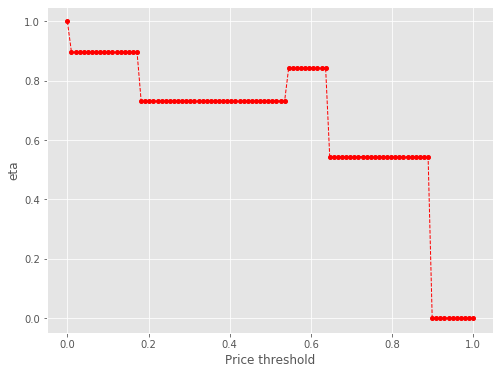

2406 6
Number of cells with price above 82.0th percentile:  6


eta =  1.0
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
e

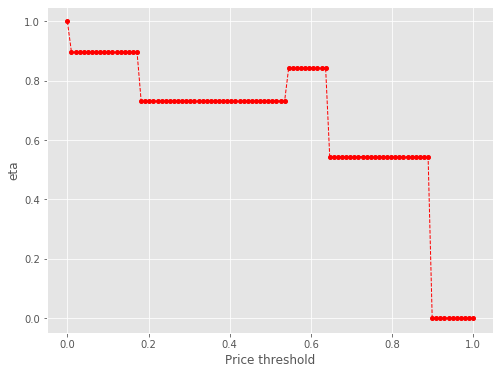

2406 6
Number of cells with price above 83.0th percentile:  6


eta =  1.0
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.8964276790857537
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
eta =  0.7318877955824836
e

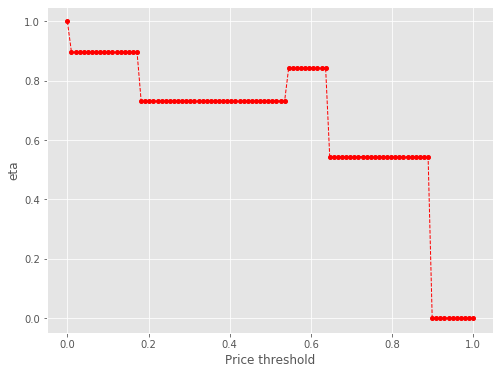

2406 5
Number of cells with price above 84.00000000000001th percentile:  5


eta =  1.0
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
e

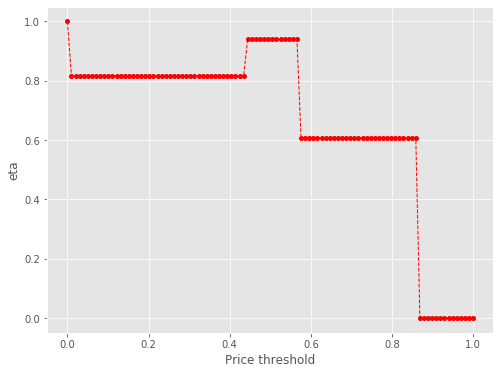

2406 5
Number of cells with price above 85.0th percentile:  5


eta =  1.0
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
e

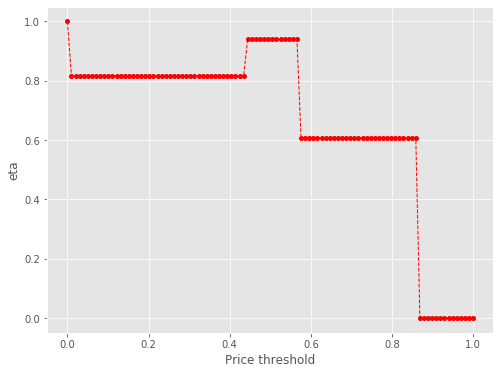

2406 5
Number of cells with price above 86.0th percentile:  5


eta =  1.0
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
eta =  0.8164493496328888
e

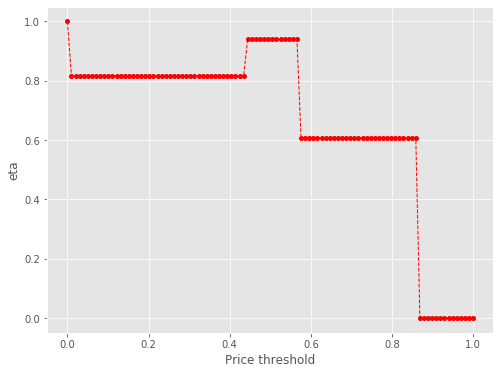

2406 4
Number of cells with price above 87.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

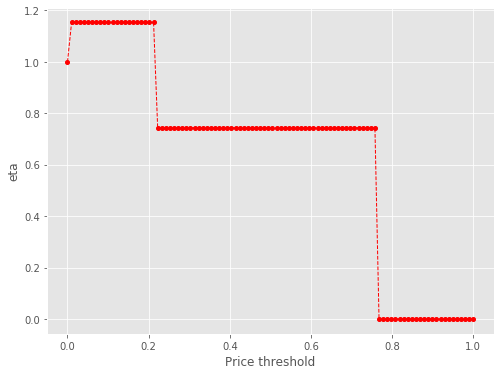

2406 4
Number of cells with price above 88.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

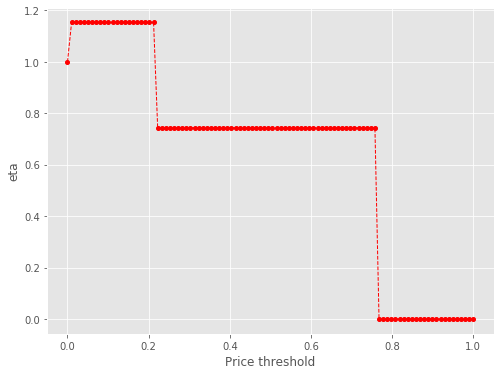

2406 4
Number of cells with price above 89.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

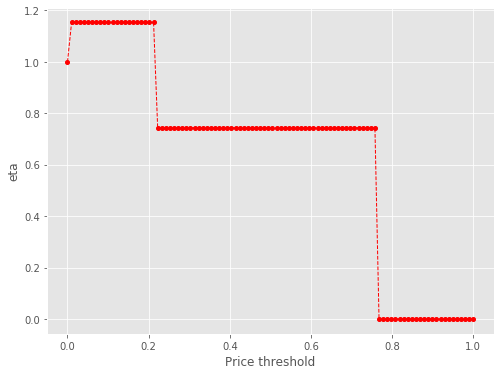

2406 4
Number of cells with price above 90.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

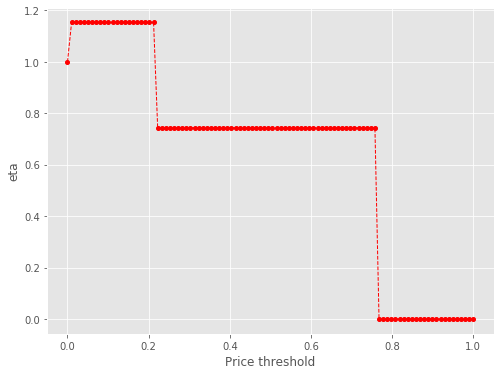

2406 4
Number of cells with price above 91.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

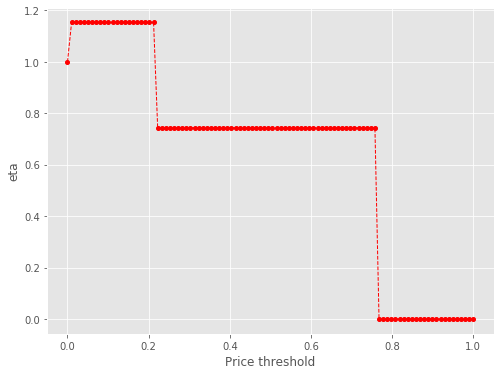

2406 4
Number of cells with price above 92.0th percentile:  4


eta =  1.0
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  1.1532558162373343
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
eta =  0.7439654047073602
e

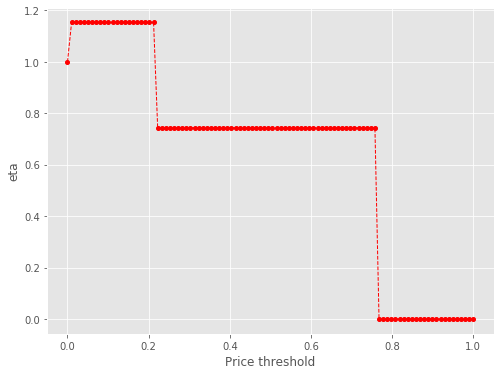

2406 3
Number of cells with price above 93.0th percentile:  3


eta =  1.0
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.64510

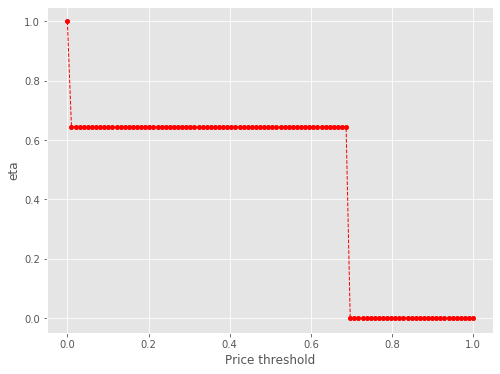

2406 3
Number of cells with price above 94.0th percentile:  3


eta =  1.0
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.645100067333418
eta =  0.64510

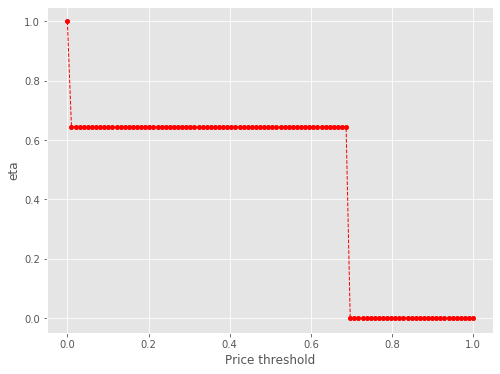

2406 2
Number of cells with price above 95.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

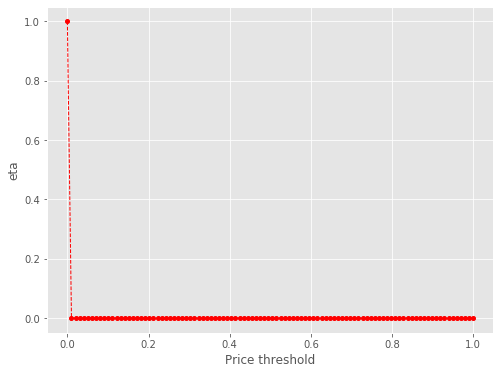

2406 2
Number of cells with price above 96.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

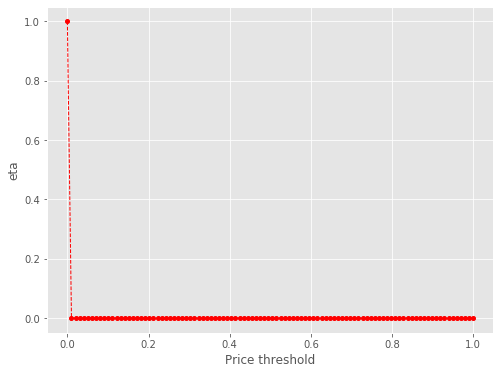

2406 2
Number of cells with price above 97.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

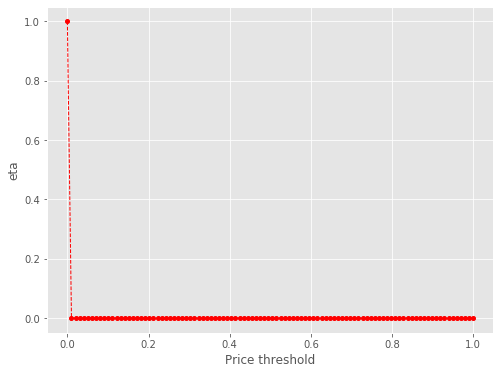

2406 2
Number of cells with price above 98.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

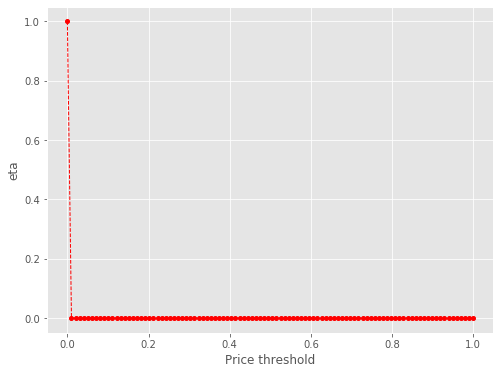

2406 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



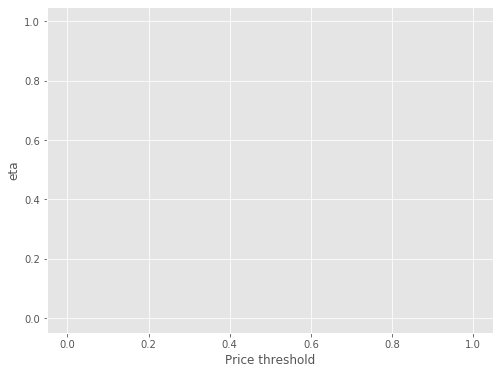

2406 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

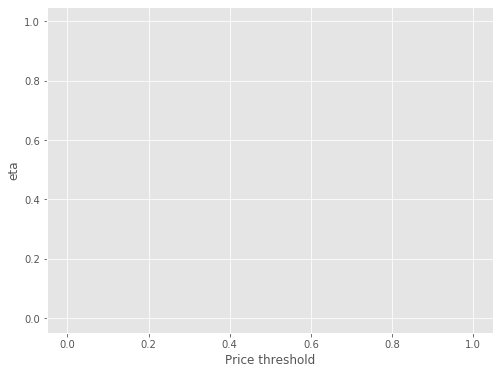


time: 1min 11s


In [27]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

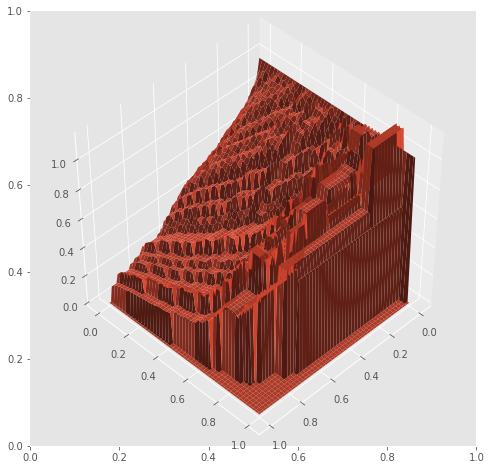

time: 1.53 s


In [28]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [29]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Denver'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 42 ms


2406 202
Number of cells with price above 5th percentile:  202
total number of cells:  2406
number of cells within urban airbnb territory:  202



Mean travel times in minutes:  12.000288337723148
Mean travel times in minutes:  22.516422836796416


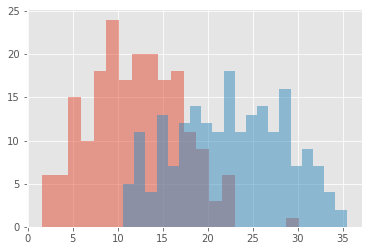

time: 18.8 s


In [30]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.4)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

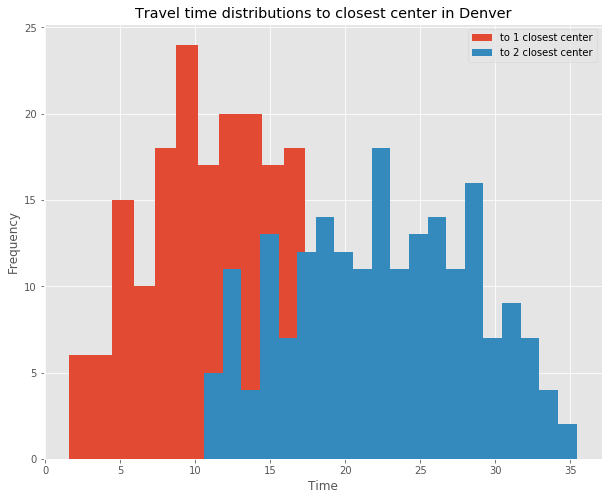

time: 519 ms


In [31]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Denver')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [32]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Denver'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 746 ms


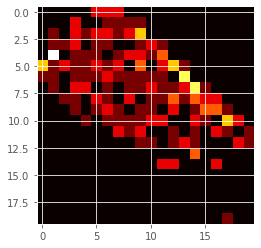

time: 191 ms


In [33]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [34]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.607627294586068
0.8309280876490609
2.8989341396129458
average mutual information =  2.1124965072826916
time: 15 ms


In [35]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Denver'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.9300969123092464,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 9.99 ms
